# Supporting simulation code for "Programmable photonic system for quantum simulation in arbitrary topologies"

In [1]:
import qutip as qt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import cm

from collections.abc import Iterable
import types

import pickle
import glob
import os
import time
from multiprocessing import Pool

import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm.contrib.concurrent import process_map as tqdm_parallel

from synthetic_hamiltonians import *

In [2]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42


%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

# 1D Time evolution

In [12]:
def simulate_1d_evolution_and_save(N=2, D=32, κ=0.2, μ=1, U=1, tmax=200, tstep=1, initial_state="same_bin", toroidal=False, use_ponomarev=True):
    
    start = time.time()
        
    # Create initial state
    fock_list = [0] * D
    
    if initial_state == "same_bin":
        photon_location = D // 2
        fock_list[photon_location] = N
    elif initial_state == "close_bins":
        photon_locations = [D//2-1, D//2+1]
        fock_list[photon_locations[0]] = N // 2
        fock_list[photon_locations[1]] = N // 2
    else:
        raise ValueError()
    

    if use_ponomarev:
        state_initial = qt_fock_to_ponomarev(fock_list, N, D)
    else:
        # state_initial = create_initial_state_all_photons_one_bin(num_sites=D, num_bosons=N, 
        #                                                          full_bin_index=photon_location,
        #                                                          use_ponomarev=use_ponomarev)
        state_initial = qt.basis([N+1] * D, fock_list)
    
    H = BHH_1d_line(D, num_bosons=N,
                    toroidal=toroidal,
                    κ=κ, μ=μ, U=U,
                    include_chemical_potential=True, #(μ != 0.0),
                    include_onsite_interaction=True, #(U != 0.0),
                    use_ponomarev=use_ponomarev,
                    display_progress=False)

    photon_expectations_over_time = []
    states_over_time = []

    for t in tqdm(range(0, tmax, tstep), desc="Evolving states"):
        state_evolved = (-1j * H * t).expm() * state_initial
        states_over_time.append(state_evolved)

    two_photon_correlations_over_time = [get_two_photon_correlations(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)
                                         for state in tqdm(states_over_time, desc="Computing 2-photon correlations")]
    photon_expectations_over_time = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                     for state in states_over_time]
    double_photon_expectations_over_time = [np.array(get_double_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                            for state in states_over_time]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    filename = f"results/1d_evolution_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{tmax=}_{toroidal=}_{initial_state}_results.pickle"
    obj = {
        "state_initial": state_initial,
        "H": H,
        "states_over_time": states_over_time,
        "photon_expectations_over_time": photon_expectations_over_time,
        "double_photon_expectations_over_time": double_photon_expectations_over_time,
        "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Simulation complete. Elapsed time: {time.time()-start}s. Results saved to {filename}")
    
    return filename


In [13]:
# simulate_1d_evolution_and_save(N=2, D=7, κ=0.25, μ=0, U=1e-10, tmax=300, toroidal=False)
# simulate_1d_evolution_and_save(N=2, D=7, κ=0.25, μ=0, U=10, tmax=300, toroidal=False)
# simulate_1d_evolution_and_save(N=2, D=7, κ=-0.25, μ=0, U=1e-10, tmax=300, toroidal=False)
# simulate_1d_evolution_and_save(N=2, D=5, κ=-0.25, μ=0, U=-10, tmax=300, toroidal=False, use_ponomarev=False)

In [14]:
def plot_1d_state_evolution(photon_expectations_over_time, 
                            two_photon_correlations_over_time,
                            photon_correlation_snapshots = [0, 5, 15],
                            double_photon_expectations_over_time=None,
                            take_sqrt_of_amplitudes=False,
                            figscale = 12, savefig = False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=16)

    fig = plt.figure(figsize=(figscale, .75 * figscale), tight_layout=True)
    if double_photon_expectations_over_time is not None:
        gs = mpl.gridspec.GridSpec(nrows=3, ncols=4, height_ratios = [1.5, 1, 1], width_ratios=[1, 1, 1, 0.05])
    else:
        gs = mpl.gridspec.GridSpec(nrows=2, ncols=4, height_ratios = [1.5, 1], width_ratios=[1, 1, 1, 0.05])
    

    ax = fig.add_subplot(gs[0, :-1])
    cax = fig.add_subplot(gs[0, -1])
    
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[1, 2], sharey=ax1)
    cax2 = fig.add_subplot(gs[1, -1])
    

    # Plot evolved state
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.xaxis.tick_top()
    ax.set_xlabel("Time $ t / \\hbar $")
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("Site index")
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_over_time)), aspect='auto', cmap=cmap)#, vmax=1)#0.5)
    else:
        ax.imshow(np.transpose(photon_expectations_over_time), aspect='auto', cmap=cmap)#, vmax=1)#.5)
        
    max_photons = np.max(photon_expectations_over_time)

    mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons), ticks = [0, max_photons])#.5])
    # cax.set_yticklabels(["$0$", "$0.5$"])
    
    mpl.colorbar.ColorbarBase(cax2, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons), ticks = [0, max_photons])
    # cax2.set_yticklabels(["$0$", "$1$"])
        

    cax.get_yaxis().labelpad=2
    cax.set_ylabel("Photon occupancy", rotation=270)
    cax2.get_yaxis().labelpad=8
    cax2.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i \\hat a_j ^\\dagger \\hat a_j \\rangle$", rotation=270)
    
    
    # Add 2-photon correlation subplots
    for i, axis in enumerate([ax1, ax2, ax3]):
        
        if i == 0:
            axis.set_ylabel("$i$")
            axis.set_xlabel("$j$")
            
        if i > 0:
            plt.setp(axis.get_yticklabels(), visible=False)
            axis.set_xlabel("$j$")

    
        time_index = photon_correlation_snapshots[i]
        two_photon_correlations = two_photon_correlations_over_time[time_index]
        axis.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
        axis.text(.97, 0.97, f"$t = {time_index}$", ha = 'right', va = 'top', color="white", transform = axis.transAxes)
        
    if double_photon_expectations_over_time:
        ax_double = fig.add_subplot(gs[2, :-1])
        cax_double = fig.add_subplot(gs[2, -1])
        ax_double.imshow(np.transpose(double_photon_expectations_over_time), aspect='auto', cmap=cmap, vmax=0.5)
        max_photons_double = np.max(double_photon_expectations_over_time)

        mpl.colorbar.ColorbarBase(cax_double, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons_double), ticks = [0, max_photons_double])
        # cax_double.set_yticklabels(["$0$", "$0.5$"])
        
        cax_double.get_yaxis().labelpad=8
        cax_double.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i ^\\dagger  \\hat a_i \\hat a_i \\rangle$", rotation=270)
        

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_1d_state_evolution_from_file(filename, include_description=False, 
                                      photon_correlation_snapshots = [0, 5, 15],
                                      include_two_photon_expectations=False,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    double_photon_expectations_over_time = obj["double_photon_expectations_over_time"] if include_two_photon_expectations else None

    fig = plot_1d_state_evolution(photon_expectations_over_time, two_photon_correlations_over_time, 
                        photon_correlation_snapshots = photon_correlation_snapshots,
                        double_photon_expectations_over_time=double_photon_expectations_over_time,
                        take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                        savefig = savefig)
    
    if include_description:
        # variables = []
        # values = []
        conditions = []
        for txt in filename.split("_"):
            if "=" in txt:
                # variable, value = txt.split("=")
                # variables.append(variable)
                # values.append(value)
                conditions.append(txt)
        description = ", ".join(conditions)
        fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
                
    return fig

## Miscellaneous tests

In [18]:
N = 2
D = 15
μ_list = .1 * np.arange(D)
κ = 0.1
tmax = 2000
tstep = 10
state_type = "same_bin"

filenames = [
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0*μ_list, U=0, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=1*μ_list, U=0, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0*μ_list, U=.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=1*μ_list, U=.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0*μ_list, U=-.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=1*μ_list, U=-.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True)
]
for filename in filenames:
    print(filename)
    plot_1d_state_evolution_from_file(filename, include_description=True, 
                                      photon_correlation_snapshots = [0, 30, 60],
                                      include_two_photon_expectations=True,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False)
    savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
    plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
    # plt.show()

Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 14.1287100315094s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1e-10_tmax=200_toroidal=False_same_bin_results.pickle


Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 14.977906942367554s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1_tmax=200_toroidal=False_same_bin_results.pickle


Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 14.56722378730774s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1e-10_tmax=200_toroidal=False_close_bins_results.pickle


Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 15.130862951278687s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1_tmax=200_toroidal=False_close_bins_results.pickle


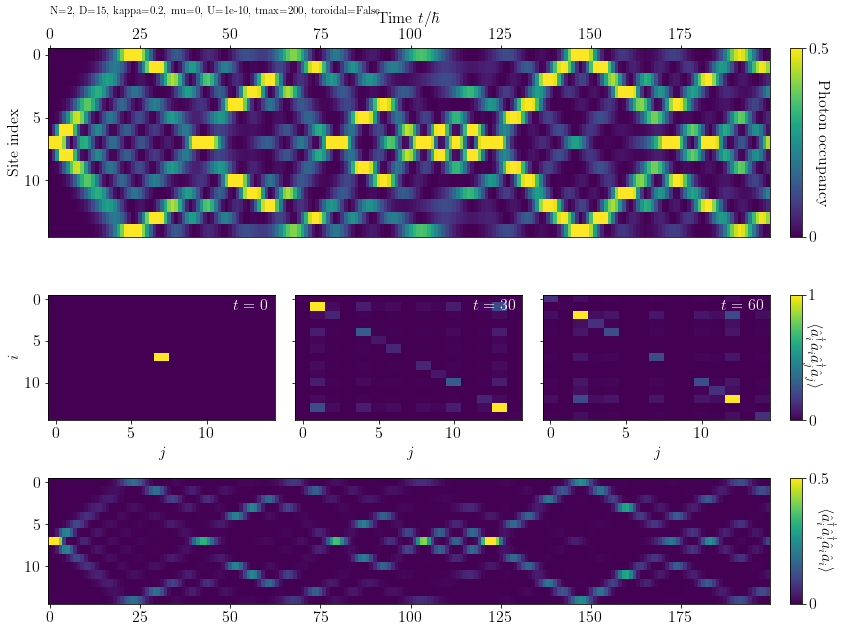

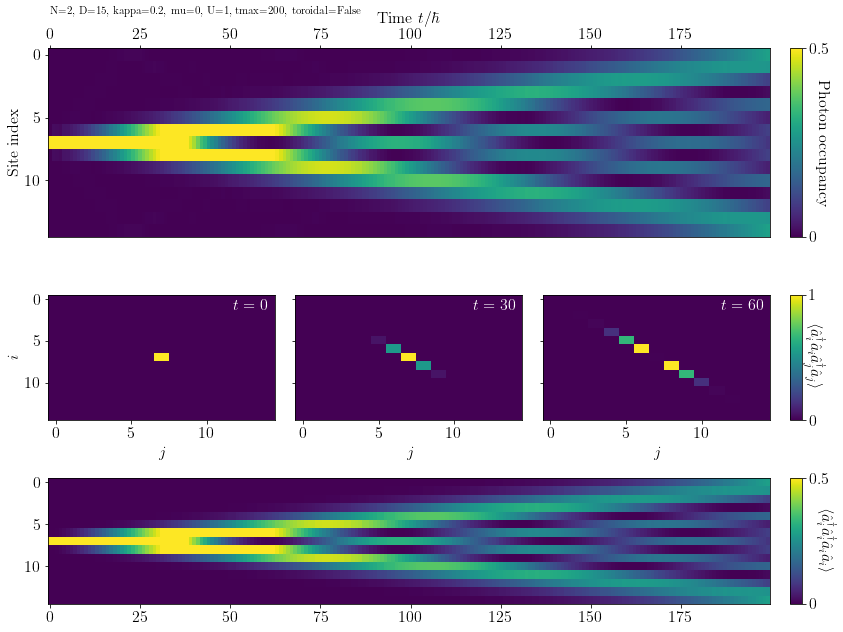

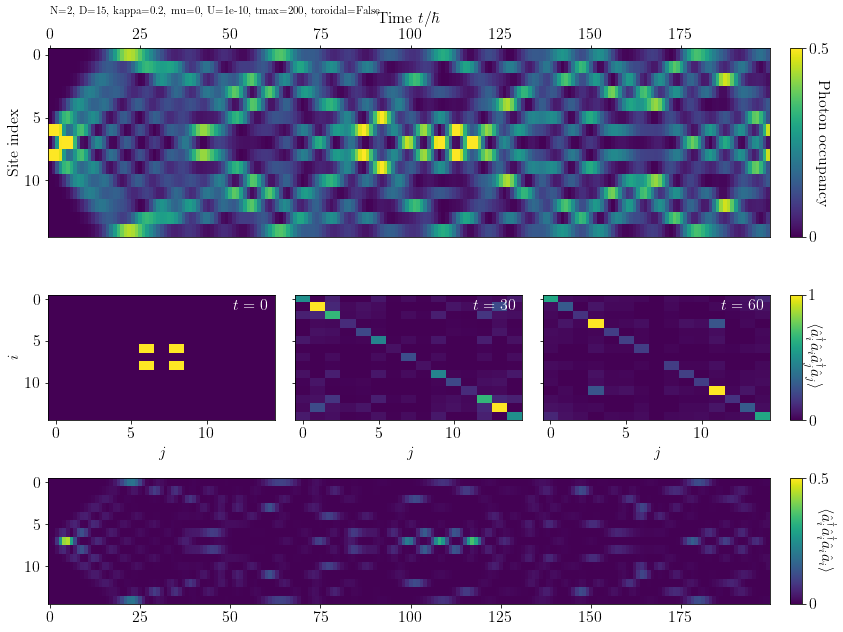

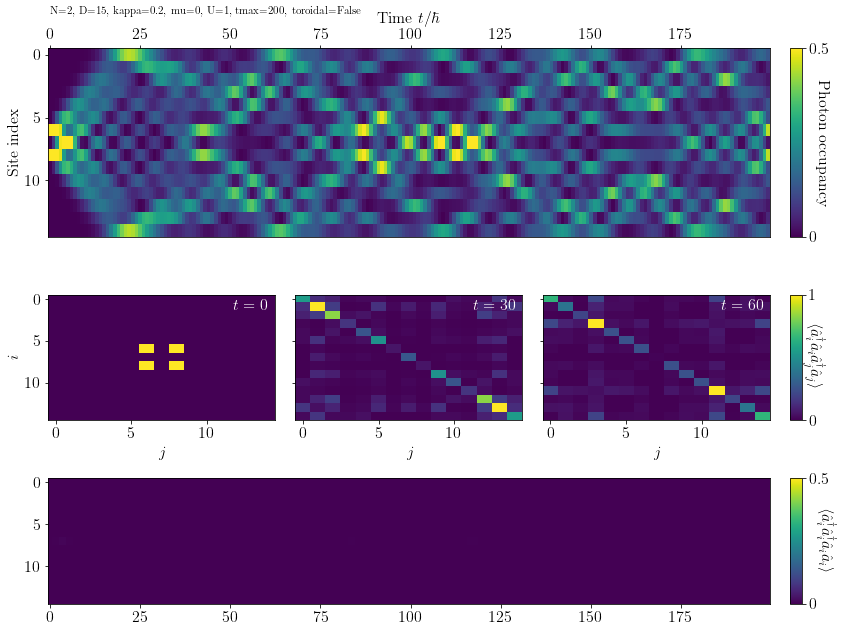

In [15]:
filenames = [
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1e-10, tmax=200, initial_state="same_bin", toroidal=False),
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1, tmax=200, initial_state="same_bin", toroidal=False),
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1e-10, tmax=200, initial_state="close_bins", toroidal=False),
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1, tmax=200, initial_state="close_bins", toroidal=False),
]

for filename in filenames:
    fig = plot_1d_state_evolution_from_file(filename, include_description=True, 
                                      photon_correlation_snapshots = [0, 30, 60],
                                      include_two_photon_expectations=True,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False)
    savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
    plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
    # plt.show()

In [67]:
def plot_two_photon_correlations(two_photon_correlations):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=14)

    fig, ax = plt.subplots(1,1, figsize=(4,4))

    # Plot state over training
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
    # ax.set_xticks([])
    # ax.yaxis.set_major_locator(plt.IndexLocator(base=1, offset=0.35))
    # ax.yaxis.set_ticks_position('none')
    # ax.set_yticklabels(kets)
    # ax.tick_params(axis = 'y', labelsize = 10, pad = 0)
    
    # Add a colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '2%', pad = '1%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(0, 1),
                                     ticks = [0, 1])
    cax.get_yaxis().labelpad=0
    cax.set_ylabel("Two-photon correlations", rotation=270)
    cax.set_yticklabels(["$0$", "$1$"])
    
    return fig, ax, cax


# plot_two_photon_correlations(two_photon_correlations_over_time[0])
# plt.show()

# plt.savefig("1d_evolution_toroidal.pdf", dpi=300, bbox_inches='tight', pad_inches=0)

In [126]:
def plot_1d_state_evolution_animated(photon_expectations_until_time, 
                                     two_photon_correlations_at_time,
                                     tmax=None,
                                     take_sqrt_of_amplitudes=False,
                                     figscale = 12, savefig = False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=16)

    fig = plt.figure(figsize=(figscale, .45 * figscale), tight_layout=True)
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, 
                               width_ratios=[1, 1.2, 0.05], hspace=0.0)#,
                               #hspace=0.1)

    ax1 = fig.add_subplot(gs[0, 0])
    ax = fig.add_subplot(gs[0, 1:-1], sharey=ax1)
    cax = fig.add_subplot(gs[0, -1])

    # Plot evolved state
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.set_xlabel("Time $ t / \\hbar $")
    plt.setp(ax.get_yticklabels(), visible=False)
    ax1.set_ylabel("Site index $i$")
    ax1.set_xlabel("Site index $j$")
    
    if tmax is not None:
        ax.set_xlim(0, tmax)
    
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_until_time)), aspect='auto', cmap=cmap)
    else:
        ax.imshow(np.transpose(photon_expectations_until_time), aspect='auto', cmap=cmap)

    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])
    cax.set_yticklabels(["$0$", "$1$"])
    cax.get_yaxis().labelpad=2
    cax.set_ylabel("Photon occupancy, correlation", rotation=270)

    ax1.imshow(two_photon_correlations_at_time, aspect='auto', cmap=cmap)
    time = len(photon_expectations_until_time)
    ax1.text(.97, 0.97, f"$t = {time}$", ha = 'right', va = 'top', color="white", transform = ax1.transAxes)

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_1d_state_evolution_animated_from_file(filename,
                                               t=None,
                                               include_description=False, 
                                               take_sqrt_of_amplitudes=False,
                                               savefig = False):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    tmax = len(photon_expectations_over_time)
    
    if t == "all" and savefig == True:
        
        # Render *ALL* the frames!
        for t in tqdm(range(1, tmax), desc="Rendering frames"):
        
            fig = plot_1d_state_evolution_animated(photon_expectations_over_time[0:t], two_photon_correlations_over_time[t], 
                                                   tmax = tmax-1,
                                                   take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                                                   savefig = False)

            if include_description:
                conditions = []
                for txt in filename.split("_"):
                    if "=" in txt:
                        conditions.append(txt)
                description = ", ".join(conditions)
                fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)

            title = str(t).zfill(8) + "_".join(conditions) + ".png"
            plt.savefig("frames/"+title, bbox_inches='tight', pad_inches=0)
            plt.close()
    
    elif type(t) is int:
    
        fig = plot_1d_state_evolution_animated(photon_expectations_over_time[0:t], two_photon_correlations_over_time[t], 
                                               tmax = tmax,
                                               take_sqrt_of_amplitudes=take_sqrt_of_amplitudes)

        if include_description:
            conditions = []
            for txt in filename.split("_"):
                if "=" in txt:
                    conditions.append(txt)
            description = ", ".join(conditions)
            fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
            
    
                
    
filename = "results/1d_evolution_N=2_D=32_kappa=0.2_mu=1_U=1_tmax=100_toroidal=False_results.pickle"
plot_1d_state_evolution_animated_from_file(filename, include_description=True,
                                           t="all",
                                           take_sqrt_of_amplitudes=False,
                                           savefig = True)       
# plt.show()

Rendering frames:   0%|          | 0/99 [00:00<?, ?it/s]

## Two-photon bound state testing

In [3]:
def simulate_1d_evolution_and_save(N=2, D=32, κ=0.2, μ=1, U=1, tmax=200, tstep=1, 
                                   initial_state="same_bin", toroidal=False, use_ponomarev=True,
                                   synthetic=True):
    
    D_orig = D
    if synthetic:
        D += 1
    
    start = time.time()
        
    # Create initial state
    fock_list = [0] * D
    
    if initial_state == "same_bin":
        photon_location = D // 2
        fock_list[photon_location] = N
    elif initial_state == "close_bins":
        photon_locations = [D//2-1, D//2+1]
        fock_list[photon_locations[0]] = N // 2
        fock_list[photon_locations[1]] = N // 2
    elif type(initial_state) is list:
        # Can pass a custom fock list
        assert(sum(initial_state) == N)
        fock_list = initial_state
    else:
        raise ValueError()
    

    if use_ponomarev:
        state_initial = qt_fock_to_ponomarev(fock_list, N, D)
    else:
        # state_initial = create_initial_state_all_photons_one_bin(num_sites=D, num_bosons=N, 
        #                                                          full_bin_index=photon_location,
        #                                                          use_ponomarev=use_ponomarev)
        state_initial = qt.basis([N+1] * D, fock_list)
        
        
    photon_expectations_over_time = []
    states_over_time = []
    
    if synthetic:
        G = construct_BHH_propagator_1d_line(num_nodes=D_orig, num_bosons=N,
                                             toroidal=toroidal,
                                             κ=κ, μ=μ, U=U,
                                             include_chemical_potential=True, #(μ != 0.0),
                                             include_onsite_interaction=True, #(U != 0.0),
                                             use_ponomarev=use_ponomarev,
                                             display_progress=False)
        
        for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
            state_evolved = (G ** t) * state_initial
            states_over_time.append(state_evolved)
        
    else:
    
        H = BHH_1d_line(D, num_bosons=N,
                        toroidal=toroidal,
                        κ=κ, μ=μ, U=U,
                        include_chemical_potential=True, #(μ != 0.0),
                        include_onsite_interaction=True, #(U != 0.0),
                        use_ponomarev=use_ponomarev,
                        display_progress=False)

        for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
            state_evolved = (-1j * H * t).expm() * state_initial
            states_over_time.append(state_evolved)

    two_photon_correlations_over_time = [get_two_photon_correlations(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)
                                         for state in tqdm(states_over_time, desc="Computing 2-photon correlations")]
    photon_expectations_over_time = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                     for state in states_over_time]
    double_photon_expectations_over_time = [np.array(get_double_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                            for state in states_over_time]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    filename = f"results/1d_evolution_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{tmax=}_{toroidal=}_{initial_state}_{synthetic=}_results.pickle"
    obj = {
        "state_initial": state_initial,
        # "H": H,
        "states_over_time": states_over_time,
        "photon_expectations_over_time": photon_expectations_over_time,
        "double_photon_expectations_over_time": double_photon_expectations_over_time,
        "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Simulation complete. Elapsed time: {time.time()-start}s. Results saved to {filename}")
    
    return filename



def plot_1d_state_evolution(photon_expectations_over_time, 
                            two_photon_correlations_over_time,
                            photon_correlation_snapshots = [0, 5, 15],
                            double_photon_expectations_over_time=None,
                            take_sqrt_of_amplitudes=False,
                            figscale = 12, savefig = False,
                            colormap='viridis'):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=16)

    fig = plt.figure(figsize=(figscale, .75 * figscale), tight_layout=True)
    if double_photon_expectations_over_time is not None:
        gs = mpl.gridspec.GridSpec(nrows=3, ncols=4, height_ratios = [1.5, 1, 1], width_ratios=[1, 1, 1, 0.05])
    else:
        gs = mpl.gridspec.GridSpec(nrows=2, ncols=4, height_ratios = [1.5, 1], width_ratios=[1, 1, 1, 0.05])
    

    ax = fig.add_subplot(gs[0, :-1])
    cax = fig.add_subplot(gs[0, -1])
    
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[1, 2], sharey=ax1)
    cax2 = fig.add_subplot(gs[1, -1])
    

    # Plot evolved state
    cmap=plt.get_cmap(colormap)
    # cmap=plt.get_cmap('plasma')
    
    ax.xaxis.tick_top()
    ax.set_xlabel("Time $ t / \\hbar $")
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("Site index")
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_over_time)), aspect='auto', cmap=cmap)#, vmax=1)#0.5)
    else:
        ax.imshow(np.transpose(photon_expectations_over_time), aspect='auto', cmap=cmap)#, vmax=1)#.5)
        
    max_photons = np.max(photon_expectations_over_time)

    mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons), ticks = [0, max_photons])#.5])
    # cax.set_yticklabels(["$0$", "$0.5$"])
    
    mpl.colorbar.ColorbarBase(cax2, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons), ticks = [0, max_photons])
    # cax2.set_yticklabels(["$0$", "$1$"])
        

    cax.get_yaxis().labelpad=2
    cax.set_ylabel("Photon occupancy", rotation=270)
    cax2.get_yaxis().labelpad=8
    cax2.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i \\hat a_j ^\\dagger \\hat a_j \\rangle$", rotation=270)
    
    
    # Add 2-photon correlation subplots
    for i, axis in enumerate([ax1, ax2, ax3]):
        
        if i == 0:
            axis.set_ylabel("$i$")
            axis.set_xlabel("$j$")
            
        if i > 0:
            plt.setp(axis.get_yticklabels(), visible=False)
            axis.set_xlabel("$j$")

    
        time_index = photon_correlation_snapshots[i]
        two_photon_correlations = two_photon_correlations_over_time[time_index]
        axis.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
        axis.text(.97, 0.97, f"$t = {time_index}$", ha = 'right', va = 'top', color="white", transform = axis.transAxes)
        
    if double_photon_expectations_over_time:
        ax_double = fig.add_subplot(gs[2, :-1])
        cax_double = fig.add_subplot(gs[2, -1])
        ax_double.imshow(np.transpose(double_photon_expectations_over_time), aspect='auto', cmap=cmap, vmax=0.5)
        max_photons_double = np.max(double_photon_expectations_over_time)

        mpl.colorbar.ColorbarBase(cax_double, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons_double), ticks = [0, max_photons_double])
        # cax_double.set_yticklabels(["$0$", "$0.5$"])
        
        cax_double.get_yaxis().labelpad=8
        cax_double.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i ^\\dagger  \\hat a_i \\hat a_i \\rangle$", rotation=270)
        

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_1d_state_evolution_from_file(filename, include_description=False, 
                                      photon_correlation_snapshots = [0, 5, 15],
                                      include_two_photon_expectations=False,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False, colormap='viridis'):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    double_photon_expectations_over_time = obj["double_photon_expectations_over_time"] if include_two_photon_expectations else None

    fig = plot_1d_state_evolution(photon_expectations_over_time, two_photon_correlations_over_time, 
                        photon_correlation_snapshots = photon_correlation_snapshots,
                        double_photon_expectations_over_time=double_photon_expectations_over_time,
                        take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                        savefig = savefig, colormap=colormap)
    
    if include_description:
        # variables = []
        # values = []
        conditions = []
        for txt in filename.split("_"):
            if "=" in txt:
                # variable, value = txt.split("=")
                # variables.append(variable)
                # values.append(value)
                conditions.append(txt)
        description = ", ".join(conditions)
        fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
                
    return fig


In [17]:
N = 1
D = 15
μ_list = .1 * np.arange(D)
U = 1.0
κ = 0.01
tmax = 2000
tstep = 20
# state_type = "same_bin"

fock_list = [0] * D

# fock_list[D * 3 // 4] = 2
fock_list[D * 1 // 2] = 1


filename = simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0, U=U, tmax=tmax, 
                                          tstep=tstep, initial_state=fock_list, 
                                          toroidal=False, use_ponomarev=True,
                                          synthetic=False)
print(filename)
plot_1d_state_evolution_from_file(filename, include_description=True, 
                                  photon_correlation_snapshots = [0, 30, 60],
                                  include_two_photon_expectations=True,
                                  take_sqrt_of_amplitudes=False,
                                  savefig = False,
                                  colormap="viridis")
savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
# plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
N = 2
D = 15
μ_list = .1 * np.arange(D)
U = 1.0
κ = 0.01
tmax = 2000
tstep = 20
# state_type = "same_bin"

fock_list = [0] * D

fock_list[D * 3 // 4] = 2
# fock_list[D * 1 // 2] = 1


filename = simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0, U=U, tmax=tmax, 
                                          tstep=tstep, initial_state=fock_list, 
                                          toroidal=False, use_ponomarev=True,
                                          synthetic=False)
print(filename)
plot_1d_state_evolution_from_file(filename, include_description=True, 
                                  photon_correlation_snapshots = [0, 30, 60],
                                  include_two_photon_expectations=True,
                                  take_sqrt_of_amplitudes=False,
                                  savefig = False,
                                  colormap="viridis")
savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
# plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [16]:
N = 3
D = 15
μ_list = .1 * np.arange(D)
U = 2.0
κ = 0.02
tmax = 1000
tstep = 10
# state_type = "same_bin"

fock_list = [0] * D

fock_list[D * 3 // 4] = 2
fock_list[D * 1 // 2] = 1


filename = simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0, U=U, tmax=tmax, 
                                          tstep=tstep, initial_state=fock_list, 
                                          toroidal=False, use_ponomarev=True,
                                          synthetic=True)
print(filename)
plot_1d_state_evolution_from_file(filename, include_description=True, 
                                  photon_correlation_snapshots = [0, 30, 60],
                                  include_two_photon_expectations=True,
                                  take_sqrt_of_amplitudes=False,
                                  savefig = False,
                                  colormap="viridis")
savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
# plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Gauge potential in a two-photon state

In [7]:
def simulate_1d_time_dependent_evolution_and_save(N=2, D=32, κ=0.2, μ=1, U=1, α=0, tmax=200, tstep=1, 
                                                  initial_state="same_bin", toroidal=False, use_ponomarev=True,
                                                  include_two_photon_correlations=False, synthetic=True):
    
    D_orig = D
    if synthetic:
        D += 1
    
    start = time.time()
        
    # Create initial state
    fock_list = [0] * D
    
    if initial_state == "same_bin":
        photon_location = D // 2
        fock_list[photon_location] = N
    elif initial_state == "close_bins":
        photon_locations = [D//2-1, D//2+1]
        fock_list[photon_locations[0]] = N // 2
        fock_list[photon_locations[1]] = N // 2
    elif type(initial_state) is list:
        # Can pass a custom fock list
        assert(sum(initial_state) == N)
        fock_list = initial_state
    else:
        raise ValueError()
    

    if use_ponomarev:
        state_initial = qt_fock_to_ponomarev(fock_list, N, D)
    else:
        state_initial = qt.basis([N+1] * D, fock_list)
        
        
    photon_expectations_over_time = []
    states_over_time = []
    
    if synthetic:
        if type(α) is types.FunctionType:  # α is a function α(t)
            
            if tstep != 1.0:
                raise ValueError("Time-dependent α(t) requires a tstep of 1")
                
            state = state_initial
            states_over_time.append(state)
            for t in tqdm(np.arange(0, tmax, tstep), desc="Time-dependent evolution"):
                G = construct_BHH_propagator_1d_line(num_nodes=D_orig, num_bosons=N,
                                                     toroidal=toroidal,
                                                     α=α(t),
                                                     κ=κ, μ=μ, U=U,
                                                     include_chemical_potential=True, #(μ != 0.0),
                                                     include_onsite_interaction=True, #(U != 0.0),
                                                     use_ponomarev=use_ponomarev,
                                                     display_progress=False)
                state = G * state
                states_over_time.append(state)
        else:                   
            G = construct_BHH_propagator_1d_line(num_nodes=D_orig, num_bosons=N,
                                                 toroidal=toroidal,
                                                 κ=κ, μ=μ, U=U, α=α,
                                                 include_chemical_potential=True, #(μ != 0.0),
                                                 include_onsite_interaction=True, #(U != 0.0),
                                                 use_ponomarev=use_ponomarev,
                                                 display_progress=False)

            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
                state_evolved = (G ** t) * state_initial
                states_over_time.append(state_evolved)
        
    else:
        if type(α) is types.FunctionType:
            if tstep != 1.0:
                raise ValueError("Time-dependent α(t) requires a tstep of 1")
                
            state = state_initial
            states_over_time.append(state)
            for t in tqdm(np.arange(0, tmax, tstep), desc="Time-dependent evolution"):
                H = BHH_1d_line(D, num_bosons=N,
                                toroidal=toroidal,
                                α=α(t),
                                κ=κ, μ=μ, U=U,
                                include_chemical_potential=True, #(μ != 0.0),
                                include_onsite_interaction=True, #(U != 0.0),
                                use_ponomarev=use_ponomarev,
                                display_progress=False)
                state = (-1j * H * tstep).expm() * state
                states_over_time.append(state)
                
        else:
            H = BHH_1d_line(D, num_bosons=N,
                            toroidal=toroidal,
                            κ=κ, μ=μ, U=U,α=α,
                            include_chemical_potential=True, #(μ != 0.0),
                            include_onsite_interaction=True, #(U != 0.0),
                            use_ponomarev=use_ponomarev,
                            display_progress=False)

            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
                state_evolved = (-1j * H * t).expm() * state_initial
                states_over_time.append(state_evolved)

    two_photon_correlations_over_time = [get_two_photon_correlations(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)
                                         for state in tqdm(states_over_time, desc="Computing 2-photon correlations")] if include_two_photon_correlations else None
    photon_expectations_over_time = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                     for state in states_over_time]
    double_photon_expectations_over_time = [np.array(get_double_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                            for state in states_over_time]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    alpha = "func" if type(α) is types.FunctionType else α
    filename = f"results/1d_time_dependent_evolution_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{alpha=}_{tmax=}_{toroidal=}_{initial_state}_{synthetic=}_results.pickle"
    obj = {
        "state_initial": state_initial,
        # "H": H,
        "states_over_time": states_over_time,
        "photon_expectations_over_time": photon_expectations_over_time,
        "double_photon_expectations_over_time": double_photon_expectations_over_time,
        "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Simulation complete. Elapsed time: {time.time()-start}s. Results saved to {filename}")
    
    return filename

In [101]:
def plot_time_dependent_gauge(single_photon_expectations_over_time, 
                              double_photon_expectations_over_time,
                              t_list, alpha_list,
                              alpha_range=None,
                              take_sqrt_of_amplitudes=False,
                              figscale = 8, savefig = False,
                              figure_for_paper = False,
                              colormap='viridis'):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=11)

    fig = plt.figure(figsize=(figscale, .6 * figscale), tight_layout=True)
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=4, height_ratios = [1, 1, .4], width_ratios=[1, 1, 1, 0.06], hspace=figscale*0.01, wspace=figscale*0.01)
    
    alpha_ax = fig.add_subplot(gs[2, :-1])
    alpha_ax.plot(t_list, alpha_list)
    alpha_ax.set_xlim([min(t_list), max(t_list)])
    # alpha_ax.set_xticks(range(0,1000,100))
    # alpha_ax.set_xticks([0, 100, 200])
    if alpha_range:
        alpha_ax.set_ylim(alpha_range)
    # alpha_ax.set_xlabel("Time $ t / \\hbar $", fontsize=14)
    alpha_ax.set_xlabel("Iteration", fontsize=14)
    alpha_ax.set_ylabel("$\\alpha_{i, i+1}$", fontsize=16, labelpad=9)
    
    
    ax = fig.add_subplot(gs[1, :-1], sharex=alpha_ax)
    cax = fig.add_subplot(gs[1, -1])
    
    ax_double = fig.add_subplot(gs[0, :-1], sharex=alpha_ax)
    cax_double = fig.add_subplot(gs[0, -1])
    
    
    ax.set_ylabel("Site index", fontsize=14)
    ax.set_yticks(list(range(len(double_photon_expectations_over_time[0]))))
    ax.set_xticks([])
    ax_double.set_ylabel("Site index", fontsize=14)
    ax_double.set_yticks(list(range(len(double_photon_expectations_over_time[0]))))
    ax_double.set_xticks([])
    
    if figure_for_paper:
        alpha_ax.set_yticks([0, np.pi/2])
        alpha_ax.set_yticklabels(["$0$", "$\\frac{\\pi}{2}$"])       
        
        yticks = [0,2,4,6,8,10,12,14]
        ax.set_yticks(yticks)
        ax_double.set_yticks(yticks)
        alpha_ax.set_xticks(range(0,1000+1,100))
        ax.axes.xaxis.set_visible(False)
        ax_double.axes.xaxis.set_visible(False)
        
    
    fig.tight_layout()


    # Plot evolved state
    cmap=plt.get_cmap(colormap)
    # cmap=plt.get_cmap('plasma')
    
    # ax.xaxis.tick_top()
    # ax.xaxis.set_label_position("top")
    
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(single_photon_expectations_over_time)), aspect='auto', cmap=cmap, interpolation="nearest")#, vmax=1)#0.5)
    else:
        ax.imshow(np.transpose(single_photon_expectations_over_time), aspect='auto', cmap=cmap, interpolation="nearest")#, vmax=1)#.5)
        
    max_photons = np.max(single_photon_expectations_over_time)

    mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons), ticks = [0, max_photons])#.5])
    # cax.set_yticklabels(["$0$", "$0.5$"])

    cax.get_yaxis().labelpad=8
    cax.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i \\rangle$", rotation=270, fontsize=14)
    
    

    max_photons_double = np.max(double_photon_expectations_over_time)
    ax_double.imshow(np.transpose(double_photon_expectations_over_time), aspect='auto', cmap=cmap, vmax=max_photons_double, interpolation="nearest")

    mpl.colorbar.ColorbarBase(cax_double, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons_double), ticks = [0, max_photons_double])
    # cax_double.set_yticklabels(["$0$", "$0.5$"])

    cax_double.get_yaxis().labelpad=8
    cax_double.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i ^\\dagger  \\hat a_i \\hat a_i \\rangle$", rotation=270, fontsize=14)
    
    
    for axis in [cax, cax_double]:
        ticks = axis.get_yticklabels()
        ticks[1].set_verticalalignment('top')
        ticks[0].set_verticalalignment('bottom')
        

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_time_dependent_gauge_from_file(filename, t_list, alpha_list, include_description=False, 
                                      photon_correlation_snapshots = [0, 5, 15],
                                      include_two_photon_expectations=False,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False, colormap='viridis'):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    # two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    double_photon_expectations_over_time = obj["double_photon_expectations_over_time"] if include_two_photon_expectations else None

    fig = plot_time_dependent_gauge(photon_expectations_over_time, 
                                    t_list, alpha_list,
                                    double_photon_expectations_over_time=double_photon_expectations_over_time,
                                    take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                                    savefig = savefig, colormap=colormap)
    
    if include_description:
        conditions = []
        for txt in filename.split("_"):
            if "=" in txt:
                conditions.append(txt)
        description = ", ".join(conditions)
        fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
                
    return fig


## Figure 3 generation code

/var/folders/0z/xsbv2hk57xnd_dpvwg4zpfrr0000gn/T/ipykernel_17753/3206101542.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/0z/xsbv2hk57xnd_dpvwg4zpfrr0000gn/T/ipykernel_17753/3206101542.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/0z/xsbv2hk57xnd_dpvwg4zpfrr0000gn/T/ipykernel_17753/904806782.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("lensing.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
/Users/ben/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


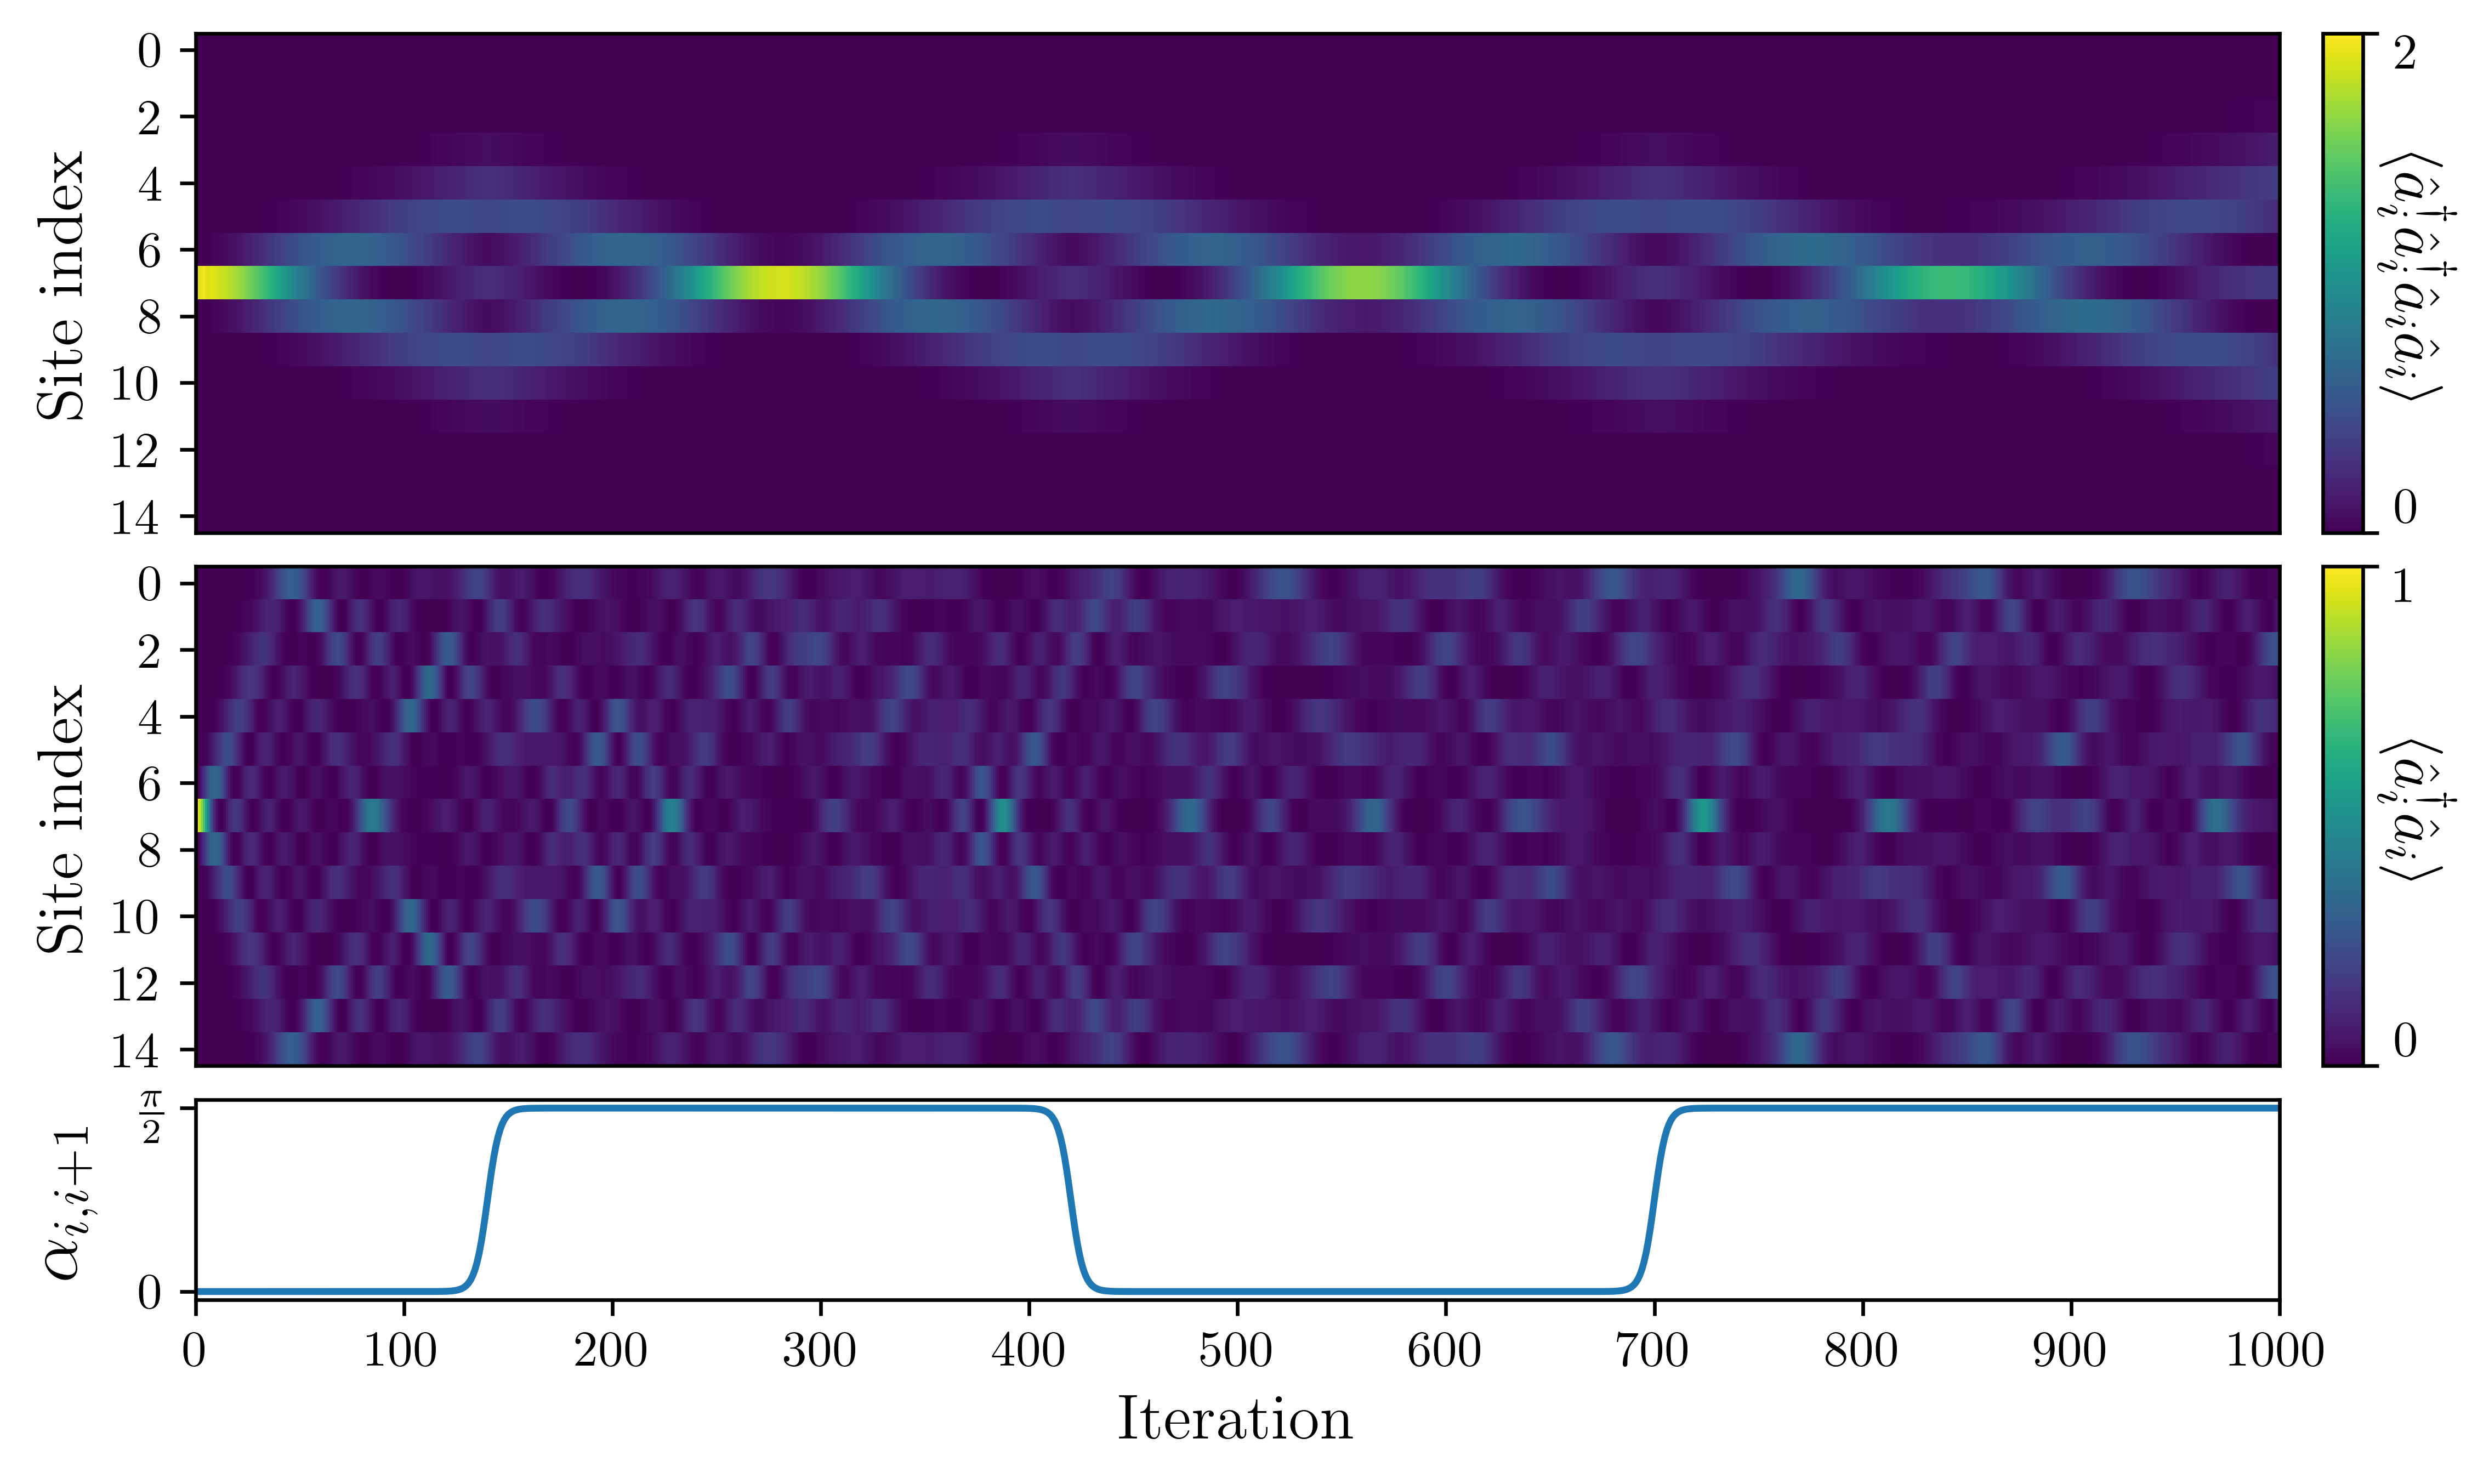

In [103]:
N = 2
D = 15
μ = 0.0
U = 0.8
κ = 0.1
t_ramp = 140
tmax = 1000
tstep = 1
t_list = np.arange(0, tmax, tstep)


fock_list_single = [0] * D
fock_list_single[D * 1 // 2] = 1

fock_list_double = [0] * D
fock_list_double[D * 1 // 2] = 2


A_min=0
A_max=5*np.pi/2
# for A in np.linspace(A_min, A_max, 100):
A = np.pi/2
# α = lambda t: 3*np.pi/2 * (1 / (1 + np.exp(-(t-t_ramp)/10)) ) # 0 if t < t_ramp else np.pi/2 * np.sin(2*np.pi*(t-t_ramp)/20)

α2 = lambda t: A * (1 / (1 + np.exp(-(t-t_ramp)/3)) ) 
α = lambda t: α2(t) - α2(t - 2 * t_ramp) + α2(t - 4 * t_ramp)
α_list = [α(t) for t in t_list] if type(α) is types.FunctionType else [α]*len(t_list)

# filename_single = simulate_1d_time_dependent_evolution_and_save(N=1, D=D, α=α, κ=κ, μ=μ, U=U, tmax=tmax, 
#                                           tstep=tstep, initial_state=fock_list_single, 
#                                           toroidal=False, use_ponomarev=True,
#                                           synthetic=False)
# print(filename_single)

# filename_double = simulate_1d_time_dependent_evolution_and_save(N=2, D=D, α=α, κ=κ, μ=μ, U=U, tmax=tmax, 
#                                           tstep=tstep, initial_state=fock_list_double, 
#                                           toroidal=False, use_ponomarev=True,
#                                           synthetic=False)
# print(filename_double)

filename_single = "results/1d_time_dependent_evolution_N=1_D=15_kappa=0.1_mu=0.0_U=0.8_alpha='func'_tmax=1000_toroidal=False_[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle"
filename_double = "results/1d_time_dependent_evolution_N=2_D=15_kappa=0.1_mu=0.0_U=0.8_alpha='func'_tmax=1000_toroidal=False_[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle"

with open(filename_single, "rb") as f:
    obj = pickle.load(f)
single_photon_expectations_over_time = obj["photon_expectations_over_time"]

with open(filename_double, "rb") as f:
    obj = pickle.load(f)
double_photon_expectations_over_time = obj["double_photon_expectations_over_time"]

plot_time_dependent_gauge(single_photon_expectations_over_time,
                          double_photon_expectations_over_time,
                          t_list, α_list,
                          alpha_range=[-.07, A+.07],
                          take_sqrt_of_amplitudes=False,
                          figscale = 8.5, savefig = False,
                          colormap='viridis',
                          figure_for_paper=True)

# savename = filename.replace("results/", "frames/").replace(".pickle", ".png")
savename = "frames/{}.png".format(str(int(A * 1e8)).zfill(10))
# plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
# plt.close()
# plt.savefig("lensing.png")




plt.savefig("lensing.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

Time-dependent evolution:   0%|          | 0/300 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 12.006714105606079s. Results saved to results/1d_time_dependent_evolution_N=2_D=15_kappa=0.1_mu=0_U=1.0_alpha='func'_tmax=300_toroidal=False_[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle


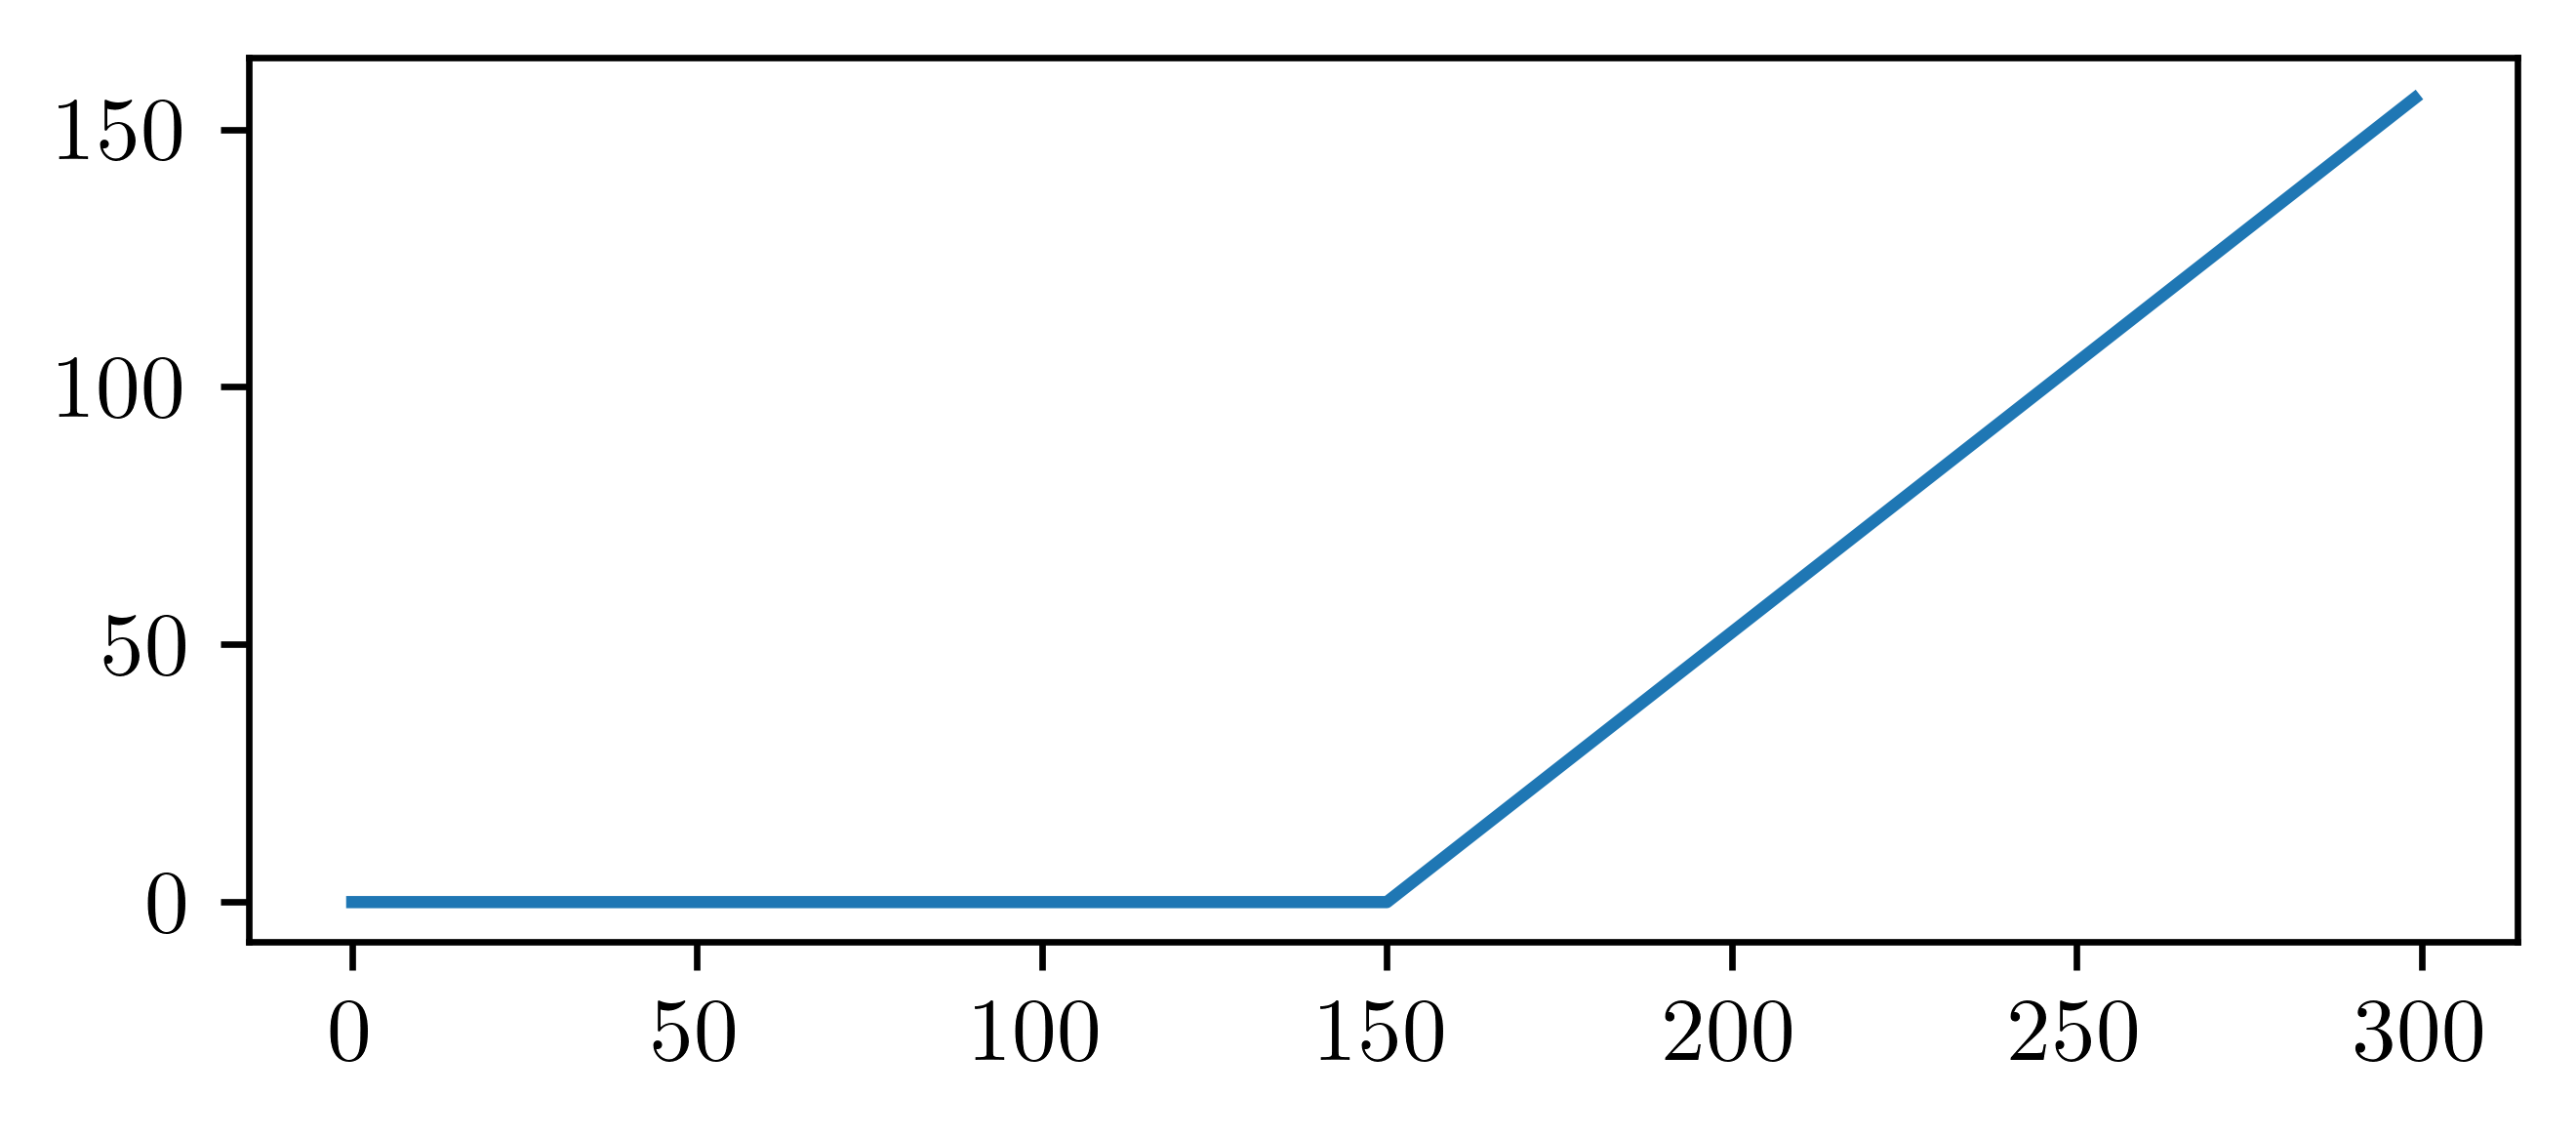

results/1d_time_dependent_evolution_N=2_D=15_kappa=0.1_mu=0_U=1.0_alpha='func'_tmax=300_toroidal=False_[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle


NameError: name 'plot_1d_state_evolution_from_file' is not defined

In [57]:
N = 2
D = 15
μ_list = 0.0 * np.arange(D)
U = 1.0
κ = 0.1
t_ramp = 150
tmax = 300
t_list = np.arange(0, tmax, tstep)

α = lambda t: 0.0 if t < t_ramp else np.pi/3 * (t-t_ramp)


tstep = 1
# state_type = "same_bin"

fock_list = [0] * D

fock_list[D * 1 // 2] = 2


filename = simulate_1d_time_dependent_evolution_and_save(N=N, D=D, α=α, κ=κ, μ=0, U=U, tmax=tmax, 
                                          tstep=tstep, initial_state=fock_list, 
                                          toroidal=False, use_ponomarev=True,
                                          include_two_photon_correlations=False,
                                          synthetic=False)

plt.figure(figsize=(5,2))
plt.plot(t_list, [α(t) for t in t_list])
plt.show()

print(filename)
plot_1d_state_evolution_from_file(filename, include_description=True, 
                                  photon_correlation_snapshots = None,
                                  include_two_photon_expectations=True,
                                  take_sqrt_of_amplitudes=False,
                                  savefig = False,
                                  colormap="viridis")
savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
# plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

Evolving states:   0%|          | 0/300 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/300 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 23.11716103553772s. Results saved to results/1d_time_dependent_evolution_N=2_D=15_kappa=0.1_mu=0_U=1.0_alpha=0_tmax=300_toroidal=False_[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle
results/1d_time_dependent_evolution_N=2_D=15_kappa=0.1_mu=0_U=1.0_alpha=0_tmax=300_toroidal=False_[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle


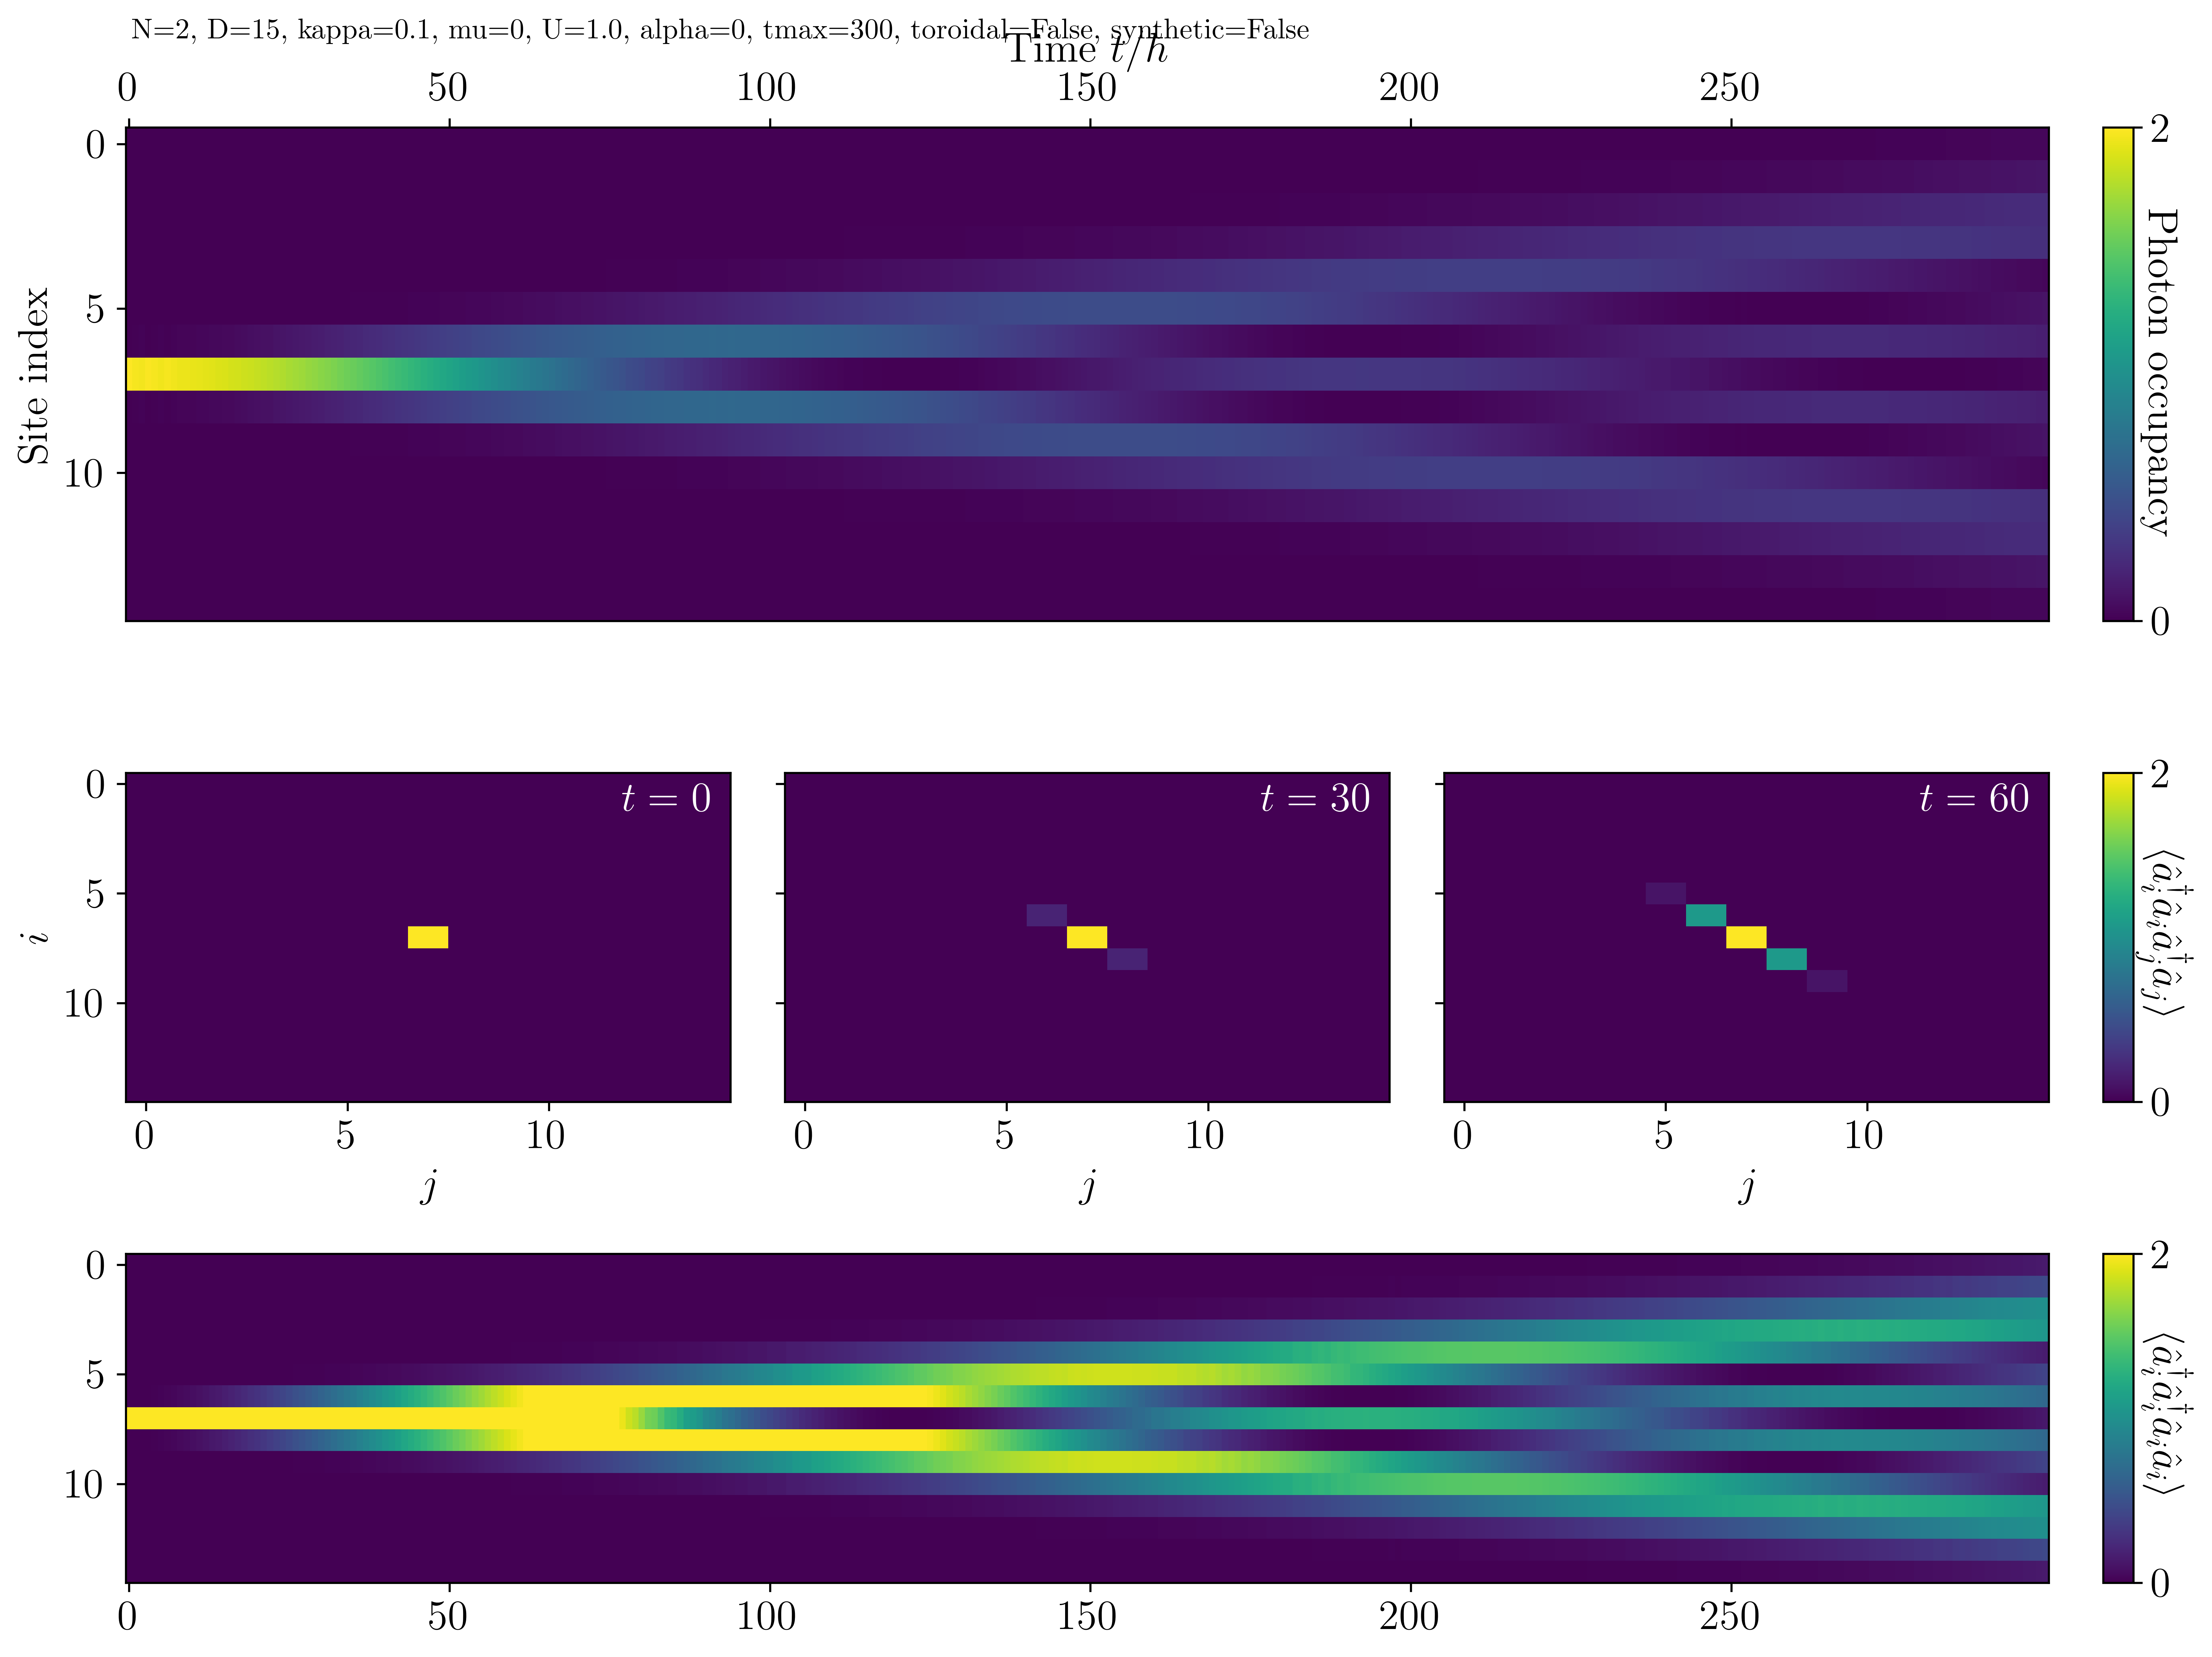

In [220]:
N = 2
D = 15
μ_list = 0.0 * np.arange(D)
U = 1.0
κ = 0.1
t_ramp = 150
tmax = 300
t_list = np.arange(0, tmax, tstep)

α = 0   #lambda t: 11*np.pi/2 * (1 / (1 + np.exp(-(t-t_ramp)/11)) )


tstep = 1
# state_type = "same_bin"

fock_list = [0] * D

fock_list[D * 1 // 2] = 2


filename = simulate_1d_time_dependent_evolution_and_save(N=N, D=D, α=α, κ=κ, μ=0, U=U, tmax=tmax, 
                                          tstep=tstep, initial_state=fock_list, 
                                          toroidal=False, use_ponomarev=True,
                                          synthetic=False)

# plt.figure(figsize=(5,2))
# plt.plot(t_list, [α(t) for t in t_list])
# plt.show()

print(filename)
plot_1d_state_evolution_from_file(filename, include_description=True, 
                                  photon_correlation_snapshots = [0, 30, 60],
                                  include_two_photon_expectations=True,
                                  take_sqrt_of_amplitudes=False,
                                  savefig = False,
                                  colormap="viridis")
savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
# plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Synthetic Hall ladder and bandstructure calculations

In [3]:
def compute_eigenvals_eigenkets_and_save(D, N, α, κ, μ, U, synthetic=False):
    
    if synthetic:

        G = construct_BHH_propagator_ladder(length = D//2, 
                                            hopping_phase = α,
                                            # hopping_phase_mode = "rung",
                                            hopping_phase_mode = "translation_invariant",
                                            circular = True,
                                            κ = κ,
                                            μ = μ,
                                            U = U,
                                            num_bosons = N,
                                            use_ponomarev=True,
                                            display_progress=True)


        minus_iHt = operator_log(G)
        H = minus_iHt / (-1j * 1)

        eigenvals, eigenkets = H.eigenstates()
        # Throw away vacuum state and superfluous final ponomarev index state
        eigenvals = eigenvals[1:-1]
        eigenkets = eigenkets[1:-1]
        
    else:

        H = BHH_ladder(length = D//2, 
                       hopping_phase = α,
                       # hopping_phase_mode = "rung",
                       hopping_phase_mode = "translation_invariant",
                       circular = True,
                       κ = κ,
                       μ = μ,
                       U = U,
                       num_bosons = N,
                       use_ponomarev=True,
                       display_progress=True)

        eigenvals, eigenkets = H.eigenstates()
        # Throw away vacuum state and superfluous final ponomarev index state
        eigenvals = eigenvals[1:-1]
        eigenkets = eigenkets[1:-1]

    # Save as pickled object
    kappa = κ
    mu = μ
    alpha = α
    filename = f"results/eigenvals_eigenkets_{N=}_{D=}_{kappa=}_{alpha=}_{mu=}_{U=}_{synthetic=}_results.pickle"
    obj = {
        "eigenvals": eigenvals,
        "eigenkets": eigenkets,
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Eigenstates saved to {filename}")
    
    return eigenvals, eigenkets
    
def load_eigenvals_eigenkets(filename):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    eigenvals = obj["eigenvals"]
    eigenkets = obj["eigenkets"]
    
    return eigenvals, eigenkets

In [4]:
D = 1000
N = 1
α = 2 * np.pi / 3 
κ = 0.1
μ = 0.0
U = 0.0

# eigenvals, eigenkets = compute_eigenvals_eigenkets_and_save(D, N, α, κ, μ, U, synthetic=True)

In [7]:
# Numerically find the value of k for each of the eigenstates
def find_k_for_eigenket(eigenket):
    ket = eigenket.full().flatten()#[1:-1].flatten() # discard vacuum state and superfluous ponomarev index
    
    # ket_even = ket[ : len(ket) // 2]
    # ket_odd = ket[len(ket) // 2 : ]
    
    ket_even = ket[0 : : 2]
    ket_odd = ket[1 : : 2]
    
    freq = np.fft.fftfreq(ket.shape[0])
    freq_even = np.fft.fftfreq(ket_even.shape[0])
    freq_odd = np.fft.fftfreq(ket_odd.shape[0])
    
    max_k = freq[np.argmax(np.abs(np.fft.fft(ket)))]
    max_k_even = freq_even[np.argmax(np.abs(np.fft.fft(ket_even)))]
    max_k_odd = freq_odd[np.argmax(np.abs(np.fft.fft(ket_odd)))]
    # if np.abs(max_k_even) != np.abs(max_k_odd):
    #     raise RuntimeError("huh?")

    # This heuristic actually seems to work very well
    if np.sum(np.abs(ket_even)**2) > np.sum(np.abs(ket_odd)**2):
        return max_k_even
    else:
        return max_k_odd
    # return np.abs(max_k)

def find_even_odd_projection(eigenket):
    ket = eigenket.full().flatten()#[1:-1].flatten()
    ket_even = ket[0 : : 2]
    ket_odd = ket[1 : : 2]
    return np.sum(np.abs(ket_even)**2), np.sum(np.abs(ket_odd)**2)

In [8]:
def convert_scatter_to_line_and_prune_data(k_vals, eigenvals, projections, α=None,
                                           prune_data=True, divide_bands=False, smooth_projections=False, window_size = 5):
    '''
    Converts the two-banded data which would be used as a scatter plot into
    a pair of line plot data. Additionally, removes a few errant points near D//2 
    which don't play nicely with the numerical k-finding approach.
    '''
    
    # First prune errant points
    k_vals_pruned = np.copy(k_vals)
    eigenvals_pruned = np.copy(eigenvals)
    projections_pruned = np.copy(projections)
    
    indices_to_prune = []
    if prune_data:
        # Prune a few outlying points which don't get assigned accurate k values because their
        # Fourier transform doesn't have two obvious peaks
        for i, (k, E, proj) in enumerate(zip(k_vals, eigenvals, projections)):
            if α == 0:
                prune = (np.abs(E) < 5e-3 and np.abs(k) < 0.25 or np.abs(E) < 1e-2 and k > 0.75)
            else:
                prune = (np.abs(E) < 5e-3 and 0.05 < np.abs(k) < 0.9)
            if prune:
                indices_to_prune.append(i)
        if len(indices_to_prune) > 0.1 * len(eigenvals):
            raise RuntimeError(f"Probably pruning too many points! {len(indices_to_prune)}")
        
    k_vals_pruned = np.delete(k_vals_pruned, indices_to_prune)
    eigenvals_pruned = np.delete(eigenvals_pruned, indices_to_prune)
    projections_pruned = np.delete(projections_pruned, indices_to_prune, axis=0)
    
#     if divide_bands is False:
#         # Sort by a heuristic here which will order the top band from left to right then
#         # the botton band from left to right
#         sorter = k_vals_pruned
        
#         k_vals_argsort = np.argsort(k_vals_pruned)
#         k_vals_sorted = k_vals_pruned[k_vals_argsort]
#         eigenvals_sorted = eigenvals_pruned[k_vals_argsort]
#         projections_sorted = projections_pruned[k_vals_argsort]
        
#         return k_vals_sorted, eigenvals_sorted, projections_sorted
        
#     else:
    k_vals_lower = []
    k_vals_upper = []
    eigenvals_lower = []
    eigenvals_upper = []
    projections_lower = []
    projections_upper = []

    # Second divide into two line plots
    for i, (k, E, proj) in enumerate(zip(k_vals_pruned, eigenvals_pruned, projections_pruned)):
        # dividing line is .2 |k| - .1
        if E >= 0.2 * np.abs(k) - 0.1:
            k_vals_upper.append(k)
            eigenvals_upper.append(E)
            projections_upper.append(proj)
        else:
            k_vals_lower.append(k)
            eigenvals_lower.append(E)
            projections_lower.append(proj)

    k_vals_lower = np.array(k_vals_lower)
    k_vals_upper = np.array(k_vals_upper)
    eigenvals_lower = np.array(eigenvals_lower)
    eigenvals_upper = np.array(eigenvals_upper)
    projections_lower = np.array(projections_lower)
    projections_upper = np.array(projections_upper)
    projections_lower_all = projections_lower[:,0] - projections_lower[:,1]
    projections_upper_all = projections_upper[:,0] - projections_upper[:,1]

    # Finally, sort by k value 
    argsorted = np.argsort(k_vals_lower)
    # argsorted = np.argsort(np.abs(projections_lower_all))
    k_vals_lower = k_vals_lower[argsorted]
    eigenvals_lower = eigenvals_lower[argsorted]
    projections_lower = projections_lower[argsorted]

    argsorted = np.argsort(k_vals_upper)
    # argsorted = np.argsort(np.abs(projections_upper_all))
    k_vals_upper = k_vals_upper[argsorted]
    eigenvals_upper = eigenvals_upper[argsorted]
    projections_upper = projections_upper[argsorted]
    
    if smooth_projections:
        def movingaverage(data, window_size):
            window = np.ones(int(window_size))/float(window_size)
            return np.convolve(data, window, 'same')
        projections_upper = np.transpose(projections_upper)
        projections_lower = np.transpose(projections_lower)
        projections_upper[0] = movingaverage(projections_upper[0], window_size)
        projections_upper[1] = movingaverage(projections_upper[1], window_size)
        projections_lower[0] = movingaverage(projections_lower[0], window_size)
        projections_lower[1] = movingaverage(projections_lower[1], window_size)
        projections_upper = np.transpose(projections_upper)
        projections_lower = np.transpose(projections_lower)

    if divide_bands:
        return k_vals_lower, eigenvals_lower, projections_lower, k_vals_upper, eigenvals_upper, projections_upper
    
    else:
        k_vals_sorted = np.concatenate((k_vals_lower, k_vals_upper))
        eigenvals_sorted = np.concatenate((eigenvals_lower, eigenvals_upper))
        projections_sorted = np.concatenate((projections_lower, projections_upper))
        return k_vals_sorted, eigenvals_sorted, projections_sorted

In [9]:
D=2000
prune_data = False

In [10]:
eigenvals_no_gauge, eigenkets_no_gauge = load_eigenvals_eigenkets("results/eigenvals_eigenkets_N=1_D=2000_kappa=0.1_alpha=0.0_mu=0.0_U=0.0_results.pickle")

k_vals_no_gauge, eigenvals_no_gauge, projections_no_gauge = convert_scatter_to_line_and_prune_data(
    k_vals=np.array([find_k_for_eigenket(eigenket) for eigenket in eigenkets_no_gauge]) * 2, 
    eigenvals=eigenvals_no_gauge, 
    projections=np.array([find_even_odd_projection(eigenket) for eigenket in eigenkets_no_gauge]), 
    α=0,
    prune_data=prune_data,
    divide_bands=False, 
    smooth_projections=False, window_size = int(D/200))
even_proj_no_gauge, odd_proj_no_gauge = np.transpose(projections_no_gauge)

In [11]:
eigenvals_gauge, eigenkets_gauge = load_eigenvals_eigenkets("results/eigenvals_eigenkets_N=1_D=2000_kappa=0.1_alpha=-2.0943951023931953_mu=0.0_U=0.0_results.pickle")

k_vals_gauge, eigenvals_gauge, projections_gauge = convert_scatter_to_line_and_prune_data(
    k_vals=np.array([find_k_for_eigenket(eigenket) for eigenket in eigenkets_gauge]) * 2, 
    eigenvals=eigenvals_gauge, 
    projections=np.array([find_even_odd_projection(eigenket) for eigenket in eigenkets_gauge]), 
    α=2 * np.pi / 3 ,
    prune_data=prune_data,
    divide_bands=False, 
    smooth_projections=False, window_size = int(D/200))
even_proj_gauge, odd_proj_gauge = np.transpose(projections_gauge)

In [12]:
D=1000

In [13]:
eigenvals_no_gauge_synthetic, eigenkets_no_gauge_synthetic = load_eigenvals_eigenkets("results/eigenvals_eigenkets_N=1_D=1000_kappa=0.1_alpha=0.0_mu=0.0_U=0.0_synthetic=True_results.pickle")

k_vals_no_gauge_synthetic, eigenvals_no_gauge_synthetic, projections_no_gauge_synthetic = convert_scatter_to_line_and_prune_data(
    k_vals=np.array([find_k_for_eigenket(eigenket) for eigenket in eigenkets_no_gauge_synthetic]) * 2, 
    eigenvals=eigenvals_no_gauge_synthetic, 
    projections=np.array([find_even_odd_projection(eigenket) for eigenket in eigenkets_no_gauge_synthetic]), 
    α=0,
    prune_data=prune_data,
    divide_bands=False, 
    smooth_projections=False, window_size = int(D/200))
even_proj_no_gauge_synthetic, odd_proj_no_gauge_synthetic = np.transpose(projections_no_gauge_synthetic)

In [14]:
eigenvals_gauge_synthetic, eigenkets_gauge_synthetic = load_eigenvals_eigenkets("results/eigenvals_eigenkets_N=1_D=1000_kappa=0.1_alpha=2.0943951023931953_mu=0.0_U=0.0_synthetic=True_results.pickle")

k_vals_gauge_synthetic, eigenvals_gauge_synthetic, projections_gauge_synthetic = convert_scatter_to_line_and_prune_data(
    k_vals=np.array([find_k_for_eigenket(eigenket) for eigenket in eigenkets_gauge_synthetic]) * 2, 
    eigenvals=eigenvals_gauge_synthetic, 
    projections=np.array([find_even_odd_projection(eigenket) for eigenket in eigenkets_gauge_synthetic]), 
    α=2 * np.pi / 3 ,
    prune_data=prune_data,
    divide_bands=False, 
    smooth_projections=False, window_size = int(D/200))
even_proj_gauge_synthetic, odd_proj_gauge_synthetic = np.transpose(projections_gauge_synthetic)

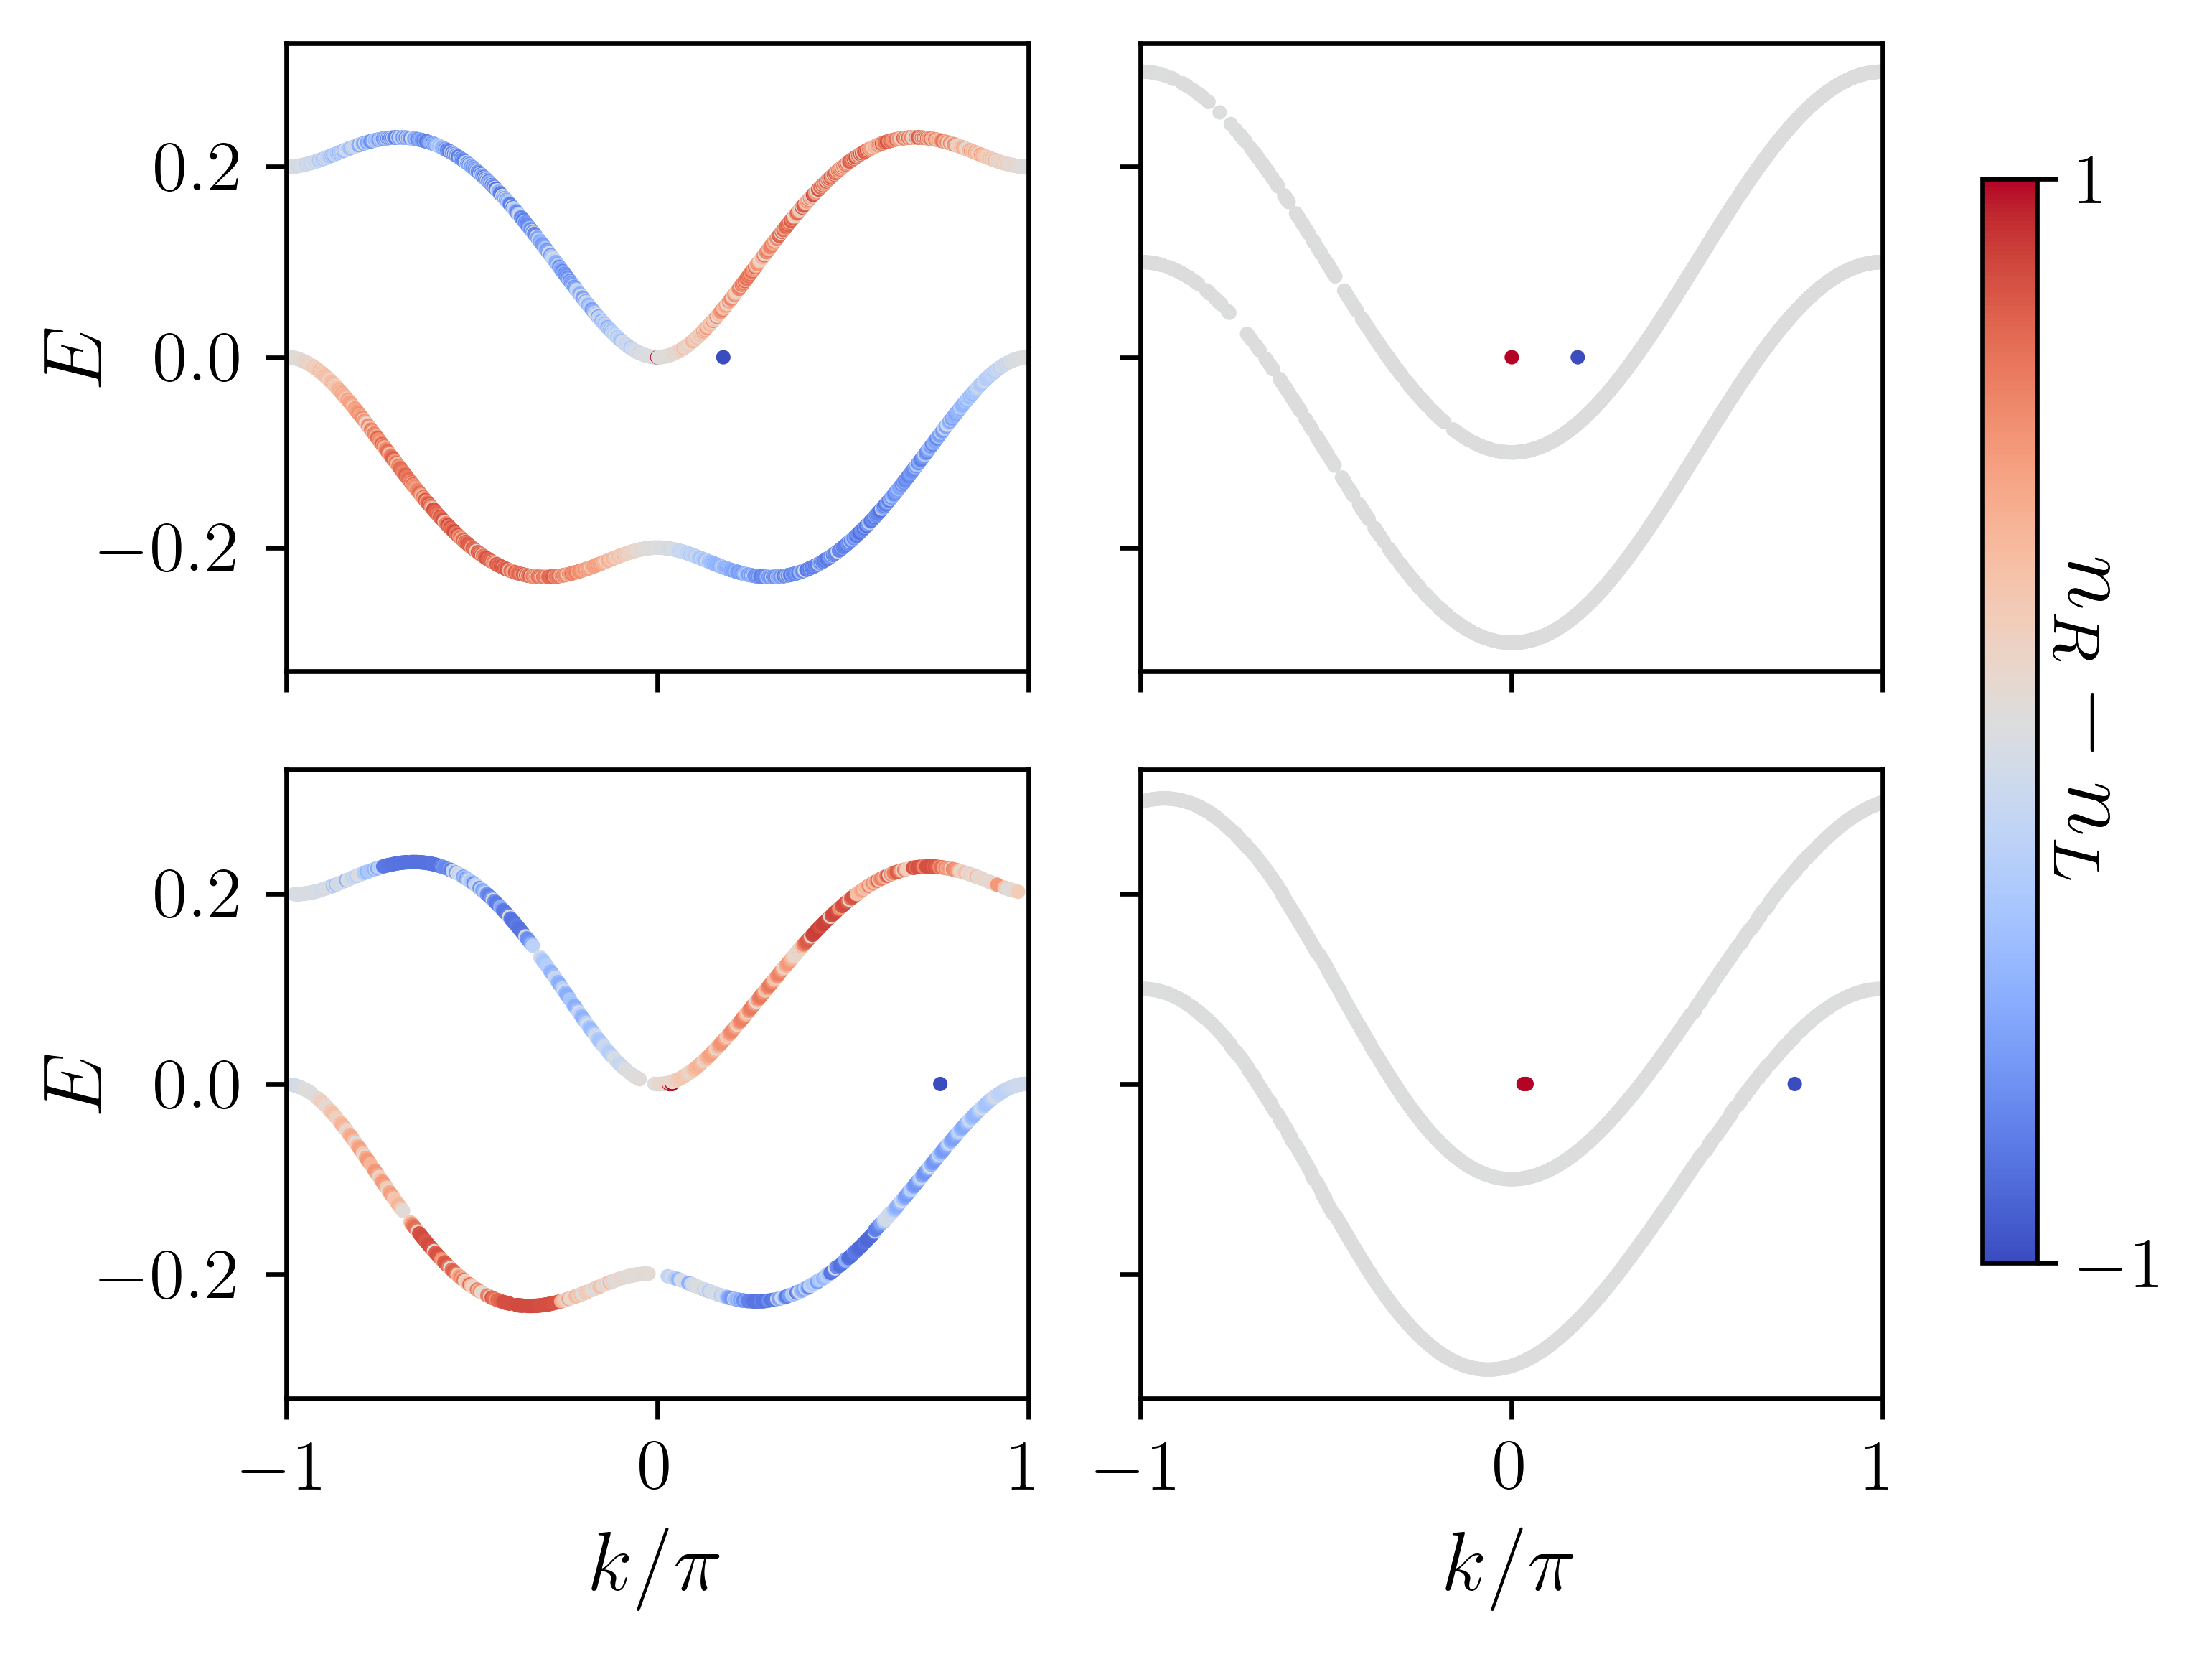

In [15]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

scale=.8

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7*scale,5*scale))

for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
    ax.set_xlim([-1, 1])
    ax.set_xticks([-1, 0, 1])
    
for ax in [axs[0,0], axs[1,0]]:
    ax.set_ylabel('$E$', fontsize=14, labelpad=-3)
for ax in [axs[1,0], axs[1,1]]:
    ax.set_xlabel('$k / \\pi$', fontsize=14)
    # ax.set_xticks([-1,0,1])
    # ax.set_xticklabels(["$-\\pi$", "$0$", "$\\pi$"])

# axs[0,0].text(.1, .9, "$\\alpha = 2 \\pi / 3$", transform=ax[0,0].transAxes)
    
s = 2
alpha = 1.0
cmap = "coolwarm"
cmin = -1
cmax = 1

sc1 = axs[0,1].scatter(k_vals_no_gauge, eigenvals_no_gauge, s=s, c=even_proj_no_gauge - odd_proj_no_gauge, cmap=cmap, alpha=alpha)
sc1.set_clim(cmin, cmax)

sc2 = axs[0,0].scatter(k_vals_gauge, eigenvals_gauge, s=s, c=even_proj_gauge - odd_proj_gauge, cmap=cmap, alpha=alpha)
sc2.set_clim(cmin, cmax)

sc3 = axs[1,1].scatter(k_vals_no_gauge_synthetic, eigenvals_no_gauge_synthetic, s=s, c=even_proj_no_gauge_synthetic - odd_proj_no_gauge_synthetic, cmap=cmap, alpha=alpha)
sc3.set_clim(cmin, cmax)

sc4 = axs[1,0].scatter(k_vals_gauge_synthetic, eigenvals_gauge_synthetic, s=s, c=even_proj_gauge_synthetic - odd_proj_gauge_synthetic, cmap=cmap, alpha=alpha)
sc4.set_clim(cmin, cmax)

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(sc1, cax=cbar_ax)




# fig.colorbar(sc1, ax=axs[0,0], fraction=0.1, shrink=.7)

# sc2 = ax2.scatter(k_vals, eigenvals, s=5, c=odd_proj, cmap="Blues")
# sc2.set_clim(0.1, 0.9)
# cb2 = plt.colorbar(sc2, ax=ax2, fraction=0.1, shrink=.7)

# sc3 = ax3.scatter(k_vals, eigenvals, s=5, c=even_proj, cmap="Reds")
# sc3.set_clim(0.1, 0.9)
# cb3 = plt.colorbar(sc3, ax=ax3, fraction=0.1, shrink=.7)


fig.tight_layout()

cbar = plt.colorbar(sc1, ax=[axs[0,0], axs[0,1], axs[1,0], axs[1,1]], 
                    ticks=[cmin, cmax],
                    orientation='vertical', shrink=0.8)
cbar.set_label("$n_R - n_L$", rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=-6


# plt.savefig("assets/band_structure_comparison.pdf", dpi=300)

plt.show()

In [125]:
k_vals, eigenvals, projections = k_vals_gauge_synthetic, eigenvals_gauge_synthetic, projections_gauge_synthetic

# First prune errant points
k_vals_pruned = np.copy(k_vals)
eigenvals_pruned = np.copy(eigenvals)
projections_pruned = np.copy(projections)

indices_to_prune = []
if True:
    # Prune a few outlying points which don't get assigned accurate k values because their
    # Fourier transform doesn't have two obvious peaks
    for i, (k, E, proj) in enumerate(zip(k_vals, eigenvals, projections)):
        if α == 0:
            prune = (np.abs(E) < 5e-3 and np.abs(k) < 0.25 or np.abs(E) < 1e-2 and k > 0.75)
        else:
            prune = (np.abs(E) < 5e-3 and 0.05 < np.abs(k) < 0.9)
        if prune:
            indices_to_prune.append(i)
print(indices_to_prune)

[431, 758, 759, 760]


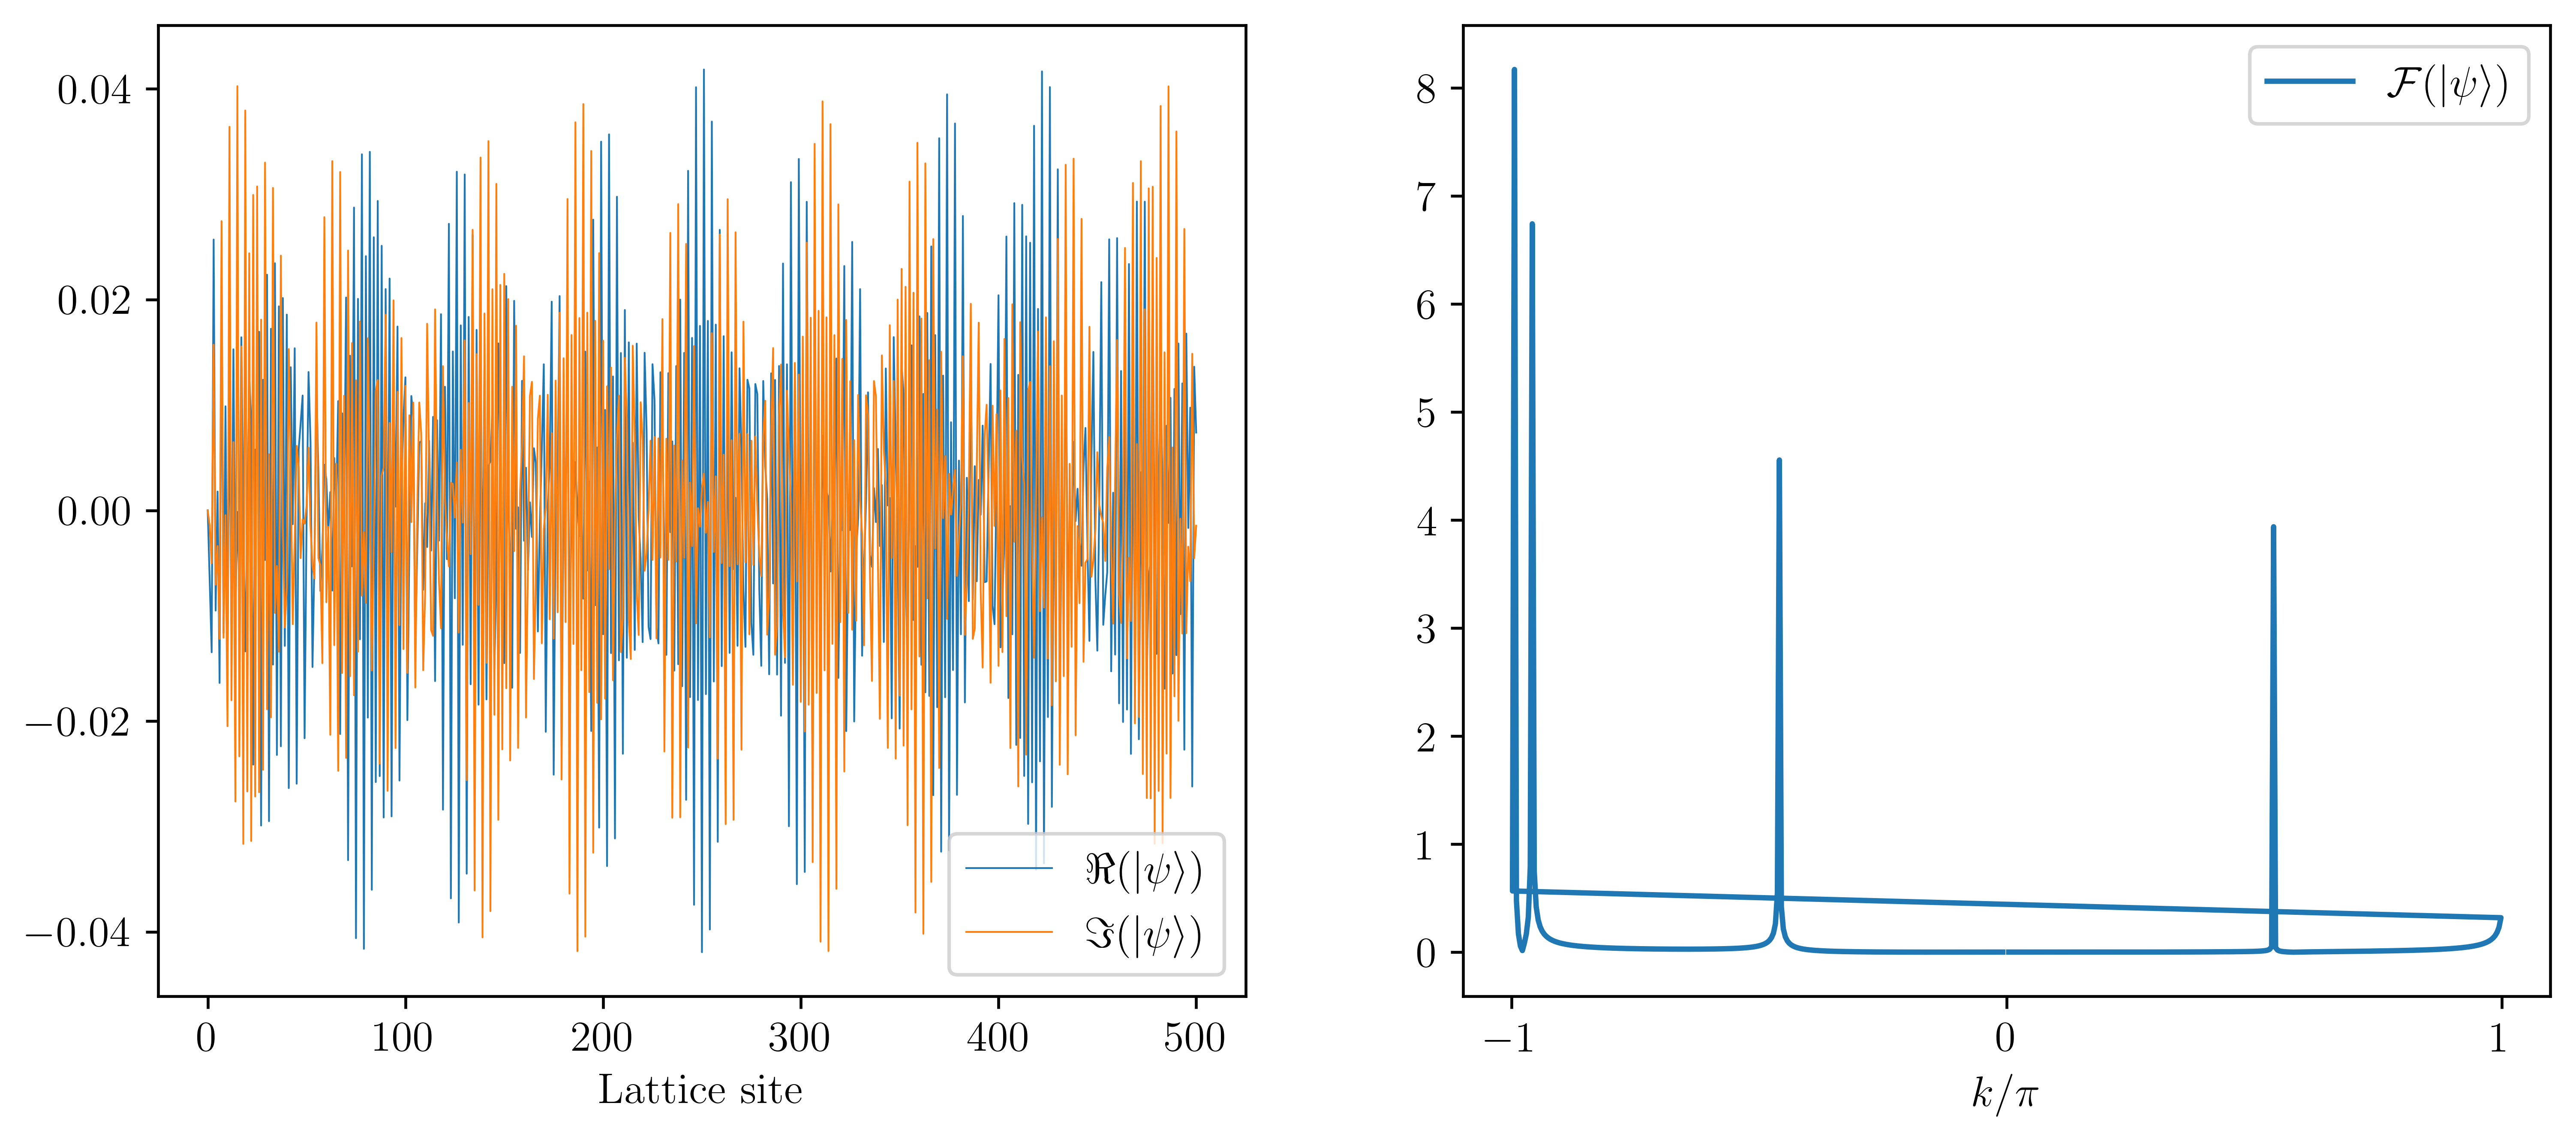

In [130]:
# eigenvals_gauge, eigenkets_gauge

num = 760
ket = eigenkets_gauge_synthetic[num].full()[1:-1].flatten()
# ket = ket[0 : len(ket)//2]
ket = ket[0 : : 2]
fft = np.fft.fft(ket)
freq = np.fft.fftfreq(ket.shape[0])#, d=1/(2*np.pi))

ket.shape

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(1*12,1*5))

ax1.plot(ket.real, label="$\\Re (\\left | \\psi \\right >)$", lw=.5)
ax1.plot(ket.imag, label="$\\Im (\\left | \\psi \\right >)$", lw=.5)
ax1.legend()
ax1.set_xlabel('Lattice site')
# ax1.set_ylim([-1e-5, 1e-5])

fft = np.fft.fft(ket)
freq = 2 * np.fft.fftfreq(ket.shape[0])#, d=1/(np.pi))
ax2.plot(freq[1:-1], np.abs(fft)[1:-1], label="$\\mathcal{F} (\\left | \\psi \\right >)$")
ax2.legend()

ax2.set_xticks([-1, 0, 1])
ax2.set_xlabel('$k / \\pi$')



plt.savefig(f"assets/fft_{num}.pdf")
plt.show()

## Hamiltonian to bandstructure conversion

In [42]:
D = 300
N = 1
α = 0*2 * np.pi / 3 
κ = 0.01
μ = 0.0
U = 0.0

G = construct_BHH_propagator_ladder(length = D//2, 
                                   hopping_phase = α,
                                   # hopping_phase_mode = "rung",
                                   hopping_phase_mode = "translation_invariant",
                                   circular = True,
                                   κ = κ,
                                   μ = μ,
                                   U = U,
                                   num_bosons = N,
                                   use_ponomarev=True,
                                   display_progress=True)


minus_iHt = operator_log(G)
H = minus_iHt / (-1j * 1)

eigenvals, eigenkets = H.eigenstates()
# Throw away vacuum state and superfluous final ponomarev index state
eigenvals = eigenvals[1:-1]
eigenkets = eigenkets[1:-1]

  0%|          | 0/450 [00:00<?, ?it/s]

In [43]:
minus_iHt = operator_log(G)
H = minus_iHt / (-1j * 1)

eigenvals, eigenkets = H.eigenstates()
# Throw away vacuum state and superfluous final ponomarev index state
eigenvals = eigenvals[1:-1]
eigenkets = eigenkets[1:-1]

In [44]:
k_vals = np.array([find_k_for_eigenket(eigenket) for eigenket in eigenkets]) * 2
projections = np.array([find_even_odd_projection(eigenket) for eigenket in eigenkets])
even_proj, odd_proj = np.transpose(projections)

k_vals, eigenvals, projections = convert_scatter_to_line_and_prune_data(
    k_vals, eigenvals, projections, 
    prune_data=False, divide_bands=False, 
    smooth_projections=False, window_size = int(D/200))
even_proj, odd_proj = np.transpose(projections)


In [19]:
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, sharex=True, figsize=(5,7))

for ax in [ax1, ax2, ax3]:
    ax.set_xlim([-1, 1])
    ax.set_xticks([-1, 0, 1])
    ax.set_ylabel('$E$')
    # ax.grid(True)


sc1 = ax1.scatter(k_vals, eigenvals, s=5, c=even_proj - odd_proj, cmap="bwr", alpha=1.0)
sc1.set_clim(-0.9, 0.9)
cb1 = plt.colorbar(sc1, ax=ax1, fraction=0.1, shrink=.7)

sc2 = ax2.scatter(k_vals, eigenvals, s=5, c=odd_proj, cmap="Blues")
sc2.set_clim(0.1, 0.9)
cb2 = plt.colorbar(sc2, ax=ax2, fraction=0.1, shrink=.7)

sc3 = ax3.scatter(k_vals, eigenvals, s=5, c=even_proj, cmap="Reds")
sc3.set_clim(0.1, 0.9)
cb3 = plt.colorbar(sc3, ax=ax3, fraction=0.1, shrink=.7)


fig.tight_layout()
# plt.savefig("assets/band_structure_phi_0.0pi_simulated.pdf")
plt.show()

## Experimentally signatures: chiral edge currents

In [104]:
def create_single_photon_gaussian_input_state(num_sites, k=0.0, stddev=None, parity=None, synthetic=True):
    '''Creates a "gaussian" input state in time bin occupancy basis.'''
    if synthetic: 
        D = num_sites + 1
    else:
        D = num_sites
        
    # Compute all basis states in ponomarev representation
    basis_states = []
    for i in range(num_sites):
        fock_list = [0] * D
        fock_list[i] = 1
        basis_states.append(qt_fock_to_ponomarev(fock_list, N, D))
    
    # Create a gaussian superposition of those states
    if parity == "even":
        sites = np.arange(num_sites)[0::2]
    elif parity == "odd":
        sites = np.arange(num_sites)[1::2]
    else:
        sites = np.arange(num_sites)
    if stddev is None: stddev = len(sites) / 10
    amplitudes = signal.windows.gaussian(len(sites), stddev)
    amplitudes = amplitudes / np.linalg.norm(amplitudes)
    phases = k * sites
    
    output_state = sum(A * np.exp(1j*ϕ) * basis_states[i] for (A, ϕ, i) in zip(amplitudes, phases, sites))
    return output_state
    

def compute_gaussian_propagation_and_save(D, N, α, κ, μ, U, tmax=200, tstep=1, k=0.0, parity=None, synthetic=False, G_or_H=None):
        
    state_initial = create_single_photon_gaussian_input_state(D, k=k, parity=parity, synthetic=synthetic)
       
    photon_expectations_over_time = []
    states_over_time = []
    
    if synthetic:
        if G_or_H is not None:
            G = G_or_H
        else:
            G = construct_BHH_propagator_ladder(length = D//2, 
                                                hopping_phase = α,
                                                # hopping_phase_mode = "rung",
                                                hopping_phase_mode = "translation_invariant",
                                                circular = True,
                                                κ = κ,
                                                μ = μ,
                                                U = U,
                                                num_bosons = N,
                                                use_ponomarev=True,
                                                display_progress=True)
        
        for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
            state_evolved = (G ** t) * state_initial
            states_over_time.append(state_evolved)
        
    else:
        if G_or_H is not None:
            H = G_or_H
        else:
            H = BHH_ladder(length = D//2, 
                           hopping_phase = α,
                           # hopping_phase_mode = "rung",
                           hopping_phase_mode = "translation_invariant",
                           circular = True,
                           κ = κ,
                           μ = μ,
                           U = U,
                           num_bosons = N,
                           use_ponomarev=True,
                           display_progress=True)
        
        for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
            state_evolved = (-1j * H * t).expm() * state_initial
            states_over_time.append(state_evolved)

    
#     two_photon_correlations_over_time = [get_two_photon_correlations(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)
#                                          for state in tqdm(states_over_time, desc="Computing 2-photon correlations")]
    photon_expectations_over_time = [np.array(get_photon_occupancies(state, num_sites=(D+1 if synthetic else D), num_bosons=N, use_ponomarev=True)) 
                                     for state in states_over_time]
    # double_photon_expectations_over_time = [np.array(get_double_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
    #                                         for state in states_over_time]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    filename = f"results/gaussian_propagation_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{tmax=}_{k=}_{parity=}_{synthetic=}_results.pickle"
    obj = {
        "state_initial": state_initial,
        # "H": H,
        "states_over_time": states_over_time,
        "photon_expectations_over_time": photon_expectations_over_time,
        # "double_photon_expectations_over_time": double_photon_expectations_over_time,
        # "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Results saved to {filename}")
    
    return state_initial, states_over_time, photon_expectations_over_time
    
    
def load_gaussian_propagation(filename):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    state_initial = obj["state_initial"]
    states_over_time = obj["states_over_time"]
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    
    return state_initial, states_over_time, photon_expectations_over_time

In [379]:
D = 200
N = 1
α = 2 * np.pi / 3 
κ = 0.01
μ = 0.0
U = 0.0

tmax=1500 * 1
tstep=30 * 1

# k_list = np.pi * (np.array([-.5, -.25, -.1, .1, .25, .5]) + .05)
k_list = np.pi * (np.array([-0.1, 0.1]))
parity="even"


# Cached
re_eval = True
if re_eval:
    G = construct_BHH_propagator_ladder(length = D//2, 
                                        hopping_phase = α,
                                        # hopping_phase_mode = "rung",
                                        hopping_phase_mode = "translation_invariant",
                                        circular = True,
                                        κ = κ,
                                        μ = μ,
                                        U = U,
                                        num_bosons = N,
                                        use_ponomarev=True,
                                        display_progress=True)
    G_α0 = construct_BHH_propagator_ladder(length = D//2, 
                                        hopping_phase = 0.0,
                                        # hopping_phase_mode = "rung",
                                        hopping_phase_mode = "translation_invariant",
                                        circular = True,
                                        κ = κ,
                                        μ = μ,
                                        U = U,
                                        num_bosons = N,
                                        use_ponomarev=True,
                                        display_progress=True)
# H = BHH_ladder(length = D//2, 
#                hopping_phase = α,
#                # hopping_phase_mode = "rung",
#                hopping_phase_mode = "translation_invariant",
#                circular = True,
#                κ = κ,
#                μ = μ,
#                U = U,
#                num_bosons = N,
#                use_ponomarev=True,
#                display_progress=True)

# state_initial_all = []
# states_over_time_all = []
# photon_expectations_over_time_all = []

# for k in k_list:
#     # state_initial, states_over_time, photon_expectations_over_time = compute_gaussian_propagation_and_save(D, N, α, κ, μ, U, tmax=tmax, tstep=tstep, 
#     #                                                                                                        k=k, parity=parity, synthetic=True, G_or_H = G)
#     # state_initial, states_over_time, photon_expectations_over_time = compute_gaussian_propagation_and_save(D, N, α, κ, μ, U, tmax=tmax, tstep=tstep, 
#     #                                                                                                        k=k, parity=parity, synthetic=False, G_or_H = H)
#     state_initial_all.append(state_initial)
#     states_over_time_all.append(states_over_time)
#     photon_expectations_over_time_all.append(photon_expectations_over_time)
    
state_initial_all = []
states_over_time_all = []
photon_expectations_over_time_all = []

for k in k_list:
    state_initial, states_over_time, photon_expectations_over_time = compute_gaussian_propagation_and_save(D, N, α=α, κ=κ, μ=μ, U=U, tmax=tmax, tstep=tstep, 
                                                                                                           k=k, parity=parity, synthetic=True, G_or_H = G)
    state_initial_all.append(state_initial)
    states_over_time_all.append(states_over_time)
    photon_expectations_over_time_all.append(photon_expectations_over_time)

state_initial_all_α0 = []
states_over_time_all_α0 = []
photon_expectations_over_time_all_α0 = []

for k in k_list:
    state_initial, states_over_time, photon_expectations_over_time = compute_gaussian_propagation_and_save(D, N, α=0.0, κ=κ, μ=μ, U=U, tmax=tmax, tstep=tstep, 
                                                                                                           k=k, parity=parity, synthetic=True, G_or_H = G_α0)
    state_initial_all_α0.append(state_initial)
    states_over_time_all_α0.append(states_over_time)
    photon_expectations_over_time_all_α0.append(photon_expectations_over_time)
    
if parity == "even":
    sites = np.arange(D)[0::2]
elif parity == "odd":
    sites = np.arange(D)[1::2]
else:
    sites = np.arange(D)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Evolving states:   0%|          | 0/50 [00:00<?, ?it/s]

Results saved to results/gaussian_propagation_N=1_D=200_kappa=0.01_mu=0.0_U=0.0_tmax=1500_k=-0.3141592653589793_parity='even'_synthetic=True_results.pickle


Evolving states:   0%|          | 0/50 [00:00<?, ?it/s]

Results saved to results/gaussian_propagation_N=1_D=200_kappa=0.01_mu=0.0_U=0.0_tmax=1500_k=0.3141592653589793_parity='even'_synthetic=True_results.pickle


Evolving states:   0%|          | 0/50 [00:00<?, ?it/s]

Results saved to results/gaussian_propagation_N=1_D=200_kappa=0.01_mu=0.0_U=0.0_tmax=1500_k=-0.3141592653589793_parity='even'_synthetic=True_results.pickle


Evolving states:   0%|          | 0/50 [00:00<?, ?it/s]

Results saved to results/gaussian_propagation_N=1_D=200_kappa=0.01_mu=0.0_U=0.0_tmax=1500_k=0.3141592653589793_parity='even'_synthetic=True_results.pickle


### Figure 2c generation code

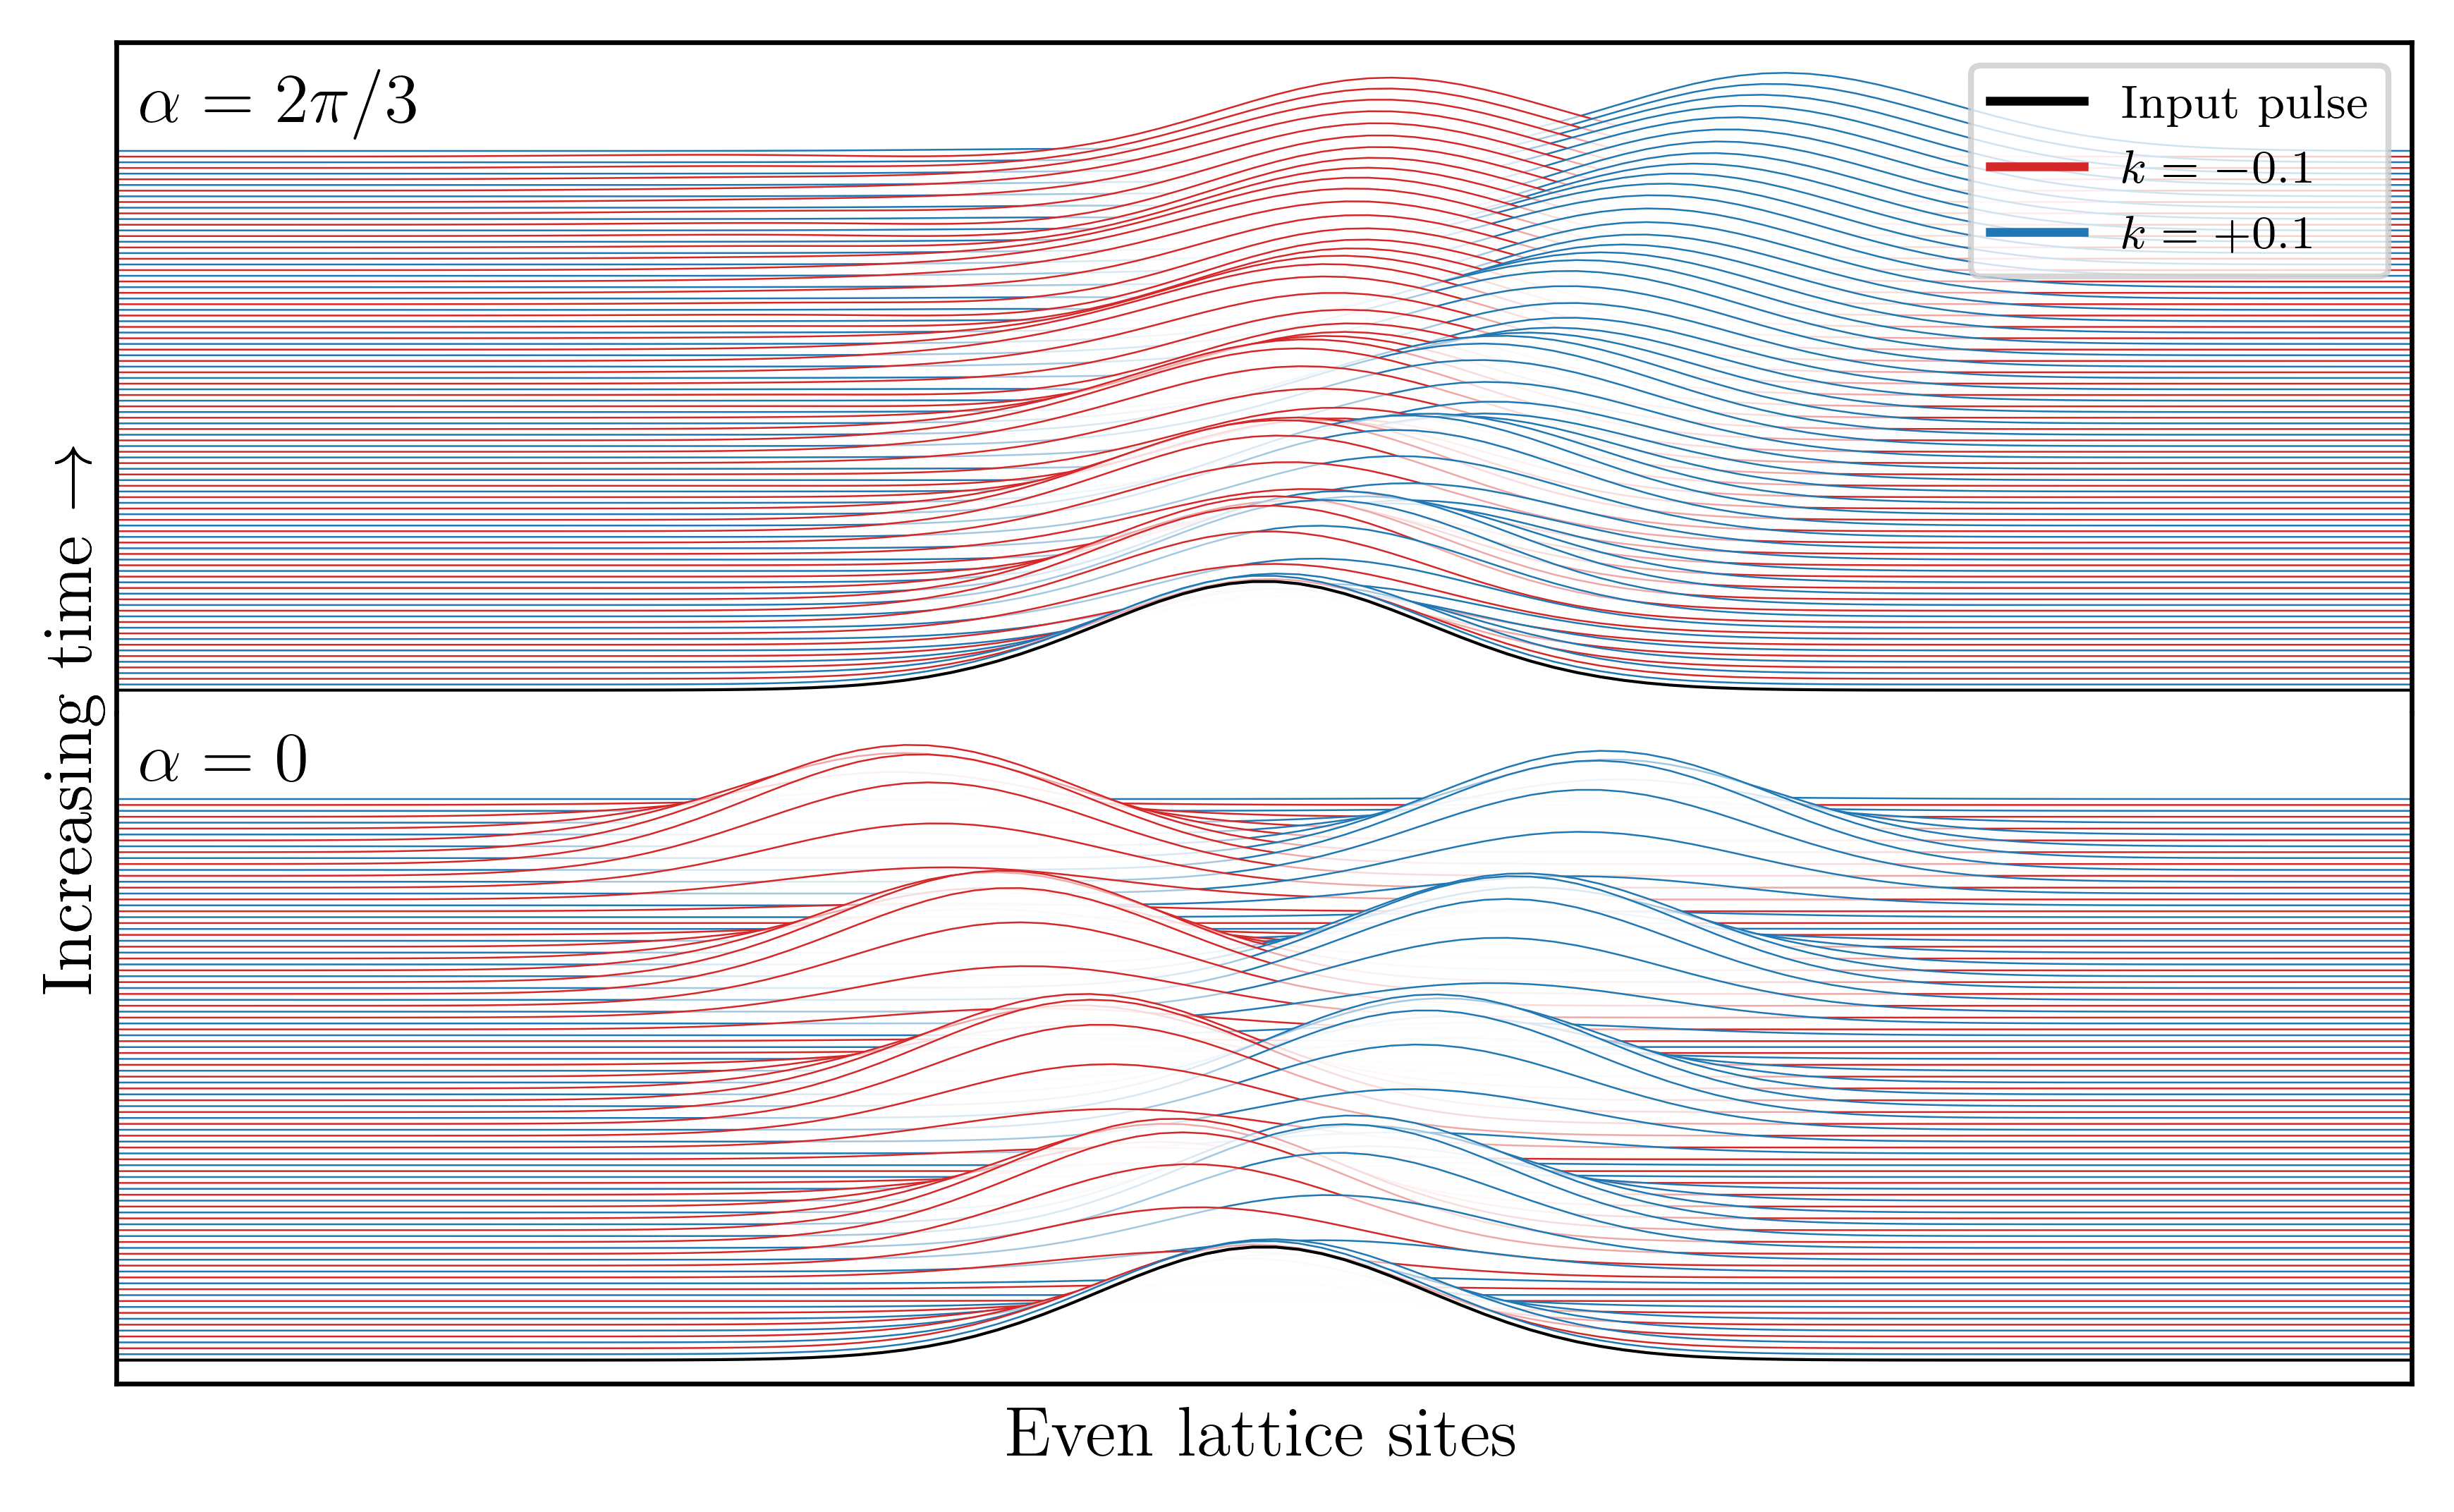

In [394]:
norm = mpl.colors.Normalize(vmin=k_list.min()/np.pi, vmax=k_list.max()/np.pi)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.bwr)
cmap.set_array([])

if parity == "even":
    sites = np.arange(D)[0::2]
    other_sites = np.arange(D)[1::2]
elif parity == "odd":
    sites = np.arange(D)[1::2]
    other_sites = np.arange(D)[0::2]
else:
    sites = np.arange(D)
    
    
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import numpy as np


def offset(myFig,myAx,n=1,yOff=60):
    dx, dy = 0., yOff/myFig.dpi 
    return myAx.transData + mpl.transforms.ScaledTranslation(dx,n*dy,myFig.dpi_scale_trans)

    

    
# Make figure and axis layout
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=11)

figscale=7
fig, axs = plt.subplots(2, 1, figsize=(figscale, .6 * figscale), sharex=True)
plt.subplots_adjust(hspace=0)#figscale * 0.01)

# axs[0].set_xticks([])
axs[0].spines["bottom"].set_visible(False)
axs[0].axes.xaxis.set_visible(False)
axs[1].spines["top"].set_visible(False)

axs[0].set_xlim([min(sites), max(sites)])
axs[1].set_xlim([min(sites), max(sites)])


A = 1.7

for j, (photon_exp, alpha, ax) in enumerate(zip([photon_expectations_over_time_all, photon_expectations_over_time_all_α0], ["2 \\pi / 3", "0"], axs)):
    
    ax.plot(sites, A * photon_exp[0][0][sites], lw=.5, alpha=1.0, c="black", ls='-', label = "$t=0$")
    # ax.plot(sites, photon_exp[0][0][other_sites], lw=1, alpha=1.0, c="black", ls='--')#, label = f"Input state")
    
    for i, k in enumerate(k_list):
        # cmap = [mpl.cm.get_cmap("Reds"), mpl.cm.get_cmap("Blues")][i]
        # norm = mpl.colors.Normalize(vmin=0,vmax=tmax // tstep)
        c = ["tab:red", "tab:blue"][i]
        
        OFFSET = 0.01
        for t_index in list(range(0, tmax // tstep))[:-2]:
            
            z_ind=-(t_index + i/2) ## to ensure each plot is "behind" the previous plot
            trans=offset(fig,ax,t_index,yOff=2)
            
            t = t_index * (tmax//tstep)
            transparency = t_index / (tmax//tstep)
            line = A * photon_exp[i][t_index][sites] + t_index * OFFSET + i * OFFSET/2
            # c = cmap(norm(t_index))
            
            ax.plot(sites, line, lw=.3, alpha= 1, ls='-', c=c, zorder=z_ind)#, label="$t={}$".format(t))#,  label = f"$k / \pi = {k/np.pi:.2f}$",
            # ax.plot(other_sites, -1 * photon_exp[i][t_index][other_sites], lw=1, alpha=transparency, ls='--', c=c)#c=cmap.to_rgba(k/np.pi)) label = f"$k / \pi = {k/np.pi:.2f}$",
            


            ## note that I am using both .plot() and .fill_between(.. edgecolor="None" ..) 
            #  in order to circumvent showing the "edges" of the fill_between 
            # ax.plot(xs,ys,color=cmap(norm(i)),linewidth=1, transform=trans,zorder=z_ind)
            ## try alpha=0.05 below for some "light shading"
            
            ax.fill_between(sites, line, -0.0, facecolor="w", linewidth=0.0, alpha=.6, edgecolor="None",zorder=z_ind)#,transform=trans,zorder=z_ind)
    
    # ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Even lattice sites", fontsize=12)
    ax.set_xticks([])
    # ax.set_title("$\\alpha = {}$".format(alpha))
    # ax.set_xlim([min(sites), max(sites)])
    if j == 0:
        ax.set_ylim([-0.02, max(line) * 1.05])
    else:
        ax.set_ylim([-0.02, max(line) * 1.15])
    ax.set_yticks([])
    fig.text(0.1, 0.5, 'Increasing time $\\rightarrow$', va='center', rotation='vertical', fontsize=12)

    # ax.set_yticks([0, line[0]])
    # ax.set_yticklabels(["$t=0$", "$t={}$".format(tmax)])
    # ax.set_ylabel("Increasing time")

    # cbar = fig.colorbar(cmap, ticks=[k_list.min()/np.pi, 0.0, k_list.max()/np.pi])
    # cbar.ax.set_ylabel('$k / \pi$', rotation=270)

    # plt.legend()
    

# fig.tight_layout()

axs[0].text(0.01, 0.96, "$\\alpha = 2 \\pi / 3$".format(alpha), ha='left', va='top', transform = axs[0].transAxes, fontsize=12)
axs[1].text(0.01, 0.97, "$\\alpha = 0$".format(alpha), ha='left', va='top', transform = axs[1].transAxes, fontsize=12)


from matplotlib.lines import Line2D

colors = ["black", "tab:red", "tab:blue"]
lines = [Line2D([0], [0], color=c, linewidth=1.5, linestyle='-') for c in colors]
labels = ["Input pulse", '$k=-0.1$', '$k=+0.1$']
axs[0].legend(lines, labels, loc=1, prop={"size":8})


# axs[0].legend(["1","2"])
plt.savefig("chiral_currents.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import numpy as np


def offset(myFig,myAx,n=1,yOff=60):
    dx, dy = 0., yOff/myFig.dpi 
    return myAx.transData + mpl.transforms.ScaledTranslation(dx,n*dy,myFig.dpi_scale_trans)

## taken from 
## http://www.gnuplotting.org/data/head_related_impulse_responses.txt
df=pd.read_csv('head_related_impulse_responses.txt',delimiter="\t",skiprows=range(2),header=None)
df=df.transpose()

def plot_2D_a():
    """ a 2D plot which uses color to indicate the angle"""
    fig,ax=plt.subplots(figsize=(5,6))
    sampling=2
    thetas=range(0,360)[::sampling]

    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=0,vmax=360)

    for idx,i in enumerate(thetas):
        z_ind=360-idx ## to ensure each plot is "behind" the previous plot
        trans=offset(fig,ax,idx,yOff=sampling)

        xs=df.loc[0]
        ys=df.loc[i+1]

        ## note that I am using both .plot() and .fill_between(.. edgecolor="None" ..) 
        #  in order to circumvent showing the "edges" of the fill_between 
        ax.plot(xs,ys,color=cmap(norm(i)),linewidth=1, transform=trans,zorder=z_ind)
        ## try alpha=0.05 below for some "light shading"
        ax.fill_between(xs,ys,-0.5,facecolor="w",alpha=1, edgecolor="None",transform=trans,zorder=z_ind)

    cbax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) # x-position, y-position, x-width, y-height
    cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=norm, orientation='vertical')
    cb1.set_label('Angle')

    ## use some sensible viewing limits
    ax.set_xlim(-0.2,2.2)
    ax.set_ylim(-0.5,5)

    ax.set_xlabel('time [ms]')

In [111]:
cmap.to_rgba(2/np.pi)

(1.0, 0.0, 0.0, 1.0)

In [168]:
[i for i in mpl.cm]

TypeError: 'module' object is not iterable

In [180]:
colormaps = [
    mpl.cm.viridis,
    mpl.cm.plasma,
    mpl.cm.inferno,
    mpl.cm.magma,
    mpl.cm.spring,
    mpl.cm.summer,
    mpl.cm.autumn,
    mpl.cm.winter,
    mpl.cm.cool,
    mpl.cm.hot,
    mpl.cm.jet
]
for colormap in colormaps:
    colorcode = "vec4[11]"+str(tuple("vec4"+str(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=colormap).to_rgba(i))+"" for i in np.linspace(0,1,11))).replace("'","")
    print("vec4 " + colormap.name + "(float x) { return get_color("+colorcode+", x); }")
    print("")

vec4 viridis(float x) { return get_color(vec4[11](vec4(0.267004, 0.004874, 0.329415, 1.0), vec4(0.282623, 0.140926, 0.457517, 1.0), vec4(0.253935, 0.265254, 0.529983, 1.0), vec4(0.206756, 0.371758, 0.553117, 1.0), vec4(0.163625, 0.471133, 0.558148, 1.0), vec4(0.127568, 0.566949, 0.550556, 1.0), vec4(0.134692, 0.658636, 0.517649, 1.0), vec4(0.266941, 0.748751, 0.440573, 1.0), vec4(0.477504, 0.821444, 0.318195, 1.0), vec4(0.741388, 0.873449, 0.149561, 1.0), vec4(0.993248, 0.906157, 0.143936, 1.0)), x); }

vec4 plasma(float x) { return get_color(vec4[11](vec4(0.050383, 0.029803, 0.527975, 1.0), vec4(0.254627, 0.013882, 0.615419, 1.0), vec4(0.417642, 0.000564, 0.65839, 1.0), vec4(0.562738, 0.051545, 0.641509, 1.0), vec4(0.69284, 0.165141, 0.564522, 1.0), vec4(0.798216, 0.280197, 0.469538, 1.0), vec4(0.881443, 0.392529, 0.383229, 1.0), vec4(0.949217, 0.517763, 0.295662, 1.0), vec4(0.98826, 0.652325, 0.211364, 1.0), vec4(0.988648, 0.809579, 0.145357, 1.0), vec4(0.940015, 0.975158, 0.131326, 

In [169]:
plt.cm.get_cmap('')

ValueError: '' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

0 -6.283185307179586
1 -5.026548245743669
2 -3.7699111843077517
3 -2.513274122871834
4 -1.256637061435917
5 0.0
6 1.2566370614359184
7 2.5132741228718354
8 3.769911184307752
9 5.026548245743669
10 6.283185307179586


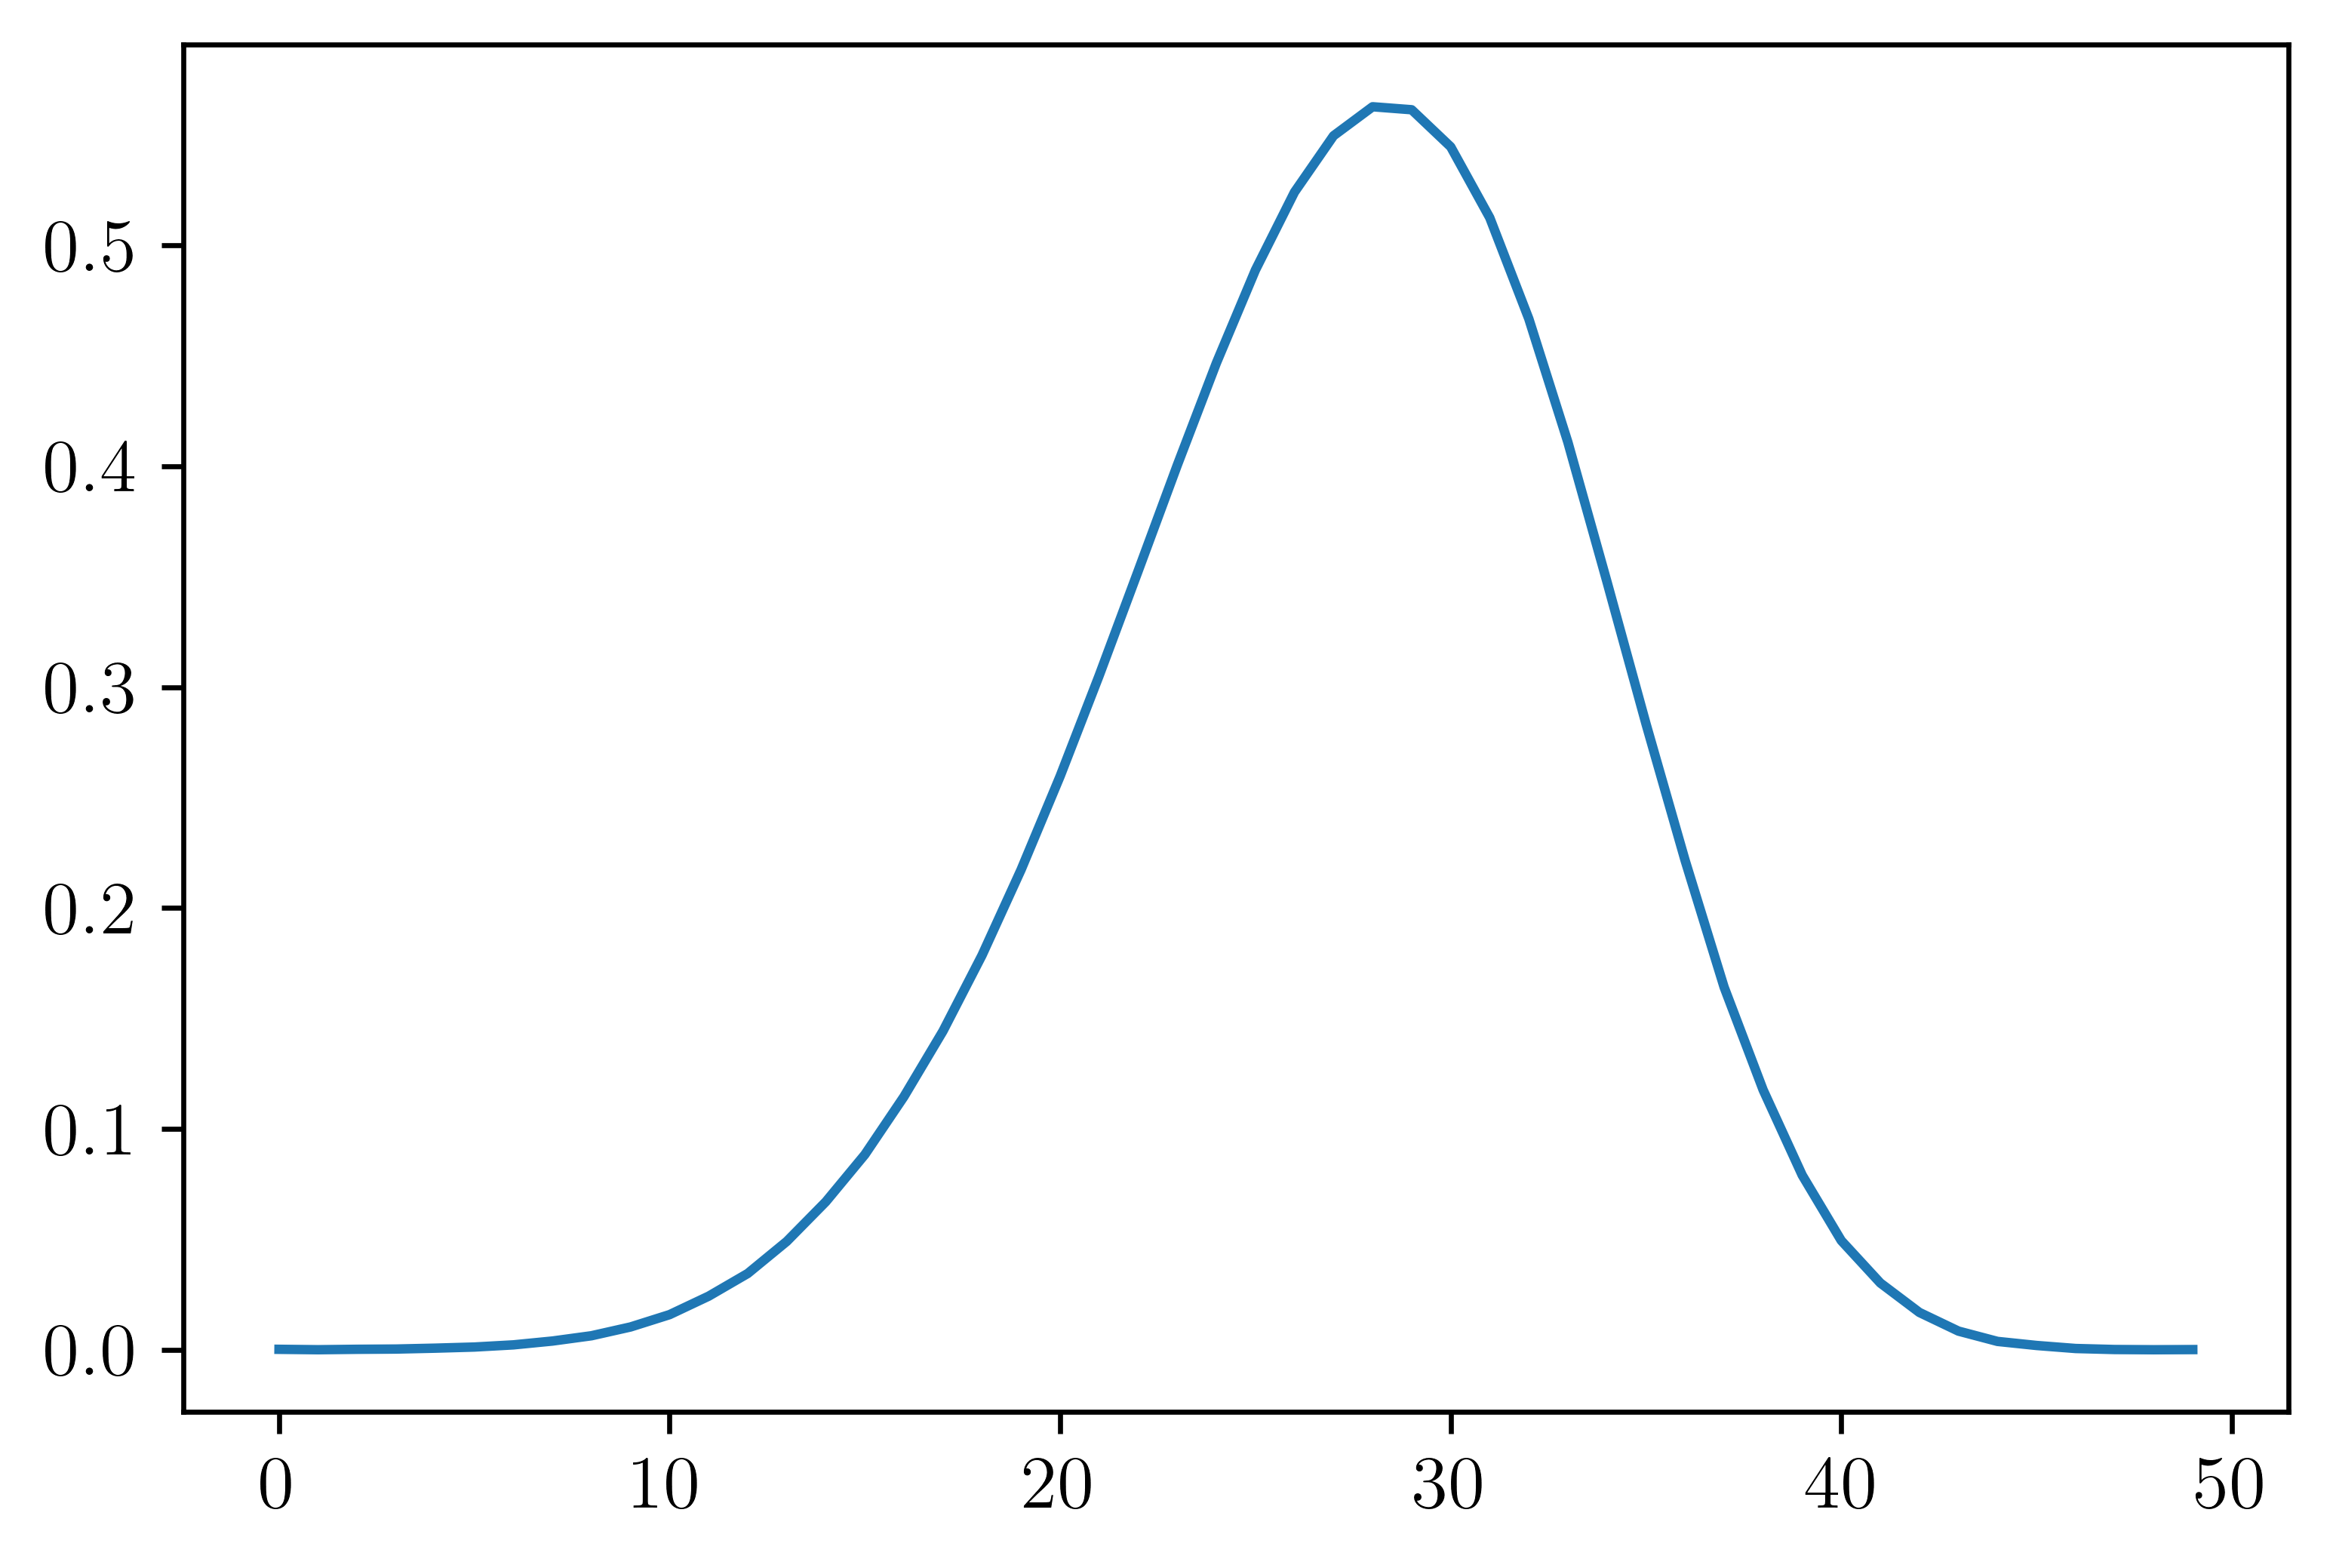

In [64]:
for i, k in enumerate(k_list):
    print(i,k)
plt.plot(photon_expectations_over_time_all[5][-1][sites])
plt.show()

# Tight-binding Hamiltonian in a 4D tesseract

In [3]:
tesseract_nodes = tuple(range(16))
tesseract_edges = (
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7], 
    [7, 4],
    [8, 9],
    [9, 10],
    [10, 11], 
    [11, 8],
    [12, 13],
    [13, 14], 
    [14, 15],
    [15, 12],
    [0, 4], 
    [1, 5],
    [2, 6],
    [3, 7],
    [4, 8], 
    [5, 9],
    [6, 10],
    [7, 11],
    [8, 12],
    [9, 13],
    [10, 14],
    [11, 15],
    [12, 0],
    [13, 1],
    [14, 2],
    [15, 3]
)
assert len(tesseract_edges) == 32

def construct_tesseract_propagator(κ=0.1,
                                     α=0.0,
                                     num_bosons=None,
                                     μ=0.0, U=0.0,
                                     include_coupling=True,
                                     include_chemical_potential=False,
                                     include_onsite_interaction=False,
                                     normalize_μ_U_by_iteration_time=True,
                                     ordering="edges",
                                     use_ponomarev=True,
                                     subdivide_iterations=False,
                                     display_progress=False):
    nodes = tesseract_nodes
    edges = [((v1, v2), κ, α) for [v1, v2] in tesseract_edges]
    return construct_BHH_propagator(nodes, edges, num_bosons=num_bosons, μ=μ, U=U,
                                    include_coupling=include_coupling,
                                    include_chemical_potential=include_chemical_potential,
                                    include_onsite_interaction=include_onsite_interaction,
                                    normalize_μ_U_by_iteration_time=normalize_μ_U_by_iteration_time,
                                    ordering=ordering,
                                    use_ponomarev=use_ponomarev,
                                    subdivide_iterations=subdivide_iterations,
                                    display_progress=display_progress)

def BHH_tesseract(κ=0.1,
                α=0.0,
                num_bosons=None,
                μ=0.0, U=0.0,
                include_coupling=True,
                include_chemical_potential=False,
                include_onsite_interaction=False,
                add_extraneous_register_node=False,
                use_ponomarev=True,
                display_progress=False):
    nodes = tesseract_nodes
    edges = [((v1, v2), κ, α) for [v1, v2] in tesseract_edges]
    return make_BH_Hamiltonian(nodes, edges, num_bosons=num_bosons, μ=μ, U=U,
                               include_coupling=include_coupling,
                               include_chemical_potential=include_chemical_potential,
                               include_onsite_interaction=include_onsite_interaction,
                               use_ponomarev=use_ponomarev,
                               display_progress=display_progress)

In [6]:
def simulate_tesseract_evolution_and_save(N=2, κ=0.2, μ=0.0, U=0.0, α=0.0, tmax=200, tstep=1, 
                                   initial_state=None, use_ponomarev=True,
                                   synthetic=True, subdivide_iterations=False):
    

    D = 16 if synthetic == False else 17
    
    start = time.time()
    
    if type(initial_state) is list:
        # Can pass a custom fock list
        assert(sum(initial_state) == N)
        fock_list = initial_state
    else:
        raise ValueError()
    

    if use_ponomarev:
        state_initial = qt_fock_to_ponomarev(fock_list, N, D)
    else:
        state_initial = qt.basis([N+1] * D, fock_list)
        
        
    photon_expectations_over_time = []
    states_over_time = []
    states_over_time_subdivided = None
    clock_cycle=None
    if subdivide_iterations and not synthetic:
        raise ValueError("Subdivide iterations only applicable to synthetic case")
    
    if synthetic:
        ret = construct_tesseract_propagator(num_bosons=N,
                                             κ=κ, μ=μ, U=U, α=α,
                                             include_chemical_potential=(μ != 0.0),
                                             include_onsite_interaction=(U != 0.0),
                                             use_ponomarev=use_ponomarev,
                                             display_progress=False,
                                             subdivide_iterations=subdivide_iterations)
        if subdivide_iterations:
            G, operators, clock_cycle = ret
            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
                state_evolved = (G ** t) * state_initial
                states_over_time.append(state_evolved)
                
            state = state_initial
            states_over_time_subdivided = [state]
            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving subdivided states"):
                for op in operators:
                    state = op * state
                    states_over_time_subdivided.append(state)
        else:
            G = ret
            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
                state_evolved = (G ** t) * state_initial
                states_over_time.append(state_evolved)
        
    else:
    
        H = BHH_tesseract(num_bosons=N,
                        κ=κ, μ=μ, U=U, α=α,
                        include_chemical_potential=(μ != 0.0),
                        include_onsite_interaction=(U != 0.0),
                        use_ponomarev=use_ponomarev,
                        display_progress=False)

        for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
            state_evolved = (-1j * H * t).expm() * state_initial
            states_over_time.append(state_evolved)

    two_photon_correlations_over_time = [get_two_photon_correlations(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)
                                         for state in tqdm(states_over_time, desc="Computing 2-photon correlations")]
    photon_expectations_over_time = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                     for state in states_over_time]
    if subdivide_iterations:
        photon_expectations_over_time_subdivided = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                                    for state in states_over_time_subdivided]
    else:
        photon_expectations_over_time_subdivided = None
    double_photon_expectations_over_time = [np.array(get_double_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                            for state in states_over_time]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    filename = f"results/tesseract_evolution_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{tmax=}_{initial_state}_{synthetic=}_results.pickle"
    obj = {
        "state_initial": state_initial,
        # "H": H,
        "states_over_time": states_over_time,
        "states_over_time_subdivided": states_over_time_subdivided,
        "photon_expectations_over_time": photon_expectations_over_time,
        "photon_expectations_over_time_subdivided": photon_expectations_over_time_subdivided,
        "clock_cycle": clock_cycle,
        "double_photon_expectations_over_time": double_photon_expectations_over_time,
        "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Simulation complete. Elapsed time: {time.time()-start}s. Results saved to {filename}")
    
    return filename

## Figure 4 generation code

Evolving states:   0%|          | 0/51 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/51 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 3.832287073135376s. Results saved to results/tesseract_evolution_N=2_D=16_kappa=0.1_mu=0_U=0_tmax=51_[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle


Evolving states:   0%|          | 0/51 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/51 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 7.5717151165008545s. Results saved to results/tesseract_evolution_N=2_D=17_kappa=0.1_mu=0_U=0_tmax=51_[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]_synthetic=True_results.pickle


/var/folders/0z/xsbv2hk57xnd_dpvwg4zpfrr0000gn/T/ipykernel_16824/1864613139.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/0z/xsbv2hk57xnd_dpvwg4zpfrr0000gn/T/ipykernel_16824/1864613139.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/0z/xsbv2hk57xnd_dpvwg4zpfrr0000gn/T/ipykernel_16824/1864613139.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("assets/tesseract_evolution_2.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
/var/folders/0z/xsbv2hk57xnd_dpvwg4zpfrr0000gn/T/ipykernel_16824/1864613139.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("assets/tesseract_evolution_2.pdf", dpi=300, bbox_inches='tight

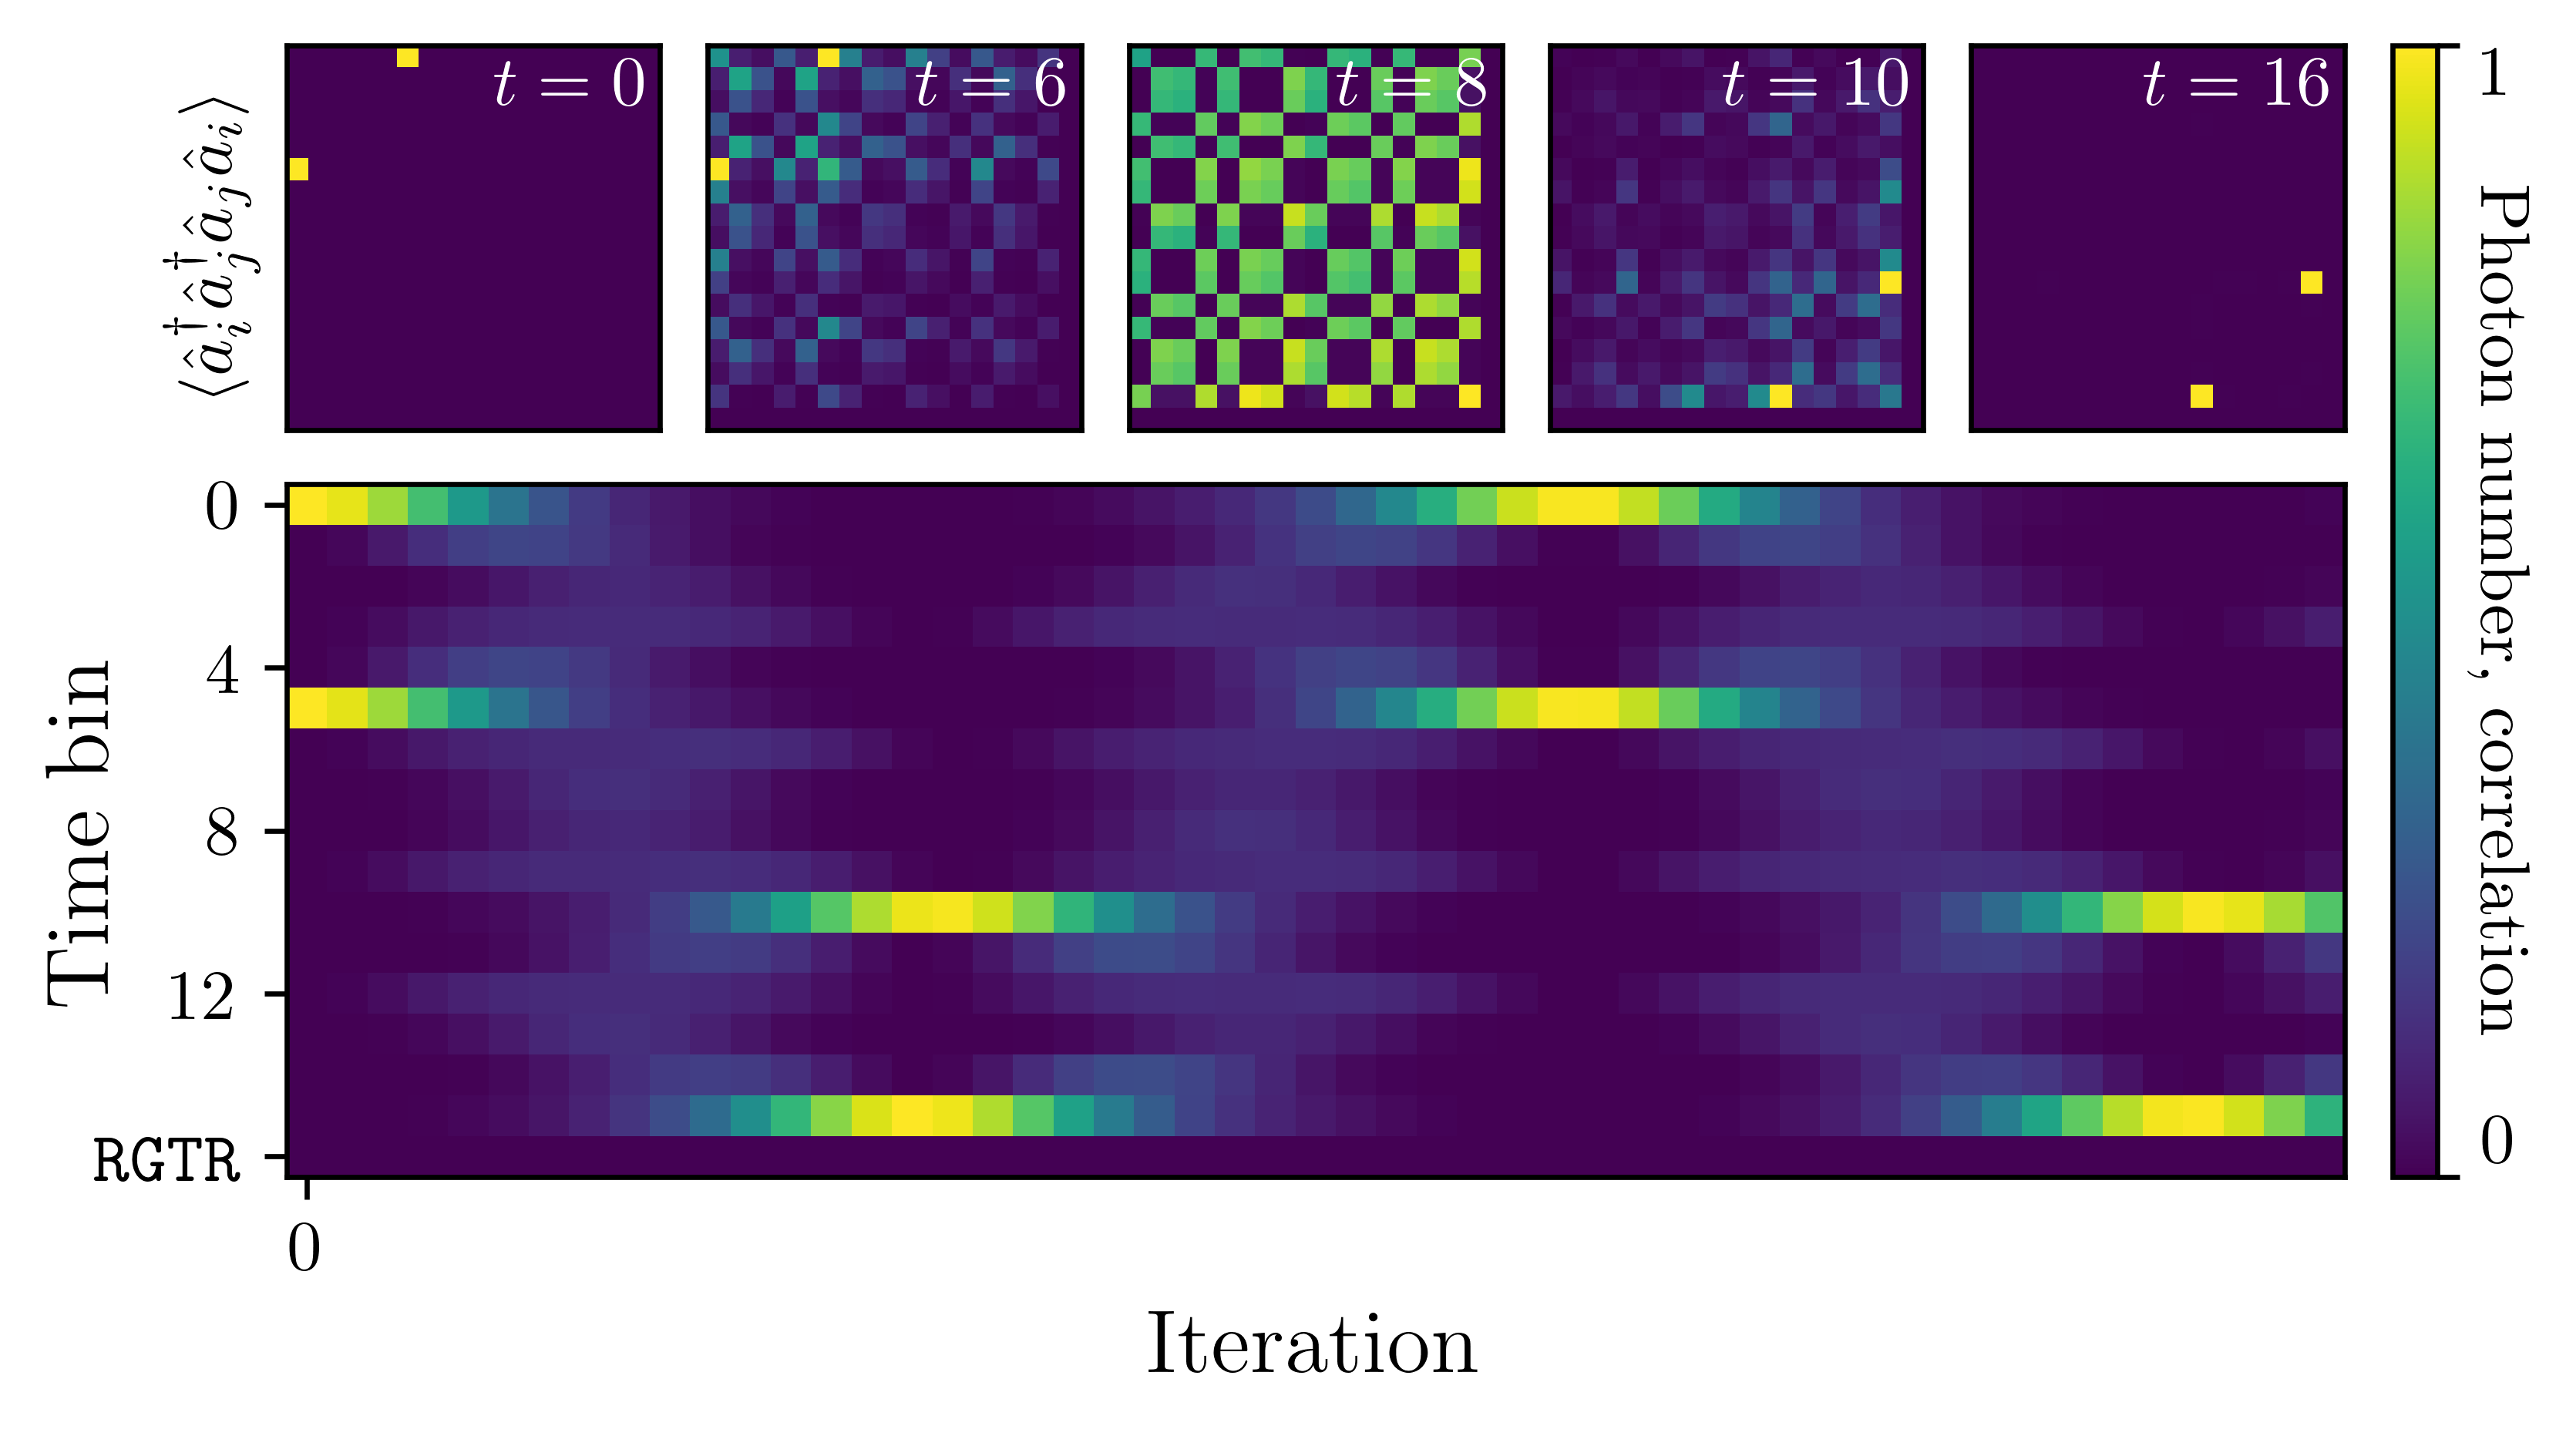

In [9]:
N=2
κ = 0.1 #0.01
α = 0
tmax = 51 #501
tstep = 1
# state_type = "same_bin"

fock_list = [0] * D

fock_list[0] = 1
fock_list[5] = 1


fn_actual = simulate_tesseract_evolution_and_save(N=N, κ=κ, μ=0, U=0, α=0, tmax=tmax, 
                                          tstep=tstep, initial_state=fock_list, 
                                          use_ponomarev=True,
                                          synthetic=False)
fn_synth = simulate_tesseract_evolution_and_save(N=N, κ=κ, μ=0, U=0, α=0, tmax=tmax, 
                                          tstep=tstep, initial_state=fock_list, 
                                          use_ponomarev=True,
                                          synthetic=True, subdivide_iterations=False)



with open(fn_actual, "rb") as f:
    obj = pickle.load(f)
photon_expectations_over_time_actual = obj["photon_expectations_over_time"]
two_photon_correlations_over_time_actual = obj["two_photon_correlations_over_time"]

with open(fn_synth, "rb") as f:
    obj = pickle.load(f)
photon_expectations_over_time_synth_subdivided = obj["photon_expectations_over_time_subdivided"]
photon_expectations_over_time_synth = obj["photon_expectations_over_time"]
two_photon_correlations_over_time_synth = obj["two_photon_correlations_over_time"]


# clock_cycle = len(photon_expectations_over_time_synth_subdivided) // 3 # ignoring some optimizations here
# iterations = len(photon_expectations_over_time_synth)


savefig=True
photon_correlation_snapshots = [0,6,8,10,16]  # [0, 60, 80, 100, 160]
figscale=6
    
# Make figure and axis layout
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=11)

fig = plt.figure(figsize=(figscale, .54 * figscale), tight_layout=True)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=6, height_ratios = [1, 1.8], width_ratios=[1, 1, 1, 1, 1, 0.12], hspace=.1, wspace=.15)

ax_synth = fig.add_subplot(gs[1, :-1])
cax_synth = fig.add_subplot(gs[:, -1])

# ax_actual = fig.add_subplot(gs[1, :-1])
# cax_actual = fig.add_subplot(gs[1, -1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
# cax_corr = fig.add_subplot(gs[0, -1])

# Plot evolved state
cmap=plt.get_cmap('viridis')

# # ax.xaxis.tick_top()
# ax_actual.set_xlabel("Time $ t / \\hbar $")
# ax_actual.get_xaxis().labelpad=-10
# ax_actual.set_ylabel("Site index", fontsize=16)
# ax_actual.set_yticks([0, 4, 8, 12])
# ax_actual.imshow(np.transpose(photon_expectations_over_time_actual), aspect='auto', cmap=cmap, vmax=1)#.5)

ax_synth.set_xlabel("Iteration", fontsize=14)
ax_synth.set_xticks([0, 100, 200, 300, 400, 500])
ax_synth.set_ylabel("Time bin", fontsize=14, labelpad=-5)
ax_synth.set_yticks([0, 4, 8, 12, 16])
ax_synth.set_yticklabels(["0", "4", "8", "12", "$\\texttt{RGTR}$"])
ax_synth.imshow(np.transpose(photon_expectations_over_time_synth), aspect='auto', cmap=cmap, vmax=1, interpolation="nearest")#.5)


fig.tight_layout()

# mpl.colorbar.ColorbarBase(cax_actual, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])#.5])
cbar = mpl.colorbar.ColorbarBase(cax_synth, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])#.5])
ticks = cbar.ax.get_yticklabels()
ticks[1].set_verticalalignment('top')
ticks[0].set_verticalalignment('bottom')
# mpl.colorbar.ColorbarBase(cax_corr, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])


# cax_actual.get_yaxis().labelpad=2
# cax_actual.set_ylabel("Photon occupancy", rotation=270)
cax_synth.get_yaxis().labelpad=2
cax_synth.set_ylabel("Photon number, correlation", rotation=270, fontsize=11)
                     
# cax_corr.get_yaxis().labelpad=6
# cax_corr.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_j ^\\dagger \\hat a_j \\hat a_i  \\rangle$", rotation=270, fontsize=10)


# Add 2-photon correlation subplots
for i, axis in enumerate([ax1, ax2, ax3, ax4, ax5]):
    
    axis.xaxis.set_label_position("top")
                     
    axis.set_xticks([])
    axis.set_yticks([])

    if i == 0:
        # axis.set_ylabel("Time bin $i$", fontsize=12)
        # axis.set_xlabel("Time bin $j$", fontsize=12)
        axis.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_j ^\\dagger \\hat a_j \\hat a_i  \\rangle$")
        # axis.set_xlabel("$j$")
    if i > 0:
        plt.setp(axis.get_yticklabels(), visible=False)
        # axis.set_xlabel("$j$")


    time_index = photon_correlation_snapshots[i]
    two_photon_correlations = two_photon_correlations_over_time_synth[time_index]
    axis.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
    axis.text(.97, 0.97, f"$t = {time_index}$", ha = 'right', va = 'top', color="white", transform = axis.transAxes)


fig.tight_layout()

if savefig:
    plt.savefig("assets/tesseract_evolution_2.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
else:
    plt.show()

# Grid lattice emulation with subdivided iterations (Fig. 1d)

In [13]:
def simulate_2d_grid_evolution_and_save(N=2, D=9, κ=0.2, μ=0.0, U=0.0, tmax=200, tstep=1, 
                                          toroidal=False,
                                   initial_state=None, use_ponomarev=True,
                                   synthetic=True, subdivide_iterations=False):
    
    if synthetic:
        D += 1
    
    start = time.time()
    
    if type(initial_state) is list:
        # Can pass a custom fock list
        assert(sum(initial_state) == N)
        fock_list = initial_state
    else:
        raise ValueError()
    

    if use_ponomarev:
        state_initial = qt_fock_to_ponomarev(fock_list, N, D)
    else:
        state_initial = qt.basis([N+1] * D, fock_list)
        
        
    photon_expectations_over_time = []
    states_over_time = []
    states_over_time_subdivided = None
    clock_cycle=None
    if subdivide_iterations and not synthetic:
        raise ValueError("Subdivide iterations only applicable to synthetic case")
    
    if synthetic:
        nx = int(np.sqrt(D))
        ny = int(np.sqrt(D))
        ret = construct_BHH_propagator_2d_grid(nx, ny, num_bosons=N, toroidal=toroidal,
                                               κ=κ, μ=μ, U=U,
                                               include_chemical_potential=(μ != 0.0),
                                               include_onsite_interaction=(U != 0.0),
                                               use_ponomarev=use_ponomarev,
                                               subdivide_iterations=subdivide_iterations,
                                               display_progress=False)
        if subdivide_iterations:
            G, operators, clock_cycle = ret
            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
                state_evolved = (G ** t) * state_initial
                states_over_time.append(state_evolved)
                
            state = state_initial
            states_over_time_subdivided = [state]
            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving subdivided states"):
                for op in operators:
                    state = op * state
                    states_over_time_subdivided.append(state)
        else:
            G = ret
            for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
                state_evolved = (G ** t) * state_initial
                states_over_time.append(state_evolved)
        
    else:
        nx = int(np.sqrt(D))
        ny = int(np.sqrt(D))
        H = BHH_2d_grid(nx, ny, toroidal=toroidal, num_bosons=N,
                        κ=κ, μ=μ, U=U,
                        include_chemical_potential=(μ != 0.0),
                        include_onsite_interaction=(U != 0.0),
                        use_ponomarev=use_ponomarev,
                        display_progress=False)

        for t in tqdm(np.arange(0, tmax, tstep), desc="Evolving states"):
            state_evolved = (-1j * H * t).expm() * state_initial
            states_over_time.append(state_evolved)

    two_photon_correlations_over_time = [get_two_photon_correlations(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)
                                         for state in tqdm(states_over_time, desc="Computing 2-photon correlations")]
    photon_expectations_over_time = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                     for state in states_over_time]
    if subdivide_iterations:
        photon_expectations_over_time_subdivided = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                                    for state in states_over_time_subdivided]
    else:
        photon_expectations_over_time_subdivided = None
    double_photon_expectations_over_time = [np.array(get_double_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                            for state in states_over_time]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    filename = f"results/grid_2d_evolution_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{tmax=}_{initial_state}_{synthetic=}_results.pickle"
    obj = {
        "state_initial": state_initial,
        # "H": H,
        "states_over_time": states_over_time,
        "states_over_time_subdivided": states_over_time_subdivided,
        "photon_expectations_over_time": photon_expectations_over_time,
        "photon_expectations_over_time_subdivided": photon_expectations_over_time_subdivided,
        "clock_cycle": clock_cycle,
        "double_photon_expectations_over_time": double_photon_expectations_over_time,
        "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Simulation complete. Elapsed time: {time.time()-start}s. Results saved to {filename}")
    
    return filename

Evolving states:   0%|          | 0/300 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/300 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 4.474772930145264s. Results saved to results/grid_2d_evolution_N=1_D=9_kappa=0.01_mu=0_U=0_tmax=300_[1, 0, 0, 0, 0, 0, 0, 0, 0]_synthetic=False_results.pickle


Evolving states:   0%|          | 0/15 [00:00<?, ?it/s]

Evolving subdivided states:   0%|          | 0/15 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/15 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 0.7930281162261963s. Results saved to results/grid_2d_evolution_N=1_D=10_kappa=0.2_mu=0_U=0_tmax=15_[1, 0, 0, 0, 0, 0, 0, 0, 0]_synthetic=True_results.pickle


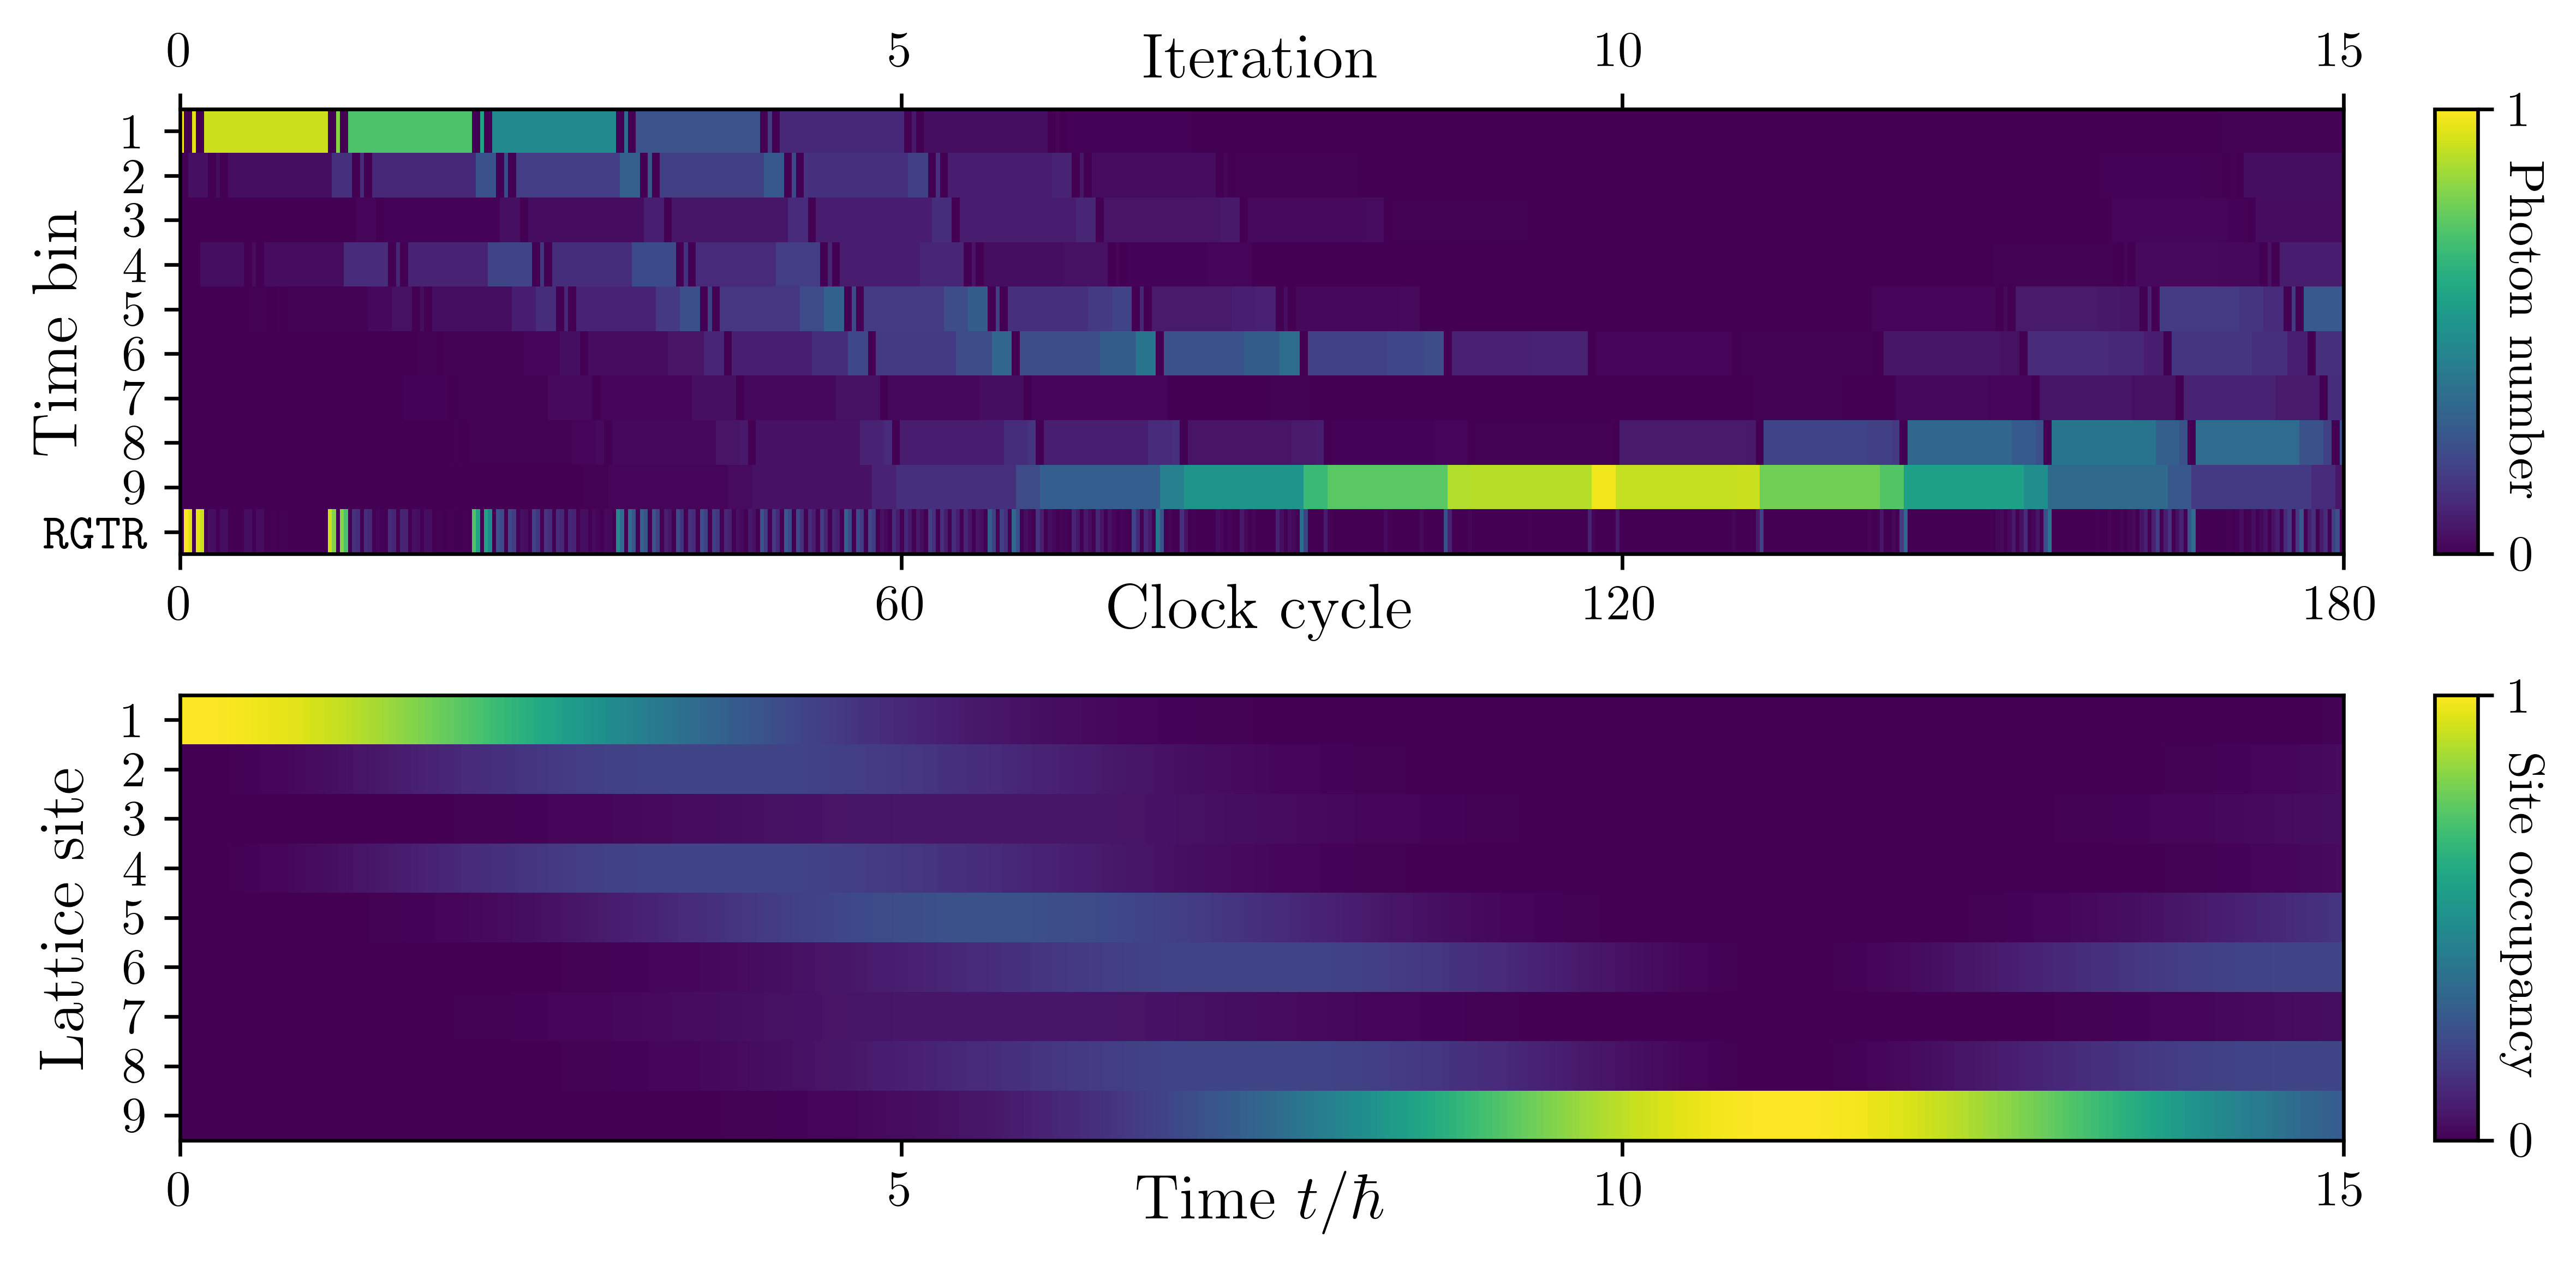

In [16]:
N=1
D=9
κ = 0.2
tmax = 15
tstep = 1
toroidal=False

fock_list = [0] * D
fock_list[0] = 1


fn_actual = simulate_2d_grid_evolution_and_save(N=N, D=D,κ=κ / 20, μ=0, U=0, tmax=tmax * 20, toroidal=toroidal,
                                          tstep=tstep, initial_state=fock_list, 
                                          use_ponomarev=True,
                                          synthetic=False)
fn_synth = simulate_2d_grid_evolution_and_save(N=N,D=D, κ=κ, μ=0, U=0, tmax=tmax, toroidal=toroidal,
                                          tstep=tstep, initial_state=fock_list, 
                                          use_ponomarev=True,
                                          synthetic=True, subdivide_iterations=True)



with open(fn_actual, "rb") as f:
    obj = pickle.load(f)
photon_expectations_over_time_actual = obj["photon_expectations_over_time"]
# two_photon_correlations_over_time_actual = obj["two_photon_correlations_over_time"]

with open(fn_synth, "rb") as f:
    obj = pickle.load(f)
photon_expectations_over_time_synth_non_subdivided = obj["photon_expectations_over_time"]
photon_expectations_over_time_synth = obj["photon_expectations_over_time_subdivided"]
# clock_cycle = obj["clock_cycle"]
clock_cycle = len(photon_expectations_over_time_synth) // 3 # ignoring some optimizations here
iterations = len(photon_expectations_over_time_synth_non_subdivided)


savefig=True
photon_correlation_snapshots = [0, 15, 30]
figscale=8
    
# Make figure and axis layout
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=11)

fig = plt.figure(figsize=(figscale, .5 * figscale), tight_layout=True)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, height_ratios = [1.5, 1.5], width_ratios=[1,0.02])

ax_synth = fig.add_subplot(gs[0, 0])
cax_synth = fig.add_subplot(gs[0, 1])

ax_actual = fig.add_subplot(gs[1, 0])
cax_actual = fig.add_subplot(gs[1, 1])

# Plot evolved state
cmap=plt.get_cmap('viridis')
ax_actual.set_xlabel("Time $ t / \\hbar $", fontsize=14)
ax_actual.get_xaxis().labelpad=-10
ax_actual.set_xticks([0,5,10,15])

ax_actual.set_ylabel("Lattice site", fontsize=14, labelpad=6)
ax_actual.set_yticks([0,1,2,3,4,5,6,7,8])
ax_actual.set_yticklabels([1,2,3,4,5,6,7,8,9])
ax_actual.imshow(np.transpose(photon_expectations_over_time_actual), aspect='auto', extent=[0,tmax,8.5,-0.5], cmap=cmap, vmax=1)#.5)

ax_synth.set_xlabel("Clock cycle", fontsize=14)
ax_synth.set_xticks([0,clock_cycle//3,clock_cycle * 2 // 3,clock_cycle])

ax_synth.get_xaxis().labelpad=-10
secondary_xaxis = ax_synth.secondary_xaxis("top", functions=(lambda x: x * iterations / clock_cycle, lambda x: x * iterations / clock_cycle))
secondary_xaxis.set_xlabel("Iteration", fontsize=14)
secondary_xaxis.get_xaxis().labelpad=-10
secondary_xaxis.set_xticks([0,iterations//3,iterations * 2 // 3,iterations])

ax_synth.set_ylabel("Time bin", fontsize=14, labelpad=-10)
ax_synth.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax_synth.set_yticklabels([1,2,3,4,5,6,7,8,9, "\\texttt{RGTR}"])
ax_synth.imshow(np.transpose(photon_expectations_over_time_synth), aspect='auto', extent=[0,clock_cycle,9.5,-0.5], cmap=cmap, vmax=1)#.5)

mpl.colorbar.ColorbarBase(cax_actual, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])#.5])
mpl.colorbar.ColorbarBase(cax_synth, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])#.5])

cax_actual.get_yaxis().labelpad=2
cax_actual.set_ylabel("Site occupancy", rotation=270, fontsize=11)
cax_synth.get_yaxis().labelpad=2
cax_synth.set_ylabel("Photon number", rotation=270, fontsize=11)


fig.tight_layout()

if savefig:
    plt.savefig("assets/2d_evolution_subdivided_v2.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
else:
    plt.show()

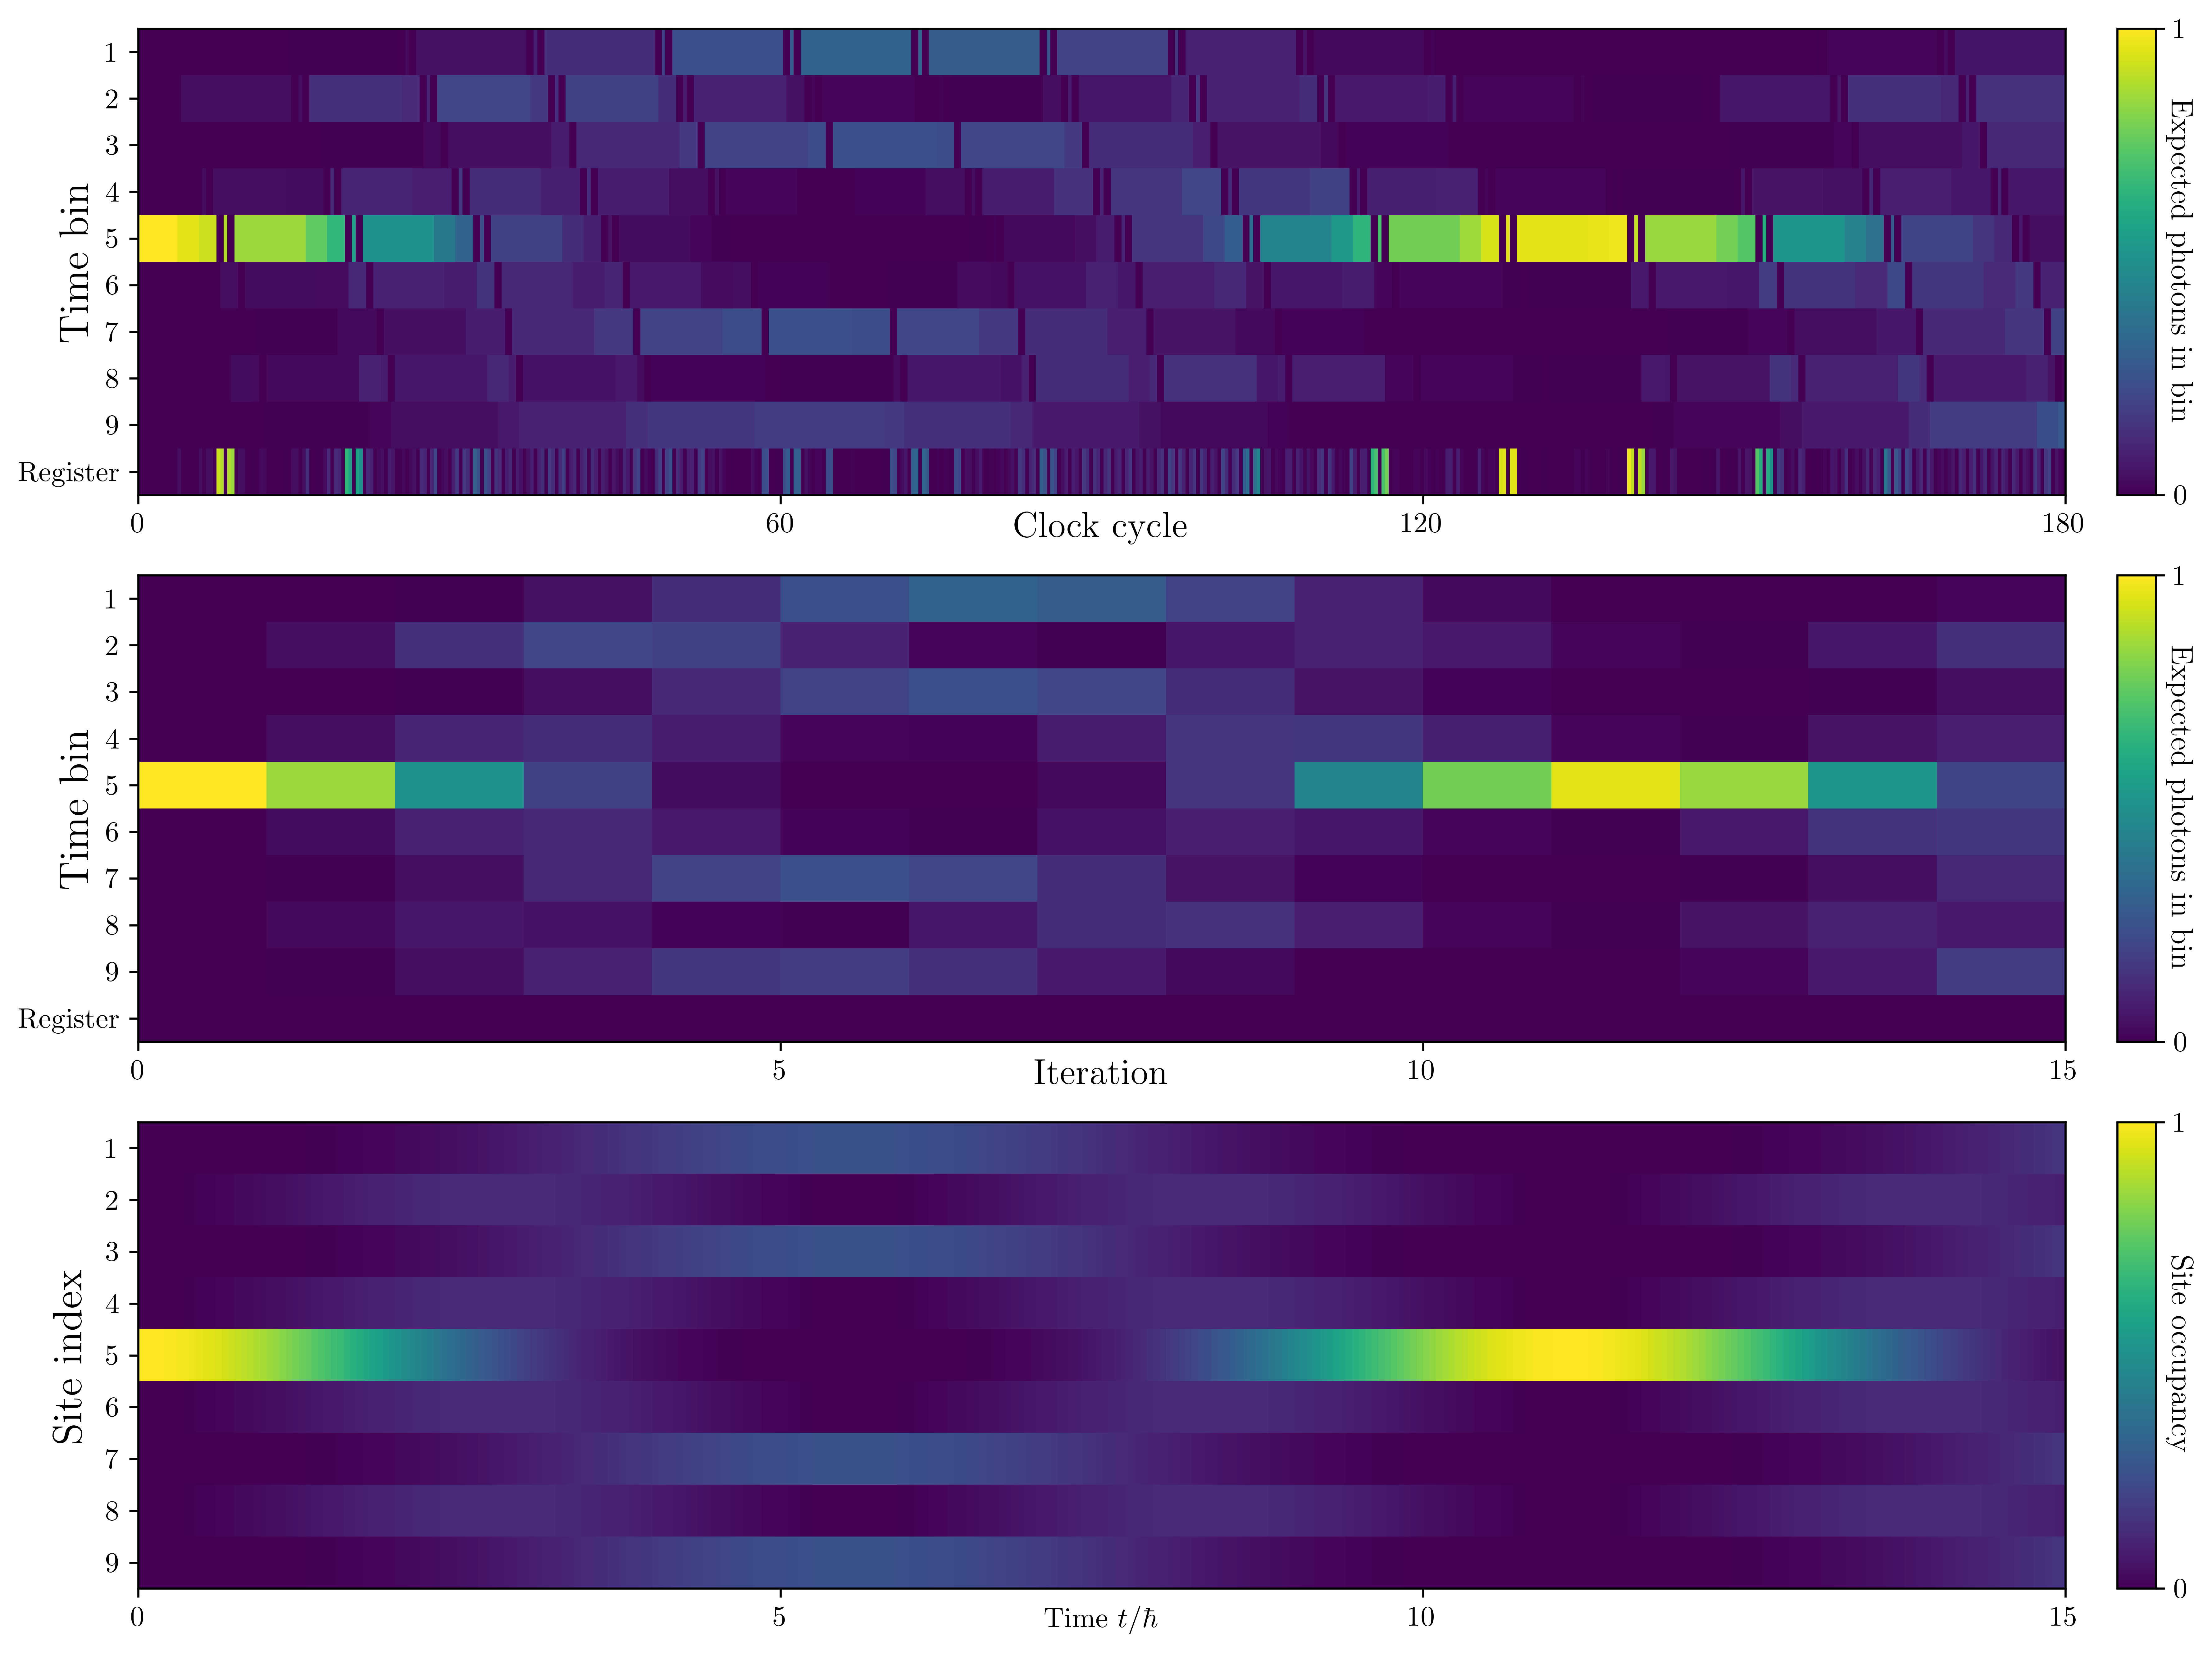

In [56]:

with open(fn_actual, "rb") as f:
    obj = pickle.load(f)
photon_expectations_over_time_actual = obj["photon_expectations_over_time"]
# two_photon_correlations_over_time_actual = obj["two_photon_correlations_over_time"]

with open(fn_synth, "rb") as f:
    obj = pickle.load(f)
photon_expectations_over_time_synth_non_subdivided = obj["photon_expectations_over_time"]
photon_expectations_over_time_synth = obj["photon_expectations_over_time_subdivided"]
# clock_cycle = obj["clock_cycle"]
clock_cycle = len(photon_expectations_over_time_synth) // 3 # ignoring some optimizations here
iterations = len(photon_expectations_over_time_synth_non_subdivided)


savefig=True

figscale=12
    
# Make figure and axis layout
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=11)

fig = plt.figure(figsize=(figscale, .75 * figscale), tight_layout=True)
gs = mpl.gridspec.GridSpec(nrows=3, ncols=2, height_ratios = [1.5, 1.5, 1.5], width_ratios=[1,0.02])

ax_synth = fig.add_subplot(gs[0, 0])
cax_synth = fig.add_subplot(gs[0, 1])

ax_synth_no_sub = fig.add_subplot(gs[1, 0])
cax_synth_no_sub = fig.add_subplot(gs[1, 1])

ax_actual = fig.add_subplot(gs[2, 0])
cax_actual = fig.add_subplot(gs[2, 1])

# Plot evolved state
cmap=plt.get_cmap('viridis')
ax_actual.set_xlabel("Time $ t / \\hbar $")
ax_actual.get_xaxis().labelpad=-10
ax_actual.set_xticks([0,5,10,15])

ax_actual.set_ylabel("Site index", fontsize=16, labelpad=6)
ax_actual.set_yticks([0,1,2,3,4,5,6,7,8])
ax_actual.set_yticklabels([1,2,3,4,5,6,7,8,9])
ax_actual.imshow(np.transpose(photon_expectations_over_time_actual), aspect='auto', extent=[0,tmax,8.5,-0.5], cmap=cmap, vmax=1)#.5)

ax_synth.set_xlabel("Clock cycle", fontsize=14)
ax_synth.set_xticks([0,clock_cycle//3,clock_cycle * 2 // 3,clock_cycle])
ax_synth.get_xaxis().labelpad=-10

# secondary_xaxis = ax_synth.secondary_xaxis("top", functions=(lambda x: x * iterations / clock_cycle, lambda x: x * iterations / clock_cycle))
# secondary_xaxis.set_xlabel("Iteration", fontsize=14)
# secondary_xaxis.get_xaxis().labelpad=-10
# secondary_xaxis.set_xticks([0,iterations//3,iterations * 2 // 3,iterations])

ax_synth.set_ylabel("Time bin", fontsize=16, labelpad=-30)
ax_synth.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax_synth.set_yticklabels([1,2,3,4,5,6,7,8,9, "Register"])
ax_synth.imshow(np.transpose(photon_expectations_over_time_synth), aspect='auto', extent=[0,clock_cycle,9.5,-0.5], cmap=cmap, vmax=1)#.5)


ax_synth_no_sub.set_xlabel("Iteration", fontsize=14)
ax_synth_no_sub.set_xticks([0,iterations//3,iterations * 2 // 3,iterations])
ax_synth_no_sub.get_xaxis().labelpad=-10

ax_synth_no_sub.set_ylabel("Time bin", fontsize=16, labelpad=-30)
ax_synth_no_sub.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax_synth_no_sub.set_yticklabels([1,2,3,4,5,6,7,8,9, "Register"])
ax_synth_no_sub.imshow(np.transpose(photon_expectations_over_time_synth_non_subdivided), aspect='auto', extent=[0,iterations,9.5,-0.5], cmap=cmap, vmax=1)#.5)


mpl.colorbar.ColorbarBase(cax_actual, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])#.5])
mpl.colorbar.ColorbarBase(cax_synth, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])#.5])
mpl.colorbar.ColorbarBase(cax_synth_no_sub, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])#.5])


cax_actual.get_yaxis().labelpad=2
cax_actual.set_ylabel("Site occupancy", rotation=270, fontsize=12)
cax_synth.get_yaxis().labelpad=2
cax_synth.set_ylabel("Expected photons in bin", rotation=270, fontsize=12)
cax_synth_no_sub.get_yaxis().labelpad=2
cax_synth_no_sub.set_ylabel("Expected photons in bin", rotation=270, fontsize=12)


fig.tight_layout()

if savefig:
    plt.savefig("assets/2d_evolution_subdivided_3row.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
else:
    plt.show()

In [85]:
N = 2
a1 = qt.tensor([qt.destroy(N), qt.qeye(N)])
a2 = qt.tensor([qt.qeye(N), qt.destroy(N)])
II = qt.tensor([qt.qeye(N), qt.qeye(N)])
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [86]:
(1j*np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())) + II

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j         -0.13884009+0.13884009j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13884009+0.13884009j  1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [96]:
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [95]:
(1j * np.pi/16 * (a1.dag() * a2 + a1 * a2.dag())).expm() * np.exp(1j*np.pi/4)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[2.19328005+0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         2.15113679+0.j         0.        +0.42788771j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.42788771j 2.15113679+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  2.19328005+0.j        ]]

In [105]:
(1j * np.pi/4 * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

In [107]:
(1j * np.pi/4 * (np.exp(-1j*np.pi/4)*a1.dag() * a2 + np.exp(1j*np.pi/4) * a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j ]
 [ 0.        +0.j   0.70710678+0.j  -0.5       +0.5j  0.        +0.j ]
 [ 0.        +0.j   0.5       +0.5j  0.70710678+0.j   0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        +0.j   1.        +0.j ]]